# This notebook plots the mean precipitation global map comparisons for multiple trackers
## The data is produced by:
- /src/calc_tbpf_mcs_rainmap_mcsmip.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
from itertools import chain
import colorcet as cc
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import copy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
%matplotlib inline

In [2]:
# PHASE = 'Summer'
PHASE = 'Winter'

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'
dir_DL = f'{rootdir}DL/'
dir_KFyAO = f'{rootdir}KFyAO/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        'm12': 'SCREAMv1',
    }
if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }
    
# Input filenames
filenames_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_rainmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_MOAAP = {key:f'{dir_MOAAP}mcs_rainmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TOOCAN = {key:f'{dir_TOOCAN}mcs_rainmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_tobac = {key:f'{dir_tobac}mcs_rainmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TAMS = {key:f'{dir_TAMS}mcs_rainmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_simpleTrack = {key:f'{dir_simpleTrack}mcs_rainmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_DL = {key:f'{dir_DL}mcs_rainmap_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_KFyAO = {key:f'{dir_KFyAO}mcs_rainmap_{PHASE}_{value}.nc' for key,value in name_map.items()}

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'
landmaskfile = '/pscratch/sd/f/feng045/DYAMOND/maps/IMERG_landmask_180W-180E_60S-60N.nc'

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in filenames_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_ICON.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats

In [4]:
for key, value in filenames_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter

In [5]:
for key, value in filenames_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_ICON.nc: True
/pscratch/sd/f/feng045/DYAMON

In [6]:
for key, value in filenames_tobac.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_ICON.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats

In [7]:
for key, value in filenames_TAMS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_ICON.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAM

In [8]:
for key, value in filenames_simpleTrack.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rai

In [9]:
for key, value in filenames_DL.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_ICON.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_SCR

In [10]:
for key, value in filenames_KFyAO.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_ICON.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats

# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [11]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

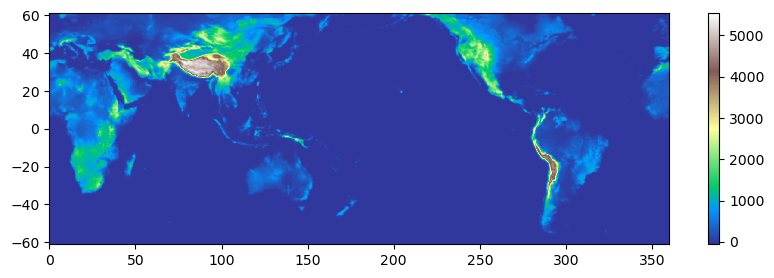

In [12]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))

fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_ter, lat_ter, ter_s, cmap='terrain')
plt.colorbar()

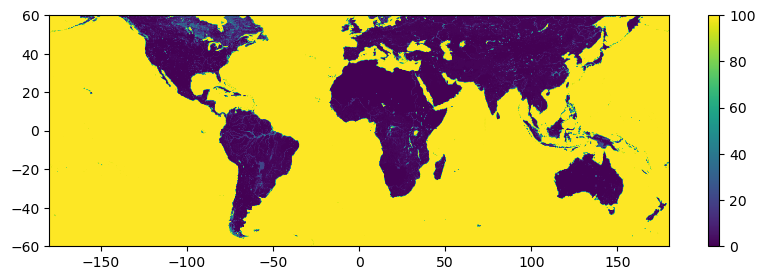

In [13]:
# Read landmask data
dslm = xr.open_dataset(landmaskfile)
lon_lm = dslm['lon']
lat_lm = dslm['lat']
# dslm = dslm.assign_coords(lon=lon_obs)
# dslm = dslm.assign_coords(lat=lat_obs)
# if PHASE == 'Winter':
#     dslm = dslm.roll(lon=1800, roll_coords=True)
#     dslm = dslm.assign_coords(lon=lon_obs)
#     dslm = dslm.assign_coords(lat=lat_obs)
    
landmask = dslm.landseamask
fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_lm, lat_lm, landmask)
plt.colorbar()

## Read and combine all sources to a single DataSet

In [14]:
drop_vars = ['latitude', 'longitude', 'lat', 'lon']
# Read all files and combine them with a new dimension 'source'
ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_pyflex['source'] = list(name_map.keys())
# Assign lat/lon coordinate from landmask
ds_pyflex = ds_pyflex.assign_coords({'lon': lon_lm, 'lat': lat_lm})
# ds_pyflex

# Average the DataSet for all model sources
mask = ds_pyflex['source'] != 'obs'
dsmmm_pyflex = ds_pyflex.sel(source=mask).mean(dim='source', keep_attrs=True)
# Expand the 'source' dimension for the averaged DataSet with 'mmm' (multi-model-mean)
new_source = np.array(['mmm'])
dsmmm_pyflex = dsmmm_pyflex.expand_dims(source=new_source)
# Combine the DataSets along the 'source' dimension
ds_pyflex = xr.concat([ds_pyflex, dsmmm_pyflex], dim='source')
ds_pyflex

<xarray.Dataset>
Dimensions:                  (source: 13, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2020-02-01
  * source                   (source) object 'obs' 'm1' 'm2' ... 'm12' 'mmm'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (source) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     PyFLEXTRKR
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Mon Nov  6 14:43:06 2023

In [15]:
# Read all files and combine them with a new dimension 'source'
ds_moaap = xr.open_mfdataset(list(filenames_MOAAP.values()), combine='nested', concat_dim='source', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_moaap['source'] = list(name_map.keys())
# Assign lat/lon coordinate from landmask
ds_moaap = ds_moaap.assign_coords({'lon': lon_lm, 'lat': lat_lm})
# ds_moaap

# Average the DataSet for all model sources
mask = ds_moaap['source'] != 'obs'
dsmmm_moaap = ds_moaap.sel(source=mask).mean(dim='source', keep_attrs=True)
# Expand the 'source' dimension for the averaged DataSet with 'mmm' (multi-model-mean)
new_source = np.array(['mmm'])
dsmmm_moaap = dsmmm_moaap.expand_dims(source=new_source)
# Combine the DataSets along the 'source' dimension
ds_moaap = xr.concat([ds_moaap, dsmmm_moaap], dim='source')
ds_moaap

<xarray.Dataset>
Dimensions:                  (source: 13, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2020-02-01
  * source                   (source) object 'obs' 'm1' 'm2' ... 'm12' 'mmm'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (source) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     MOAAP
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Tue Apr 23 17:54:28 2024

In [16]:
# Read all files and combine them with a new dimension 'source'
ds_toocan = xr.open_mfdataset(list(filenames_TOOCAN.values()), combine='nested', concat_dim='source', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_toocan['source'] = list(name_map.keys())
# Assign lat/lon coordinate from landmask
ds_toocan = ds_toocan.assign_coords({'lon': lon_lm, 'lat': lat_lm})
# ds_toocan

# Average the DataSet for all model sources
mask = ds_toocan['source'] != 'obs'
dsmmm_toocan = ds_toocan.sel(source=mask).mean(dim='source', keep_attrs=True)
# Expand the 'source' dimension for the averaged DataSet with 'mmm' (multi-model-mean)
new_source = np.array(['mmm'])
dsmmm_toocan = dsmmm_toocan.expand_dims(source=new_source)
# Combine the DataSets along the 'source' dimension
ds_toocan = xr.concat([ds_toocan, dsmmm_toocan], dim='source')
ds_toocan

<xarray.Dataset>
Dimensions:                  (source: 13, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2020-02-01
  * source                   (source) object 'obs' 'm1' 'm2' ... 'm12' 'mmm'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (source) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:       MCS precipitation accumulation from TOOCAN
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  20200201
    end_date:    20200301
    created_on:  Thu Nov  2 19:05:07 2023

In [17]:
# Read all files and combine them with a new dimension 'source'
ds_tobac = xr.open_mfdataset(list(filenames_tobac.values()), combine='nested', concat_dim='source', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_tobac['source'] = list(name_map.keys())
# Assign lat/lon coordinate from landmask
ds_tobac = ds_tobac.assign_coords({'lon': lon_lm, 'lat': lat_lm})
# ds_tobac

# Average the DataSet for all model sources
mask = ds_tobac['source'] != 'obs'
dsmmm_tobac = ds_tobac.sel(source=mask).mean(dim='source', keep_attrs=True)
# Expand the 'source' dimension for the averaged DataSet with 'mmm' (multi-model-mean)
new_source = np.array(['mmm'])
dsmmm_tobac = dsmmm_tobac.expand_dims(source=new_source)
# Combine the DataSets along the 'source' dimension
ds_tobac = xr.concat([ds_tobac, dsmmm_tobac], dim='source')
ds_tobac

<xarray.Dataset>
Dimensions:                  (source: 13, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2020-02-01
  * source                   (source) object 'obs' 'm1' 'm2' ... 'm12' 'mmm'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (source) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     tobac
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Fri May  3 19:59:59 2024

In [18]:
# Read all files and combine them with a new dimension 'source'
ds_tams = xr.open_mfdataset(list(filenames_TAMS.values()), combine='nested', concat_dim='source', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_tams['source'] = list(name_map.keys())
# Assign lat/lon coordinate from landmask
ds_tams = ds_tams.assign_coords({'lon': lon_lm, 'lat': lat_lm})
# ds_tams

# Average the DataSet for all model sources
mask = ds_tams['source'] != 'obs'
dsmmm_tams = ds_tams.sel(source=mask).mean(dim='source', keep_attrs=True)
# Expand the 'source' dimension for the averaged DataSet with 'mmm' (multi-model-mean)
new_source = np.array(['mmm'])
dsmmm_tams = dsmmm_tams.expand_dims(source=new_source)
# Combine the DataSets along the 'source' dimension
ds_tams = xr.concat([ds_tams, dsmmm_tams], dim='source')
ds_tams

<xarray.Dataset>
Dimensions:                  (source: 13, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2020-02-01
  * source                   (source) object 'obs' 'm1' 'm2' ... 'm12' 'mmm'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (source) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     TAMS
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Tue Dec 26 16:49:45 2023

In [19]:
# Read all files and combine them with a new dimension 'source'
ds_simtrack = xr.open_mfdataset(list(filenames_simpleTrack.values()), combine='nested', concat_dim='source', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_simtrack['source'] = list(name_map.keys())
# Assign lat/lon coordinate from landmask
ds_simtrack = ds_simtrack.assign_coords({'lon': lon_lm, 'lat': lat_lm})
# ds_simtrack

# Average the DataSet for all model sources
mask = ds_simtrack['source'] != 'obs'
dsmmm_simtrack = ds_simtrack.sel(source=mask).mean(dim='source', keep_attrs=True)
# Expand the 'source' dimension for the averaged DataSet with 'mmm' (multi-model-mean)
new_source = np.array(['mmm'])
dsmmm_simtrack = dsmmm_simtrack.expand_dims(source=new_source)
# Combine the DataSets along the 'source' dimension
ds_simtrack = xr.concat([ds_simtrack, dsmmm_simtrack], dim='source')
ds_simtrack

<xarray.Dataset>
Dimensions:                  (source: 13, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2020-02-01
  * source                   (source) object 'obs' 'm1' 'm2' ... 'm12' 'mmm'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (source) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     simpleTrack
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Tue Jan  9 13:15:01 2024

In [20]:
# Read all files and combine them with a new dimension 'source'
ds_dl = xr.open_mfdataset(list(filenames_DL.values()), combine='nested', concat_dim='source', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_dl['source'] = list(name_map.keys())
# Assign lat/lon coordinate from landmask
ds_dl = ds_dl.assign_coords({'lon': lon_lm, 'lat': lat_lm})
# ds_dl

# Average the DataSet for all model sources
mask = ds_dl['source'] != 'obs'
dsmmm_dl = ds_dl.sel(source=mask).mean(dim='source', keep_attrs=True)
# Expand the 'source' dimension for the averaged DataSet with 'mmm' (multi-model-mean)
new_source = np.array(['mmm'])
dsmmm_dl = dsmmm_dl.expand_dims(source=new_source)
# Combine the DataSets along the 'source' dimension
ds_dl = xr.concat([ds_dl, dsmmm_dl], dim='source')
ds_dl

<xarray.Dataset>
Dimensions:                  (source: 13, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2020-02-01
  * source                   (source) object 'obs' 'm1' 'm2' ... 'm12' 'mmm'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (source) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     DL
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Wed Jul 24 16:50:39 2024

In [21]:
# Read all files and combine them with a new dimension 'source'
ds_kfyao = xr.open_mfdataset(list(filenames_KFyAO.values()), combine='nested', concat_dim='source', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds_kfyao['source'] = list(name_map.keys())
# Assign lat/lon coordinate from landmask
ds_kfyao = ds_kfyao.assign_coords({'lon': lon_lm, 'lat': lat_lm})
# ds_kfyao

# Average the DataSet for all model sources
mask = ds_kfyao['source'] != 'obs'
dsmmm_kfyao = ds_kfyao.sel(source=mask).mean(dim='source', keep_attrs=True)
# Expand the 'source' dimension for the averaged DataSet with 'mmm' (multi-model-mean)
new_source = np.array(['mmm'])
dsmmm_kfyao = dsmmm_kfyao.expand_dims(source=new_source)
# Combine the DataSets along the 'source' dimension
ds_kfyao = xr.concat([ds_kfyao, dsmmm_kfyao], dim='source')
ds_kfyao

<xarray.Dataset>
Dimensions:                  (source: 13, lat: 1200, lon: 3600)
Coordinates:
    time                     datetime64[ns] 2020-02-01
  * source                   (source) object 'obs' 'm1' 'm2' ... 'm12' 'mmm'
  * lon                      (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (source, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (source) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     KFyAO
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Mon May 20 12:22:54 2024

## Calculate statistics

In [22]:
# Update name_map by adding 'mmm'
name_map['mmm'] = 'All Models'

In [23]:
# Total number of hours
nhours_pyflex = ds_pyflex.ntimes
# nhours_pyflex.values
print(f'Number of total hours (PyFLEXTRKR)')
for key in name_map.keys():
    print(f'{name_map[key]}: {int(nhours_pyflex.sel(source=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_pyflex = 24. * ds_pyflex.precipitation / nhours_pyflex
mcspcp_pyflex = 24. * ds_pyflex.mcs_precipitation / nhours_pyflex
nonmcspcp_pyflex = totpcp_pyflex - mcspcp_pyflex
# MCS precipitation fraction
mcspcpfrac_pyflex = 100 * mcspcp_pyflex / totpcp_pyflex

# Number of hours with MCS precipitation/cloud
mcspcphours_pyflex = ds_pyflex.mcs_precipitation_count
mcscloudhours_pyflex = ds_pyflex.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_pyflex = ds_pyflex.mcs_precipitation / mcspcphours_pyflex

# MCS precipitation frequency
mcspcpfreq_pyflex = 100 * (mcspcphours_pyflex / nhours_pyflex)
mcscloudfreq_pyflex = 100 * (mcscloudhours_pyflex / nhours_pyflex)

Number of total hours (PyFLEXTRKR)
OBS: 672
ARPEGE: 672
IFS: 672
MPAS: 672
SAM: 672
UM: 672
GRIST: 672
SCREAM: 672
XSHiELD: 673
GEOS: 696
ICON: 672
SCREAMv1: 672
All Models: 674


In [24]:
# Total number of hours
nhours_moaap = ds_moaap.ntimes
# nhours_moaap.values
print(f'Number of total hours (MOAAP)')
for key in name_map.keys():
    print(f'{name_map[key]}: {int(nhours_moaap.sel(source=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_moaap = 24. * ds_moaap.precipitation / nhours_moaap
mcspcp_moaap = 24. * ds_moaap.mcs_precipitation / nhours_moaap
nonmcspcp_moaap = totpcp_moaap - mcspcp_moaap
# MCS precipitation fraction
mcspcpfrac_moaap = 100 * mcspcp_moaap / totpcp_moaap

# Number of hours with MCS precipitation/cloud
mcspcphours_moaap = ds_moaap.mcs_precipitation_count
mcscloudhours_moaap = ds_moaap.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_moaap = ds_moaap.mcs_precipitation / mcspcphours_moaap

# MCS precipitation frequency
mcspcpfreq_moaap = 100 * (mcspcphours_moaap / nhours_moaap)
mcscloudfreq_moaap = 100 * (mcscloudhours_moaap / nhours_moaap)

Number of total hours (MOAAP)
OBS: 672
ARPEGE: 672
IFS: 672
MPAS: 672
SAM: 672
UM: 672
GRIST: 672
SCREAM: 672
XSHiELD: 673
GEOS: 696
ICON: 672
SCREAMv1: 672
All Models: 674


In [25]:
# Total number of hours
nhours_toocan = ds_toocan.ntimes
# nhours_toocan.values
print(f'Number of total hours (TOOCAN)')
for key in name_map.keys():
    print(f'{name_map[key]}: {int(nhours_toocan.sel(source=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_toocan = 24. * ds_toocan.precipitation / nhours_toocan
mcspcp_toocan = 24. * ds_toocan.mcs_precipitation / nhours_toocan
nonmcspcp_toocan = totpcp_toocan - mcspcp_toocan
# MCS precipitation fraction
mcspcpfrac_toocan = 100 * mcspcp_toocan / totpcp_toocan

# Number of hours with MCS precipitation/cloud
mcspcphours_toocan = ds_toocan.mcs_precipitation_count
mcscloudhours_toocan = ds_toocan.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_toocan = ds_toocan.mcs_precipitation / mcspcphours_toocan

# MCS precipitation frequency
mcspcpfreq_toocan = 100 * (mcspcphours_toocan / nhours_toocan)
mcscloudfreq_toocan = 100 * (mcscloudhours_toocan / nhours_toocan)

Number of total hours (TOOCAN)
OBS: 672
ARPEGE: 672
IFS: 672
MPAS: 672
SAM: 672
UM: 672
GRIST: 672
SCREAM: 672
XSHiELD: 673
GEOS: 696
ICON: 672
SCREAMv1: 672
All Models: 674


In [26]:
# Total number of hours
nhours_tobac = ds_tobac.ntimes
# nhours_tobac.values
print(f'Number of total hours (tobac)')
for key in name_map.keys():
    print(f'{name_map[key]}: {int(nhours_tobac.sel(source=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_tobac = 24. * ds_tobac.precipitation / nhours_tobac
mcspcp_tobac = 24. * ds_tobac.mcs_precipitation / nhours_tobac
nonmcspcp_tobac = totpcp_tobac - mcspcp_tobac
# MCS precipitation fraction
mcspcpfrac_tobac = 100 * mcspcp_tobac / totpcp_tobac

# Number of hours with MCS precipitation/cloud
mcspcphours_tobac = ds_tobac.mcs_precipitation_count
mcscloudhours_tobac = ds_tobac.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_tobac = ds_tobac.mcs_precipitation / mcspcphours_tobac

# MCS precipitation frequency
mcspcpfreq_tobac = 100 * (mcspcphours_tobac / nhours_tobac)
mcscloudfreq_tobac = 100 * (mcscloudhours_tobac / nhours_tobac)

Number of total hours (tobac)
OBS: 672
ARPEGE: 672
IFS: 672
MPAS: 672
SAM: 672
UM: 672
GRIST: 672
SCREAM: 672
XSHiELD: 673
GEOS: 696
ICON: 672
SCREAMv1: 672
All Models: 674


In [27]:
# Total number of hours
nhours_tams = ds_tams.ntimes
# nhours_tams.values
print(f'Number of total hours (TAMS)')
for key in name_map.keys():
    print(f'{name_map[key]}: {int(nhours_tams.sel(source=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_tams = 24. * ds_tams.precipitation / nhours_tams
mcspcp_tams = 24. * ds_tams.mcs_precipitation / nhours_tams
nonmcspcp_tams = totpcp_tams - mcspcp_tams
# MCS precipitation fraction
mcspcpfrac_tams = 100 * mcspcp_tams / totpcp_tams

# Number of hours with MCS precipitation/cloud
mcspcphours_tams = ds_tams.mcs_precipitation_count
mcscloudhours_tams = ds_tams.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_tams = ds_tams.mcs_precipitation / mcspcphours_tams

# MCS precipitation frequency
mcspcpfreq_tams = 100 * (mcspcphours_tams / nhours_tams)
mcscloudfreq_tams = 100 * (mcscloudhours_tams / nhours_tams)

Number of total hours (TAMS)
OBS: 672
ARPEGE: 672
IFS: 672
MPAS: 672
SAM: 672
UM: 672
GRIST: 672
SCREAM: 672
XSHiELD: 673
GEOS: 696
ICON: 672
SCREAMv1: 672
All Models: 674


In [28]:
# Total number of hours
nhours_simtrack = ds_simtrack.ntimes
# nhours_simtrack.values
print(f'Number of total hours (simpleTrack)')
for key in name_map.keys():
    print(f'{name_map[key]}: {int(nhours_simtrack.sel(source=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_simtrack = 24. * ds_simtrack.precipitation / nhours_simtrack
mcspcp_simtrack = 24. * ds_simtrack.mcs_precipitation / nhours_simtrack
nonmcspcp_simtrack = totpcp_simtrack - mcspcp_simtrack
# MCS precipitation fraction
mcspcpfrac_simtrack = 100 * mcspcp_simtrack / totpcp_simtrack

# Number of hours with MCS precipitation/cloud
mcspcphours_simtrack = ds_simtrack.mcs_precipitation_count
mcscloudhours_simtrack = ds_simtrack.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_simtrack = ds_simtrack.mcs_precipitation / mcspcphours_simtrack

# MCS precipitation frequency
mcspcpfreq_simtrack = 100 * (mcspcphours_simtrack / nhours_simtrack)
mcscloudfreq_simtrack = 100 * (mcscloudhours_simtrack / nhours_simtrack)

Number of total hours (simpleTrack)
OBS: 672
ARPEGE: 672
IFS: 672
MPAS: 672
SAM: 672
UM: 672
GRIST: 672
SCREAM: 672
XSHiELD: 673
GEOS: 696
ICON: 672
SCREAMv1: 672
All Models: 674


In [29]:
# Total number of hours
nhours_dl = ds_dl.ntimes
# nhours_dl.values
print(f'Number of total hours (DL)')
for key in name_map.keys():
    print(f'{name_map[key]}: {int(nhours_dl.sel(source=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_dl = 24. * ds_dl.precipitation / nhours_dl
mcspcp_dl = 24. * ds_dl.mcs_precipitation / nhours_dl
nonmcspcp_dl = totpcp_dl - mcspcp_dl
# MCS precipitation fraction
mcspcpfrac_dl = 100 * mcspcp_dl / totpcp_dl

# Number of hours with MCS precipitation/cloud
mcspcphours_dl = ds_dl.mcs_precipitation_count
mcscloudhours_dl = ds_dl.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_dl = ds_dl.mcs_precipitation / mcspcphours_dl

# MCS precipitation frequency
mcspcpfreq_dl = 100 * (mcspcphours_dl / nhours_dl)
mcscloudfreq_dl = 100 * (mcscloudhours_dl / nhours_dl)

Number of total hours (DL)
OBS: 672
ARPEGE: 672
IFS: 672
MPAS: 672
SAM: 672
UM: 672
GRIST: 672
SCREAM: 672
XSHiELD: 673
GEOS: 696
ICON: 672
SCREAMv1: 672
All Models: 674


In [30]:
# Total number of hours
nhours_kfyao = ds_kfyao.ntimes
# nhours_kfyao.values
print(f'Number of total hours (KFyAO)')
for key in name_map.keys():
    print(f'{name_map[key]}: {int(nhours_kfyao.sel(source=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_kfyao = 24. * ds_kfyao.precipitation / nhours_kfyao
mcspcp_kfyao = 24. * ds_kfyao.mcs_precipitation / nhours_kfyao
nonmcspcp_kfyao = totpcp_kfyao - mcspcp_kfyao
# MCS precipitation fraction
mcspcpfrac_kfyao = 100 * mcspcp_kfyao / totpcp_kfyao

# Number of hours with MCS precipitation/cloud
mcspcphours_kfyao = ds_kfyao.mcs_precipitation_count
mcscloudhours_kfyao = ds_kfyao.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity_kfyao = ds_kfyao.mcs_precipitation / mcspcphours_kfyao

# MCS precipitation frequency
mcspcpfreq_kfyao = 100 * (mcspcphours_kfyao / nhours_kfyao)
mcscloudfreq_kfyao = 100 * (mcscloudhours_kfyao / nhours_kfyao)

Number of total hours (KFyAO)
OBS: 672
ARPEGE: 672
IFS: 672
MPAS: 672
SAM: 672
UM: 672
GRIST: 672
SCREAM: 672
XSHiELD: 673
GEOS: 696
ICON: 672
SCREAMv1: 672
All Models: 674


In [31]:
def get_obs_model_diff(da):
    """
    Get obs, models & calculate their differences
    
    Args:
        da: DataArray
            DataArray containing multiple sources (including 'obs' & models)
            
    Returns:
        da_obs: DataArray
            DataArray containing observation
        da_mod: DataArray
            DataArray containing models
        da_diff: DataArray
            DataArray containing differences    
    """
    # Select non-obs sources (models) & obs
    da_mod = da.isel(source=da['source'] != 'obs').squeeze()
    da_obs = da.sel(source='obs').squeeze()
    # Compute the difference (model - obs)
    da_diff = da_mod - da_obs
    return (da_obs, da_mod, da_diff)

## Calculate model vs. obs differences

In [32]:
# Get obs, models, & differences
totpcp_obs_pyflex, totpcp_mod_pyflex, totpcp_diff_pyflex = get_obs_model_diff(totpcp_pyflex)
mcspcp_obs_pyflex, mcspcp_mod_pyflex, mcspcp_diff_pyflex = get_obs_model_diff(mcspcp_pyflex)
mcspcpmeanintensity_obs_pyflex, mcspcpmeanintensity_mod_pyflex, mcspcpmeanintensity_diff_pyflex = get_obs_model_diff(mcspcpmeanintensity_pyflex)
mcspcpfrac_obs_pyflex, mcspcpfrac_mod_pyflex, mcspcpfrac_diff_pyflex = get_obs_model_diff(mcspcpfrac_pyflex)

# MCS precipitation / cloud frequency
mcspcpfreq_obs_pyflex, mcspcpfreq_mod_pyflex, mcspcpfreq_diff_pyflex = get_obs_model_diff(mcspcpfreq_pyflex)
mcscloudfreq_obs_pyflex, mcscloudfreq_mod_pyflex, mcscloudfreq_diff_pyflex = get_obs_model_diff(mcscloudfreq_pyflex)

# MCS precipitation / cloud hours
mcspcphours_obs_pyflex, mcspcphours_mod_pyflex, mcspcphours_diff_pyflex = get_obs_model_diff(mcspcphours_pyflex)
mcscloudhours_obs_pyflex, mcscloudhours_mod_pyflex, mcscloudhours_diff_pyflex = get_obs_model_diff(mcscloudhours_pyflex)

In [33]:
# Get obs, models, & differences
totpcp_obs_moaap, totpcp_mod_moaap, totpcp_diff_moaap = get_obs_model_diff(totpcp_moaap)
mcspcp_obs_moaap, mcspcp_mod_moaap, mcspcp_diff_moaap = get_obs_model_diff(mcspcp_moaap)
mcspcpmeanintensity_obs_moaap, mcspcpmeanintensity_mod_moaap, mcspcpmeanintensity_diff_moaap = get_obs_model_diff(mcspcpmeanintensity_moaap)
mcspcpfrac_obs_moaap, mcspcpfrac_mod_moaap, mcspcpfrac_diff_moaap = get_obs_model_diff(mcspcpfrac_moaap)

# MCS precipitation / cloud frequency
mcspcpfreq_obs_moaap, mcspcpfreq_mod_moaap, mcspcpfreq_diff_moaap = get_obs_model_diff(mcspcpfreq_moaap)
mcscloudfreq_obs_moaap, mcscloudfreq_mod_moaap, mcscloudfreq_diff_moaap = get_obs_model_diff(mcscloudfreq_moaap)

# MCS precipitation / cloud hours
mcspcphours_obs_moaap, mcspcphours_mod_moaap, mcspcphours_diff_moaap = get_obs_model_diff(mcspcphours_moaap)
mcscloudhours_obs_moaap, mcscloudhours_mod_moaap, mcscloudhours_diff_moaap = get_obs_model_diff(mcscloudhours_moaap)

In [34]:
# Get obs, models, & differences
totpcp_obs_toocan, totpcp_mod_toocan, totpcp_diff_toocan = get_obs_model_diff(totpcp_toocan)
mcspcp_obs_toocan, mcspcp_mod_toocan, mcspcp_diff_toocan = get_obs_model_diff(mcspcp_toocan)
mcspcpmeanintensity_obs_toocan, mcspcpmeanintensity_mod_toocan, mcspcpmeanintensity_diff_toocan = get_obs_model_diff(mcspcpmeanintensity_toocan)
mcspcpfrac_obs_toocan, mcspcpfrac_mod_toocan, mcspcpfrac_diff_toocan = get_obs_model_diff(mcspcpfrac_toocan)

# MCS precipitation / cloud frequency
mcspcpfreq_obs_toocan, mcspcpfreq_mod_toocan, mcspcpfreq_diff_toocan = get_obs_model_diff(mcspcpfreq_toocan)
mcscloudfreq_obs_toocan, mcscloudfreq_mod_toocan, mcscloudfreq_diff_toocan = get_obs_model_diff(mcscloudfreq_toocan)

# MCS precipitation / cloud hours
mcspcphours_obs_toocan, mcspcphours_mod_toocan, mcspcphours_diff_toocan = get_obs_model_diff(mcspcphours_toocan)
mcscloudhours_obs_toocan, mcscloudhours_mod_toocan, mcscloudhours_diff_toocan = get_obs_model_diff(mcscloudhours_toocan)

In [35]:
# Get obs, models, & differences
totpcp_obs_tobac, totpcp_mod_tobac, totpcp_diff_tobac = get_obs_model_diff(totpcp_tobac)
mcspcp_obs_tobac, mcspcp_mod_tobac, mcspcp_diff_tobac = get_obs_model_diff(mcspcp_tobac)
mcspcpmeanintensity_obs_tobac, mcspcpmeanintensity_mod_tobac, mcspcpmeanintensity_diff_tobac = get_obs_model_diff(mcspcpmeanintensity_tobac)
mcspcpfrac_obs_tobac, mcspcpfrac_mod_tobac, mcspcpfrac_diff_tobac = get_obs_model_diff(mcspcpfrac_tobac)

# MCS precipitation / cloud frequency
mcspcpfreq_obs_tobac, mcspcpfreq_mod_tobac, mcspcpfreq_diff_tobac = get_obs_model_diff(mcspcpfreq_tobac)
mcscloudfreq_obs_tobac, mcscloudfreq_mod_tobac, mcscloudfreq_diff_tobac = get_obs_model_diff(mcscloudfreq_tobac)

# MCS precipitation / cloud hours
mcspcphours_obs_tobac, mcspcphours_mod_tobac, mcspcphours_diff_tobac = get_obs_model_diff(mcspcphours_tobac)
mcscloudhours_obs_tobac, mcscloudhours_mod_tobac, mcscloudhours_diff_tobac = get_obs_model_diff(mcscloudhours_tobac)

In [36]:
# Get obs, models, & differences
totpcp_obs_tams, totpcp_mod_tams, totpcp_diff_tams = get_obs_model_diff(totpcp_tams)
mcspcp_obs_tams, mcspcp_mod_tams, mcspcp_diff_tams = get_obs_model_diff(mcspcp_tams)
mcspcpmeanintensity_obs_tams, mcspcpmeanintensity_mod_tams, mcspcpmeanintensity_diff_tams = get_obs_model_diff(mcspcpmeanintensity_tams)
mcspcpfrac_obs_tams, mcspcpfrac_mod_tams, mcspcpfrac_diff_tams = get_obs_model_diff(mcspcpfrac_tams)

# MCS precipitation / cloud frequency
mcspcpfreq_obs_tams, mcspcpfreq_mod_tams, mcspcpfreq_diff_tams = get_obs_model_diff(mcspcpfreq_tams)
mcscloudfreq_obs_tams, mcscloudfreq_mod_tams, mcscloudfreq_diff_tams = get_obs_model_diff(mcscloudfreq_tams)

# MCS precipitation / cloud hours
mcspcphours_obs_tams, mcspcphours_mod_tams, mcspcphours_diff_tams = get_obs_model_diff(mcspcphours_tams)
mcscloudhours_obs_tams, mcscloudhours_mod_tams, mcscloudhours_diff_tams = get_obs_model_diff(mcscloudhours_tams)

In [37]:
# Get obs, models, & differences
totpcp_obs_simtrack, totpcp_mod_simtrack, totpcp_diff_simtrack = get_obs_model_diff(totpcp_simtrack)
mcspcp_obs_simtrack, mcspcp_mod_simtrack, mcspcp_diff_simtrack = get_obs_model_diff(mcspcp_simtrack)
mcspcpmeanintensity_obs_simtrack, mcspcpmeanintensity_mod_simtrack, mcspcpmeanintensity_diff_simtrack = get_obs_model_diff(mcspcpmeanintensity_simtrack)
mcspcpfrac_obs_simtrack, mcspcpfrac_mod_simtrack, mcspcpfrac_diff_simtrack = get_obs_model_diff(mcspcpfrac_simtrack)

# MCS precipitation / cloud frequency
mcspcpfreq_obs_simtrack, mcspcpfreq_mod_simtrack, mcspcpfreq_diff_simtrack = get_obs_model_diff(mcspcpfreq_simtrack)
mcscloudfreq_obs_simtrack, mcscloudfreq_mod_simtrack, mcscloudfreq_diff_simtrack = get_obs_model_diff(mcscloudfreq_simtrack)

# MCS precipitation / cloud hours
mcspcphours_obs_simtrack, mcspcphours_mod_simtrack, mcspcphours_diff_simtrack = get_obs_model_diff(mcspcphours_simtrack)
mcscloudhours_obs_simtrack, mcscloudhours_mod_simtrack, mcscloudhours_diff_simtrack = get_obs_model_diff(mcscloudhours_simtrack)

In [38]:
# Get obs, models, & differences
totpcp_obs_dl, totpcp_mod_dl, totpcp_diff_dl = get_obs_model_diff(totpcp_dl)
mcspcp_obs_dl, mcspcp_mod_dl, mcspcp_diff_dl = get_obs_model_diff(mcspcp_dl)
mcspcpmeanintensity_obs_dl, mcspcpmeanintensity_mod_dl, mcspcpmeanintensity_diff_dl = get_obs_model_diff(mcspcpmeanintensity_dl)
mcspcpfrac_obs_dl, mcspcpfrac_mod_dl, mcspcpfrac_diff_dl = get_obs_model_diff(mcspcpfrac_dl)

# MCS precipitation / cloud frequency
mcspcpfreq_obs_dl, mcspcpfreq_mod_dl, mcspcpfreq_diff_dl = get_obs_model_diff(mcspcpfreq_dl)
mcscloudfreq_obs_dl, mcscloudfreq_mod_dl, mcscloudfreq_diff_dl = get_obs_model_diff(mcscloudfreq_dl)

# MCS precipitation / cloud hours
mcspcphours_obs_dl, mcspcphours_mod_dl, mcspcphours_diff_dl = get_obs_model_diff(mcspcphours_dl)
mcscloudhours_obs_dl, mcscloudhours_mod_dl, mcscloudhours_diff_dl = get_obs_model_diff(mcscloudhours_dl)

In [39]:
# Get obs, models, & differences
totpcp_obs_kfyao, totpcp_mod_kfyao, totpcp_diff_kfyao = get_obs_model_diff(totpcp_kfyao)
mcspcp_obs_kfyao, mcspcp_mod_kfyao, mcspcp_diff_kfyao = get_obs_model_diff(mcspcp_kfyao)
mcspcpmeanintensity_obs_kfyao, mcspcpmeanintensity_mod_kfyao, mcspcpmeanintensity_diff_kfyao = get_obs_model_diff(mcspcpmeanintensity_kfyao)
mcspcpfrac_obs_kfyao, mcspcpfrac_mod_kfyao, mcspcpfrac_diff_kfyao = get_obs_model_diff(mcspcpfrac_kfyao)

# MCS precipitation / cloud frequency
mcspcpfreq_obs_kfyao, mcspcpfreq_mod_kfyao, mcspcpfreq_diff_kfyao = get_obs_model_diff(mcspcpfreq_kfyao)
mcscloudfreq_obs_kfyao, mcscloudfreq_mod_kfyao, mcscloudfreq_diff_kfyao = get_obs_model_diff(mcscloudfreq_kfyao)

# MCS precipitation / cloud hours
mcspcphours_obs_kfyao, mcspcphours_mod_kfyao, mcspcphours_diff_kfyao = get_obs_model_diff(mcspcphours_kfyao)
mcscloudhours_obs_kfyao, mcscloudhours_mod_kfyao, mcscloudhours_diff_kfyao = get_obs_model_diff(mcscloudhours_kfyao)

## Average OBS from all trackers

In [40]:
tracker_names = ['PyFLEXTRKR','MOAAP','TOOCAN','tobac',
                 'TAMS','simpleTrack','DL','KFyAO']
# MCS cloud frequency
tmp = [mcscloudfreq_obs_pyflex, mcscloudfreq_obs_moaap, mcscloudfreq_obs_toocan, mcscloudfreq_obs_tobac,
       mcscloudfreq_obs_tams, mcscloudfreq_obs_simtrack, mcscloudfreq_obs_dl, mcscloudfreq_obs_kfyao]
mcscloudfreq_obs_all = xr.concat(tmp, dim='tracker').mean(dim='tracker')

# MCS rain amount
tmp = [mcspcp_obs_pyflex, mcspcp_obs_moaap, mcspcp_obs_toocan, mcspcp_obs_tobac,
       mcspcp_obs_tams, mcspcp_obs_simtrack, mcspcp_obs_dl, mcspcp_obs_kfyao]
mcspcp_obs_all = xr.concat(tmp, dim='tracker').mean(dim='tracker')

# MCS rain fraction
tmp = [mcspcpfrac_obs_pyflex, mcspcpfrac_obs_moaap, mcspcpfrac_obs_toocan, mcspcpfrac_obs_tobac,
       mcspcpfrac_obs_tams, mcspcpfrac_obs_simtrack, mcspcpfrac_obs_dl, mcspcpfrac_obs_kfyao]
mcspcpfrac_obs_all = xr.concat(tmp, dim='tracker').mean(dim='tracker')

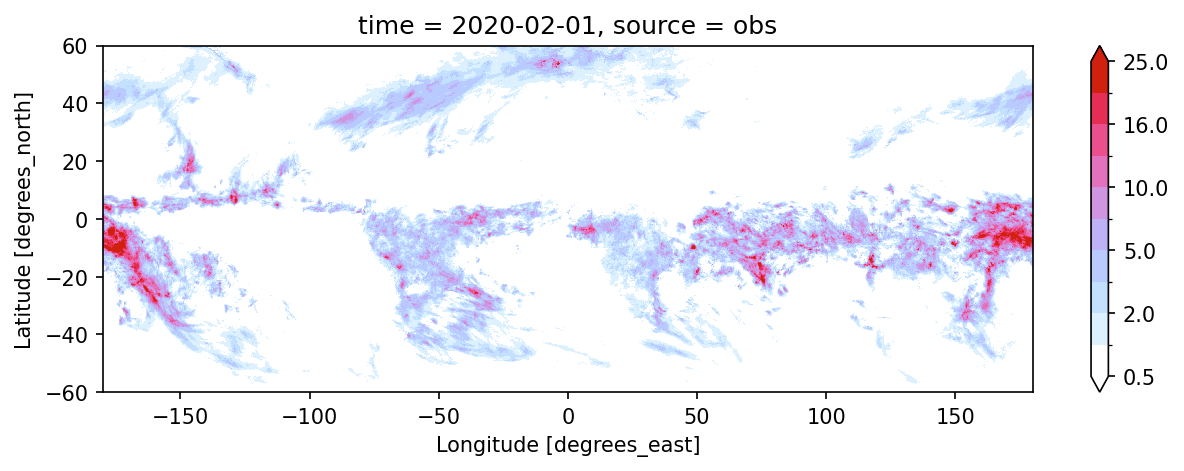

In [41]:
fig = plt.figure(figsize=(10,3),dpi=150)
levels = [0.5,1,2,3,5,7,10,13,16,20,25]
cmap = cc.cm.CET_L19
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
mcspcp_obs_all.plot(norm=norm, cmap=cmap)

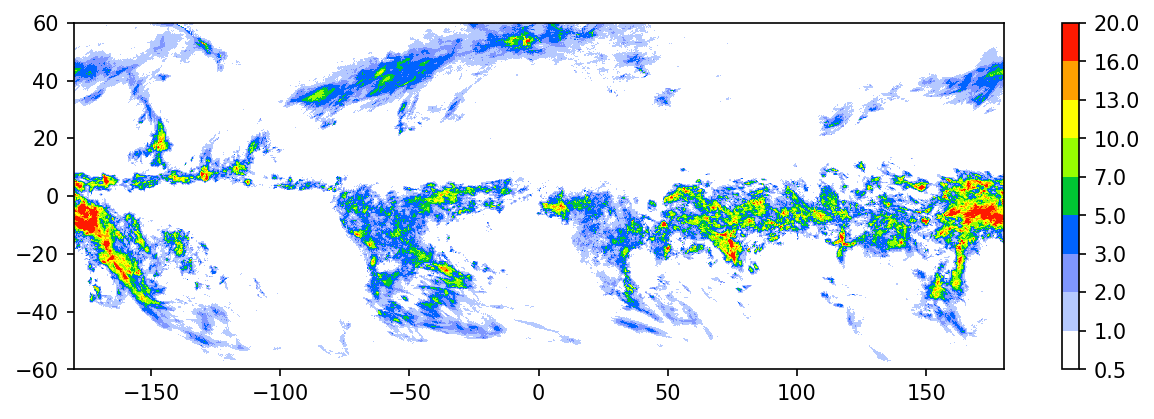

In [42]:
fig = plt.figure(figsize=(10,3),dpi=150)
levels = [0.5,1,2,3,5,7,10,13,16,20]
# cmap = cc.cm.rainbow
cmap = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
cmap = copy.copy(mpl.colormaps.get_cmap(cmap))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
plt.pcolormesh(lon_lm, lat_lm, mcspcp_obs_all, norm=norm, cmap=cmap)
plt.colorbar()

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


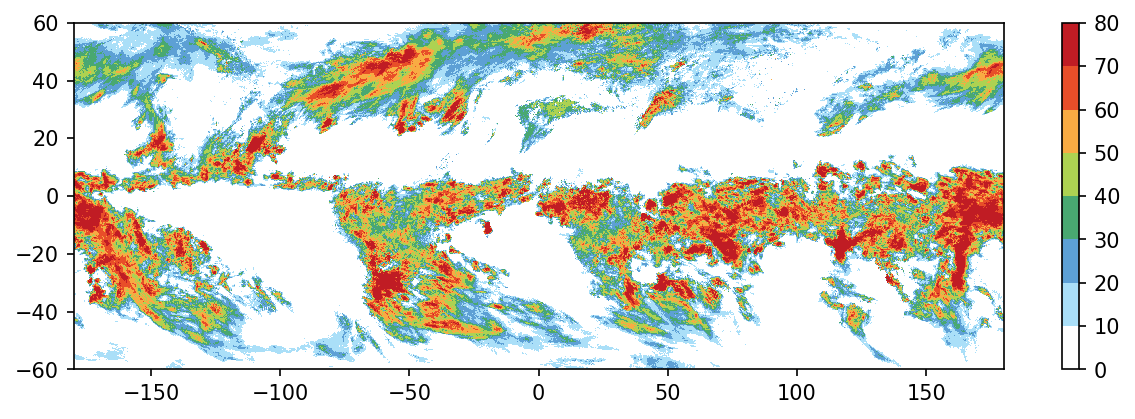

In [43]:
fig = plt.figure(figsize=(10,3),dpi=150)
levels = np.arange(0,80.1,10)
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap = truncate_colormap(cmap, 0.0, 0.9)
cmap = copy.copy(mpl.colormaps.get_cmap(cmap))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
plt.pcolormesh(lon_lm, lat_lm, mcspcpfrac_obs_all, norm=norm, cmap=cmap)
plt.colorbar()

## Separate ocean vs. land

### PyFLEXTRKR

In [44]:
# Ocean vs. Land threshold (%)
ocean_thresh = 99
land_thresh = 20

# Get obs, models, & differences
totpcp_o_obs_pyflex, totpcp_o_mod_pyflex, totpcp_o_diff_pyflex = get_obs_model_diff(totpcp_pyflex.where(landmask >= ocean_thresh))
mcspcp_o_obs_pyflex, mcspcp_o_mod_pyflex, mcspcp_o_diff_pyflex = get_obs_model_diff(mcspcp_pyflex.where(landmask >= ocean_thresh))
mcspcpmeanintensity_o_obs_pyflex, mcspcpmeanintensity_o_mod_pyflex, mcspcpmeanintensity_o_diff_pyflex = get_obs_model_diff(mcspcpmeanintensity_pyflex.where(landmask >= ocean_thresh))
mcspcpfrac_o_obs_pyflex, mcspcpfrac_o_mod_pyflex, mcspcpfrac_o_diff_pyflex = get_obs_model_diff(mcspcpfrac_pyflex.where(landmask >= ocean_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_o_obs_pyflex, mcspcpfreq_o_mod_pyflex, mcspcpfreq_o_diff_pyflex = get_obs_model_diff(mcspcpfreq_pyflex.where(landmask >= ocean_thresh))
mcscloudfreq_o_obs_pyflex, mcscloudfreq_o_mod_pyflex, mcscloudfreq_o_diff_pyflex = get_obs_model_diff(mcscloudfreq_pyflex.where(landmask >= ocean_thresh))

# MCS precipitation / cloud hours
mcspcphours_o_obs_pyflex, mcspcphours_o_mod_pyflex, mcspcphours_o_diff_pyflex = get_obs_model_diff(mcspcphours_pyflex.where(landmask >= ocean_thresh))
mcscloudhours_o_obs_pyflex, mcscloudhours_o_mod_pyflex, mcscloudhours_o_diff_pyflex = get_obs_model_diff(mcscloudhours_pyflex.where(landmask >= ocean_thresh))

# Get obs, models, & differences
totpcp_l_obs_pyflex, totpcp_l_mod_pyflex, totpcp_l_diff_pyflex = get_obs_model_diff(totpcp_pyflex.where(landmask <= land_thresh))
mcspcp_l_obs_pyflex, mcspcp_l_mod_pyflex, mcspcp_l_diff_pyflex = get_obs_model_diff(mcspcp_pyflex.where(landmask <= land_thresh))
mcspcpmeanintensity_l_obs_pyflex, mcspcpmeanintensity_l_mod_pyflex, mcspcpmeanintensity_l_diff_pyflex = get_obs_model_diff(mcspcpmeanintensity_pyflex.where(landmask <= land_thresh))
mcspcpfrac_l_obs_pyflex, mcspcpfrac_l_mod_pyflex, mcspcpfrac_l_diff_pyflex = get_obs_model_diff(mcspcpfrac_pyflex.where(landmask <= land_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_l_obs_pyflex, mcspcpfreq_l_mod_pyflex, mcspcpfreq_l_diff_pyflex = get_obs_model_diff(mcspcpfreq_pyflex.where(landmask <= land_thresh))
mcscloudfreq_l_obs_pyflex, mcscloudfreq_l_mod_pyflex, mcscloudfreq_l_diff_pyflex = get_obs_model_diff(mcscloudfreq_pyflex.where(landmask <= land_thresh))

# MCS precipitation / cloud hours
mcspcphours_l_obs_pyflex, mcspcphours_l_mod_pyflex, mcspcphours_l_diff_pyflex = get_obs_model_diff(mcspcphours_pyflex.where(landmask <= land_thresh))
mcscloudhours_l_obs_pyflex, mcscloudhours_l_mod_pyflex, mcscloudhours_l_diff_pyflex = get_obs_model_diff(mcscloudhours_pyflex.where(landmask <= land_thresh))

### MOAAP

In [45]:
# Get obs, models, & differences
totpcp_o_obs_moaap, totpcp_o_mod_moaap, totpcp_o_diff_moaap = get_obs_model_diff(totpcp_moaap.where(landmask >= ocean_thresh))
mcspcp_o_obs_moaap, mcspcp_o_mod_moaap, mcspcp_o_diff_moaap = get_obs_model_diff(mcspcp_moaap.where(landmask >= ocean_thresh))
mcspcpmeanintensity_o_obs_moaap, mcspcpmeanintensity_o_mod_moaap, mcspcpmeanintensity_o_diff_moaap = get_obs_model_diff(mcspcpmeanintensity_moaap.where(landmask >= ocean_thresh))
mcspcpfrac_o_obs_moaap, mcspcpfrac_o_mod_moaap, mcspcpfrac_o_diff_moaap = get_obs_model_diff(mcspcpfrac_moaap.where(landmask >= ocean_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_o_obs_moaap, mcspcpfreq_o_mod_moaap, mcspcpfreq_o_diff_moaap = get_obs_model_diff(mcspcpfreq_moaap.where(landmask >= ocean_thresh))
mcscloudfreq_o_obs_moaap, mcscloudfreq_o_mod_moaap, mcscloudfreq_o_diff_moaap = get_obs_model_diff(mcscloudfreq_moaap.where(landmask >= ocean_thresh))

# MCS precipitation / cloud hours
mcspcphours_o_obs_moaap, mcspcphours_o_mod_moaap, mcspcphours_o_diff_moaap = get_obs_model_diff(mcspcphours_moaap.where(landmask >= ocean_thresh))
mcscloudhours_o_obs_moaap, mcscloudhours_o_mod_moaap, mcscloudhours_o_diff_moaap = get_obs_model_diff(mcscloudhours_moaap.where(landmask >= ocean_thresh))

# Get obs, models, & differences
totpcp_l_obs_moaap, totpcp_l_mod_moaap, totpcp_l_diff_moaap = get_obs_model_diff(totpcp_moaap.where(landmask <= land_thresh))
mcspcp_l_obs_moaap, mcspcp_l_mod_moaap, mcspcp_l_diff_moaap = get_obs_model_diff(mcspcp_moaap.where(landmask <= land_thresh))
mcspcpmeanintensity_l_obs_moaap, mcspcpmeanintensity_l_mod_moaap, mcspcpmeanintensity_l_diff_moaap = get_obs_model_diff(mcspcpmeanintensity_moaap.where(landmask <= land_thresh))
mcspcpfrac_l_obs_moaap, mcspcpfrac_l_mod_moaap, mcspcpfrac_l_diff_moaap = get_obs_model_diff(mcspcpfrac_moaap.where(landmask <= land_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_l_obs_moaap, mcspcpfreq_l_mod_moaap, mcspcpfreq_l_diff_moaap = get_obs_model_diff(mcspcpfreq_moaap.where(landmask <= land_thresh))
mcscloudfreq_l_obs_moaap, mcscloudfreq_l_mod_moaap, mcscloudfreq_l_diff_moaap = get_obs_model_diff(mcscloudfreq_moaap.where(landmask <= land_thresh))

# MCS precipitation / cloud hours
mcspcphours_l_obs_moaap, mcspcphours_l_mod_moaap, mcspcphours_l_diff_moaap = get_obs_model_diff(mcspcphours_moaap.where(landmask <= land_thresh))
mcscloudhours_l_obs_moaap, mcscloudhours_l_mod_moaap, mcscloudhours_l_diff_moaap = get_obs_model_diff(mcscloudhours_moaap.where(landmask <= land_thresh))

### TOOCAN

In [46]:
# Get obs, models, & differences
totpcp_o_obs_toocan, totpcp_o_mod_toocan, totpcp_o_diff_toocan = get_obs_model_diff(totpcp_toocan.where(landmask >= ocean_thresh))
mcspcp_o_obs_toocan, mcspcp_o_mod_toocan, mcspcp_o_diff_toocan = get_obs_model_diff(mcspcp_toocan.where(landmask >= ocean_thresh))
mcspcpmeanintensity_o_obs_toocan, mcspcpmeanintensity_o_mod_toocan, mcspcpmeanintensity_o_diff_toocan = get_obs_model_diff(mcspcpmeanintensity_toocan.where(landmask >= ocean_thresh))
mcspcpfrac_o_obs_toocan, mcspcpfrac_o_mod_toocan, mcspcpfrac_o_diff_toocan = get_obs_model_diff(mcspcpfrac_toocan.where(landmask >= ocean_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_o_obs_toocan, mcspcpfreq_o_mod_toocan, mcspcpfreq_o_diff_toocan = get_obs_model_diff(mcspcpfreq_toocan.where(landmask >= ocean_thresh))
mcscloudfreq_o_obs_toocan, mcscloudfreq_o_mod_toocan, mcscloudfreq_o_diff_toocan = get_obs_model_diff(mcscloudfreq_toocan.where(landmask >= ocean_thresh))

# MCS precipitation / cloud hours
mcspcphours_o_obs_toocan, mcspcphours_o_mod_toocan, mcspcphours_o_diff_toocan = get_obs_model_diff(mcspcphours_toocan.where(landmask >= ocean_thresh))
mcscloudhours_o_obs_toocan, mcscloudhours_o_mod_toocan, mcscloudhours_o_diff_toocan = get_obs_model_diff(mcscloudhours_toocan.where(landmask >= ocean_thresh))

# Get obs, models, & differences
totpcp_l_obs_toocan, totpcp_l_mod_toocan, totpcp_l_diff_toocan = get_obs_model_diff(totpcp_toocan.where(landmask <= land_thresh))
mcspcp_l_obs_toocan, mcspcp_l_mod_toocan, mcspcp_l_diff_toocan = get_obs_model_diff(mcspcp_toocan.where(landmask <= land_thresh))
mcspcpmeanintensity_l_obs_toocan, mcspcpmeanintensity_l_mod_toocan, mcspcpmeanintensity_l_diff_toocan = get_obs_model_diff(mcspcpmeanintensity_toocan.where(landmask <= land_thresh))
mcspcpfrac_l_obs_toocan, mcspcpfrac_l_mod_toocan, mcspcpfrac_l_diff_toocan = get_obs_model_diff(mcspcpfrac_toocan.where(landmask <= land_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_l_obs_toocan, mcspcpfreq_l_mod_toocan, mcspcpfreq_l_diff_toocan = get_obs_model_diff(mcspcpfreq_toocan.where(landmask <= land_thresh))
mcscloudfreq_l_obs_toocan, mcscloudfreq_l_mod_toocan, mcscloudfreq_l_diff_toocan = get_obs_model_diff(mcscloudfreq_toocan.where(landmask <= land_thresh))

# MCS precipitation / cloud hours
mcspcphours_l_obs_toocan, mcspcphours_l_mod_toocan, mcspcphours_l_diff_toocan = get_obs_model_diff(mcspcphours_toocan.where(landmask <= land_thresh))
mcscloudhours_l_obs_toocan, mcscloudhours_l_mod_toocan, mcscloudhours_l_diff_toocan = get_obs_model_diff(mcscloudhours_toocan.where(landmask <= land_thresh))

### tobac

In [47]:
# Get obs, models, & differences
totpcp_o_obs_tobac, totpcp_o_mod_tobac, totpcp_o_diff_tobac = get_obs_model_diff(totpcp_tobac.where(landmask >= ocean_thresh))
mcspcp_o_obs_tobac, mcspcp_o_mod_tobac, mcspcp_o_diff_tobac = get_obs_model_diff(mcspcp_tobac.where(landmask >= ocean_thresh))
mcspcpmeanintensity_o_obs_tobac, mcspcpmeanintensity_o_mod_tobac, mcspcpmeanintensity_o_diff_tobac = get_obs_model_diff(mcspcpmeanintensity_tobac.where(landmask >= ocean_thresh))
mcspcpfrac_o_obs_tobac, mcspcpfrac_o_mod_tobac, mcspcpfrac_o_diff_tobac = get_obs_model_diff(mcspcpfrac_tobac.where(landmask >= ocean_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_o_obs_tobac, mcspcpfreq_o_mod_tobac, mcspcpfreq_o_diff_tobac = get_obs_model_diff(mcspcpfreq_tobac.where(landmask >= ocean_thresh))
mcscloudfreq_o_obs_tobac, mcscloudfreq_o_mod_tobac, mcscloudfreq_o_diff_tobac = get_obs_model_diff(mcscloudfreq_tobac.where(landmask >= ocean_thresh))

# MCS precipitation / cloud hours
mcspcphours_o_obs_tobac, mcspcphours_o_mod_tobac, mcspcphours_o_diff_tobac = get_obs_model_diff(mcspcphours_tobac.where(landmask >= ocean_thresh))
mcscloudhours_o_obs_tobac, mcscloudhours_o_mod_tobac, mcscloudhours_o_diff_tobac = get_obs_model_diff(mcscloudhours_tobac.where(landmask >= ocean_thresh))

# Get obs, models, & differences
totpcp_l_obs_tobac, totpcp_l_mod_tobac, totpcp_l_diff_tobac = get_obs_model_diff(totpcp_tobac.where(landmask <= land_thresh))
mcspcp_l_obs_tobac, mcspcp_l_mod_tobac, mcspcp_l_diff_tobac = get_obs_model_diff(mcspcp_tobac.where(landmask <= land_thresh))
mcspcpmeanintensity_l_obs_tobac, mcspcpmeanintensity_l_mod_tobac, mcspcpmeanintensity_l_diff_tobac = get_obs_model_diff(mcspcpmeanintensity_tobac.where(landmask <= land_thresh))
mcspcpfrac_l_obs_tobac, mcspcpfrac_l_mod_tobac, mcspcpfrac_l_diff_tobac = get_obs_model_diff(mcspcpfrac_tobac.where(landmask <= land_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_l_obs_tobac, mcspcpfreq_l_mod_tobac, mcspcpfreq_l_diff_tobac = get_obs_model_diff(mcspcpfreq_tobac.where(landmask <= land_thresh))
mcscloudfreq_l_obs_tobac, mcscloudfreq_l_mod_tobac, mcscloudfreq_l_diff_tobac = get_obs_model_diff(mcscloudfreq_tobac.where(landmask <= land_thresh))

# MCS precipitation / cloud hours
mcspcphours_l_obs_tobac, mcspcphours_l_mod_tobac, mcspcphours_l_diff_tobac = get_obs_model_diff(mcspcphours_tobac.where(landmask <= land_thresh))
mcscloudhours_l_obs_tobac, mcscloudhours_l_mod_tobac, mcscloudhours_l_diff_tobac = get_obs_model_diff(mcscloudhours_tobac.where(landmask <= land_thresh))

## TAMS

In [48]:
# Get obs, models, & differences
totpcp_o_obs_tams, totpcp_o_mod_tams, totpcp_o_diff_tams = get_obs_model_diff(totpcp_tams.where(landmask >= ocean_thresh))
mcspcp_o_obs_tams, mcspcp_o_mod_tams, mcspcp_o_diff_tams = get_obs_model_diff(mcspcp_tams.where(landmask >= ocean_thresh))
mcspcpmeanintensity_o_obs_tams, mcspcpmeanintensity_o_mod_tams, mcspcpmeanintensity_o_diff_tams = get_obs_model_diff(mcspcpmeanintensity_tams.where(landmask >= ocean_thresh))
mcspcpfrac_o_obs_tams, mcspcpfrac_o_mod_tams, mcspcpfrac_o_diff_tams = get_obs_model_diff(mcspcpfrac_tams.where(landmask >= ocean_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_o_obs_tams, mcspcpfreq_o_mod_tams, mcspcpfreq_o_diff_tams = get_obs_model_diff(mcspcpfreq_tams.where(landmask >= ocean_thresh))
mcscloudfreq_o_obs_tams, mcscloudfreq_o_mod_tams, mcscloudfreq_o_diff_tams = get_obs_model_diff(mcscloudfreq_tams.where(landmask >= ocean_thresh))

# MCS precipitation / cloud hours
mcspcphours_o_obs_tams, mcspcphours_o_mod_tams, mcspcphours_o_diff_tams = get_obs_model_diff(mcspcphours_tams.where(landmask >= ocean_thresh))
mcscloudhours_o_obs_tams, mcscloudhours_o_mod_tams, mcscloudhours_o_diff_tams = get_obs_model_diff(mcscloudhours_tams.where(landmask >= ocean_thresh))

# Get obs, models, & differences
totpcp_l_obs_tams, totpcp_l_mod_tams, totpcp_l_diff_tams = get_obs_model_diff(totpcp_tams.where(landmask <= land_thresh))
mcspcp_l_obs_tams, mcspcp_l_mod_tams, mcspcp_l_diff_tams = get_obs_model_diff(mcspcp_tams.where(landmask <= land_thresh))
mcspcpmeanintensity_l_obs_tams, mcspcpmeanintensity_l_mod_tams, mcspcpmeanintensity_l_diff_tams = get_obs_model_diff(mcspcpmeanintensity_tams.where(landmask <= land_thresh))
mcspcpfrac_l_obs_tams, mcspcpfrac_l_mod_tams, mcspcpfrac_l_diff_tams = get_obs_model_diff(mcspcpfrac_tams.where(landmask <= land_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_l_obs_tams, mcspcpfreq_l_mod_tams, mcspcpfreq_l_diff_tams = get_obs_model_diff(mcspcpfreq_tams.where(landmask <= land_thresh))
mcscloudfreq_l_obs_tams, mcscloudfreq_l_mod_tams, mcscloudfreq_l_diff_tams = get_obs_model_diff(mcscloudfreq_tams.where(landmask <= land_thresh))

# MCS precipitation / cloud hours
mcspcphours_l_obs_tams, mcspcphours_l_mod_tams, mcspcphours_l_diff_tams = get_obs_model_diff(mcspcphours_tams.where(landmask <= land_thresh))
mcscloudhours_l_obs_tams, mcscloudhours_l_mod_tams, mcscloudhours_l_diff_tams = get_obs_model_diff(mcscloudhours_tams.where(landmask <= land_thresh))

## simpleTrack

In [49]:
# Get obs, models, & differences
totpcp_o_obs_simtrack, totpcp_o_mod_simtrack, totpcp_o_diff_simtrack = get_obs_model_diff(totpcp_simtrack.where(landmask >= ocean_thresh))
mcspcp_o_obs_simtrack, mcspcp_o_mod_simtrack, mcspcp_o_diff_simtrack = get_obs_model_diff(mcspcp_simtrack.where(landmask >= ocean_thresh))
mcspcpmeanintensity_o_obs_simtrack, mcspcpmeanintensity_o_mod_simtrack, mcspcpmeanintensity_o_diff_simtrack = get_obs_model_diff(mcspcpmeanintensity_simtrack.where(landmask >= ocean_thresh))
mcspcpfrac_o_obs_simtrack, mcspcpfrac_o_mod_simtrack, mcspcpfrac_o_diff_simtrack = get_obs_model_diff(mcspcpfrac_simtrack.where(landmask >= ocean_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_o_obs_simtrack, mcspcpfreq_o_mod_simtrack, mcspcpfreq_o_diff_simtrack = get_obs_model_diff(mcspcpfreq_simtrack.where(landmask >= ocean_thresh))
mcscloudfreq_o_obs_simtrack, mcscloudfreq_o_mod_simtrack, mcscloudfreq_o_diff_simtrack = get_obs_model_diff(mcscloudfreq_simtrack.where(landmask >= ocean_thresh))

# MCS precipitation / cloud hours
mcspcphours_o_obs_simtrack, mcspcphours_o_mod_simtrack, mcspcphours_o_diff_simtrack = get_obs_model_diff(mcspcphours_simtrack.where(landmask >= ocean_thresh))
mcscloudhours_o_obs_simtrack, mcscloudhours_o_mod_simtrack, mcscloudhours_o_diff_simtrack = get_obs_model_diff(mcscloudhours_simtrack.where(landmask >= ocean_thresh))

# Get obs, models, & differences
totpcp_l_obs_simtrack, totpcp_l_mod_simtrack, totpcp_l_diff_simtrack = get_obs_model_diff(totpcp_simtrack.where(landmask <= land_thresh))
mcspcp_l_obs_simtrack, mcspcp_l_mod_simtrack, mcspcp_l_diff_simtrack = get_obs_model_diff(mcspcp_simtrack.where(landmask <= land_thresh))
mcspcpmeanintensity_l_obs_simtrack, mcspcpmeanintensity_l_mod_simtrack, mcspcpmeanintensity_l_diff_simtrack = get_obs_model_diff(mcspcpmeanintensity_simtrack.where(landmask <= land_thresh))
mcspcpfrac_l_obs_simtrack, mcspcpfrac_l_mod_simtrack, mcspcpfrac_l_diff_simtrack = get_obs_model_diff(mcspcpfrac_simtrack.where(landmask <= land_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_l_obs_simtrack, mcspcpfreq_l_mod_simtrack, mcspcpfreq_l_diff_simtrack = get_obs_model_diff(mcspcpfreq_simtrack.where(landmask <= land_thresh))
mcscloudfreq_l_obs_simtrack, mcscloudfreq_l_mod_simtrack, mcscloudfreq_l_diff_simtrack = get_obs_model_diff(mcscloudfreq_simtrack.where(landmask <= land_thresh))

# MCS precipitation / cloud hours
mcspcphours_l_obs_simtrack, mcspcphours_l_mod_simtrack, mcspcphours_l_diff_simtrack = get_obs_model_diff(mcspcphours_simtrack.where(landmask <= land_thresh))
mcscloudhours_l_obs_simtrack, mcscloudhours_l_mod_simtrack, mcscloudhours_l_diff_simtrack = get_obs_model_diff(mcscloudhours_simtrack.where(landmask <= land_thresh))

## DL

In [50]:
# Get obs, models, & differences
totpcp_o_obs_dl, totpcp_o_mod_dl, totpcp_o_diff_dl = get_obs_model_diff(totpcp_dl.where(landmask >= ocean_thresh))
mcspcp_o_obs_dl, mcspcp_o_mod_dl, mcspcp_o_diff_dl = get_obs_model_diff(mcspcp_dl.where(landmask >= ocean_thresh))
mcspcpmeanintensity_o_obs_dl, mcspcpmeanintensity_o_mod_dl, mcspcpmeanintensity_o_diff_dl = get_obs_model_diff(mcspcpmeanintensity_dl.where(landmask >= ocean_thresh))
mcspcpfrac_o_obs_dl, mcspcpfrac_o_mod_dl, mcspcpfrac_o_diff_dl = get_obs_model_diff(mcspcpfrac_dl.where(landmask >= ocean_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_o_obs_dl, mcspcpfreq_o_mod_dl, mcspcpfreq_o_diff_dl = get_obs_model_diff(mcspcpfreq_dl.where(landmask >= ocean_thresh))
mcscloudfreq_o_obs_dl, mcscloudfreq_o_mod_dl, mcscloudfreq_o_diff_dl = get_obs_model_diff(mcscloudfreq_dl.where(landmask >= ocean_thresh))

# MCS precipitation / cloud hours
mcspcphours_o_obs_dl, mcspcphours_o_mod_dl, mcspcphours_o_diff_dl = get_obs_model_diff(mcspcphours_dl.where(landmask >= ocean_thresh))
mcscloudhours_o_obs_dl, mcscloudhours_o_mod_dl, mcscloudhours_o_diff_dl = get_obs_model_diff(mcscloudhours_dl.where(landmask >= ocean_thresh))

# Get obs, models, & differences
totpcp_l_obs_dl, totpcp_l_mod_dl, totpcp_l_diff_dl = get_obs_model_diff(totpcp_dl.where(landmask <= land_thresh))
mcspcp_l_obs_dl, mcspcp_l_mod_dl, mcspcp_l_diff_dl = get_obs_model_diff(mcspcp_dl.where(landmask <= land_thresh))
mcspcpmeanintensity_l_obs_dl, mcspcpmeanintensity_l_mod_dl, mcspcpmeanintensity_l_diff_dl = get_obs_model_diff(mcspcpmeanintensity_dl.where(landmask <= land_thresh))
mcspcpfrac_l_obs_dl, mcspcpfrac_l_mod_dl, mcspcpfrac_l_diff_dl = get_obs_model_diff(mcspcpfrac_dl.where(landmask <= land_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_l_obs_dl, mcspcpfreq_l_mod_dl, mcspcpfreq_l_diff_dl = get_obs_model_diff(mcspcpfreq_dl.where(landmask <= land_thresh))
mcscloudfreq_l_obs_dl, mcscloudfreq_l_mod_dl, mcscloudfreq_l_diff_dl = get_obs_model_diff(mcscloudfreq_dl.where(landmask <= land_thresh))

# MCS precipitation / cloud hours
mcspcphours_l_obs_dl, mcspcphours_l_mod_dl, mcspcphours_l_diff_dl = get_obs_model_diff(mcspcphours_dl.where(landmask <= land_thresh))
mcscloudhours_l_obs_dl, mcscloudhours_l_mod_dl, mcscloudhours_l_diff_dl = get_obs_model_diff(mcscloudhours_dl.where(landmask <= land_thresh))

## KFyAO

In [51]:
# Get obs, models, & differences
totpcp_o_obs_kfyao, totpcp_o_mod_kfyao, totpcp_o_diff_kfyao = get_obs_model_diff(totpcp_kfyao.where(landmask >= ocean_thresh))
mcspcp_o_obs_kfyao, mcspcp_o_mod_kfyao, mcspcp_o_diff_kfyao = get_obs_model_diff(mcspcp_kfyao.where(landmask >= ocean_thresh))
mcspcpmeanintensity_o_obs_kfyao, mcspcpmeanintensity_o_mod_kfyao, mcspcpmeanintensity_o_diff_kfyao = get_obs_model_diff(mcspcpmeanintensity_kfyao.where(landmask >= ocean_thresh))
mcspcpfrac_o_obs_kfyao, mcspcpfrac_o_mod_kfyao, mcspcpfrac_o_diff_kfyao = get_obs_model_diff(mcspcpfrac_kfyao.where(landmask >= ocean_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_o_obs_kfyao, mcspcpfreq_o_mod_kfyao, mcspcpfreq_o_diff_kfyao = get_obs_model_diff(mcspcpfreq_kfyao.where(landmask >= ocean_thresh))
mcscloudfreq_o_obs_kfyao, mcscloudfreq_o_mod_kfyao, mcscloudfreq_o_diff_kfyao = get_obs_model_diff(mcscloudfreq_kfyao.where(landmask >= ocean_thresh))

# MCS precipitation / cloud hours
mcspcphours_o_obs_kfyao, mcspcphours_o_mod_kfyao, mcspcphours_o_diff_kfyao = get_obs_model_diff(mcspcphours_kfyao.where(landmask >= ocean_thresh))
mcscloudhours_o_obs_kfyao, mcscloudhours_o_mod_kfyao, mcscloudhours_o_diff_kfyao = get_obs_model_diff(mcscloudhours_kfyao.where(landmask >= ocean_thresh))

# Get obs, models, & differences
totpcp_l_obs_kfyao, totpcp_l_mod_kfyao, totpcp_l_diff_kfyao = get_obs_model_diff(totpcp_kfyao.where(landmask <= land_thresh))
mcspcp_l_obs_kfyao, mcspcp_l_mod_kfyao, mcspcp_l_diff_kfyao = get_obs_model_diff(mcspcp_kfyao.where(landmask <= land_thresh))
mcspcpmeanintensity_l_obs_kfyao, mcspcpmeanintensity_l_mod_kfyao, mcspcpmeanintensity_l_diff_kfyao = get_obs_model_diff(mcspcpmeanintensity_kfyao.where(landmask <= land_thresh))
mcspcpfrac_l_obs_kfyao, mcspcpfrac_l_mod_kfyao, mcspcpfrac_l_diff_kfyao = get_obs_model_diff(mcspcpfrac_kfyao.where(landmask <= land_thresh))

# MCS precipitation / cloud frequency
mcspcpfreq_l_obs_kfyao, mcspcpfreq_l_mod_kfyao, mcspcpfreq_l_diff_kfyao = get_obs_model_diff(mcspcpfreq_kfyao.where(landmask <= land_thresh))
mcscloudfreq_l_obs_kfyao, mcscloudfreq_l_mod_kfyao, mcscloudfreq_l_diff_kfyao = get_obs_model_diff(mcscloudfreq_kfyao.where(landmask <= land_thresh))

# MCS precipitation / cloud hours
mcspcphours_l_obs_kfyao, mcspcphours_l_mod_kfyao, mcspcphours_l_diff_kfyao = get_obs_model_diff(mcspcphours_kfyao.where(landmask <= land_thresh))
mcscloudhours_l_obs_kfyao, mcscloudhours_l_mod_kfyao, mcscloudhours_l_diff_kfyao = get_obs_model_diff(mcscloudhours_kfyao.where(landmask <= land_thresh))

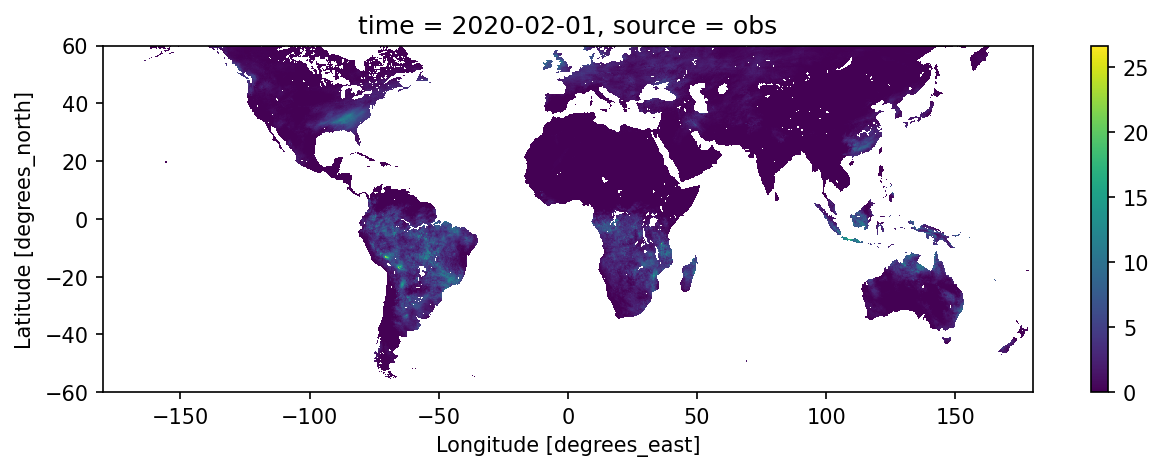

In [52]:
fig = plt.figure(figsize=(10,3),dpi=150)
mcspcp_l_obs_pyflex.plot()

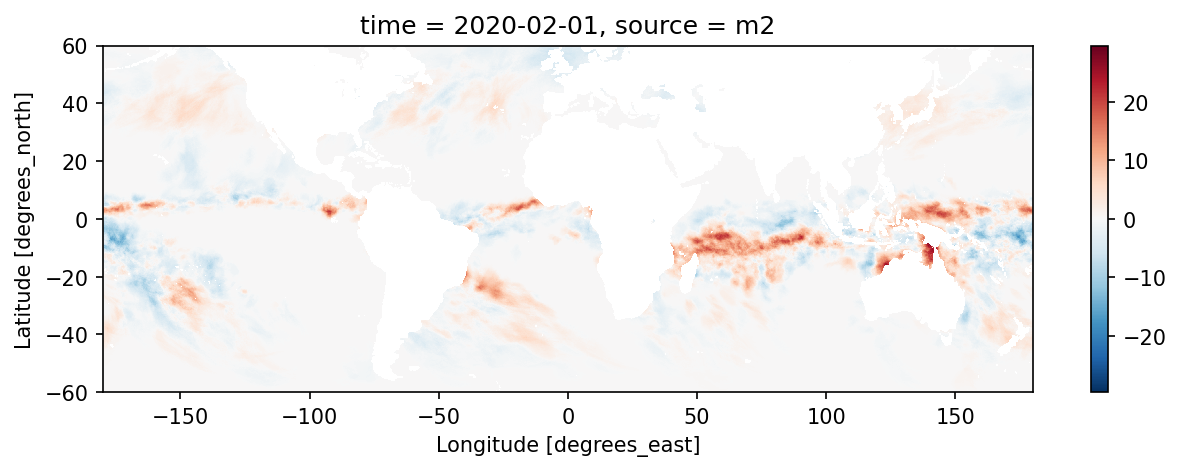

In [53]:
fig = plt.figure(figsize=(10,3),dpi=150)
mcscloudfreq_o_diff_tobac.sel(source='m2').plot()

In [54]:
# fig = plt.figure(figsize=(10,3),dpi=150)
# mcscloudfreq_o_diff_kfyao.sel(source='m2').plot()

In [55]:
# fig = plt.figure(figsize=(10,3),dpi=150)
# mcscloudfreq_o_diff_tams.sel(source='m2').plot()

In [56]:
# fig = plt.figure(figsize=(10,3),dpi=150)
# mcscloudfreq_o_diff_moaap.sel(source='m2').plot()

In [57]:
# # name_map
# fig = plt.figure(figsize=(10,3),dpi=150)
# mcscloudfreq_o_mod_tams.sel(source='m3').plot()

In [58]:
# fig = plt.figure(figsize=(10,3),dpi=150)
# mcspcpfreq_l_diff_pyflex.sel(source='m2').plot()

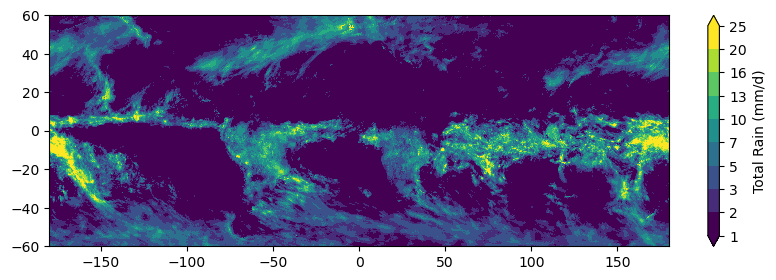

In [59]:
fig = plt.figure(figsize=[10,3], dpi=100)
# levels = np.arange(0,25.1,1)
levels = [1,2,3,5,7,10,13,16,20,25]
cmap = copy.copy(mpl.colormaps.get_cmap("viridis"))
# cmap = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(lon_lm, lat_lm, totpcp_obs_pyflex, norm=norm, cmap=cmap)
plt.colorbar(label='Total Rain (mm/d)', extend='both')
# pcm.cmap.set_over('magenta')
# pcm.cmap.set_under('white')

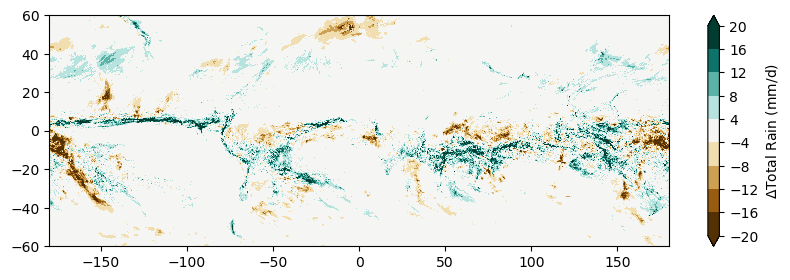

In [60]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = [-20,-16,-12,-8,-4,4,8,12,16,20]
cmap = mpl.colormaps.get_cmap('BrBG')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pcm = plt.pcolormesh(lon_lm, lat_lm, totpcp_diff_pyflex.sel(source='m2'), norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$Total Rain (mm/d)', extend='both')

In [61]:
# fig = plt.figure(figsize=[10,3], dpi=100)
# levels = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap = mpl.colormaps.get_cmap('BrBG')
# norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
# pcm = plt.pcolormesh(lon_lm, lat_lm, mcspcp_diff_dl.sel(source='m2'), norm=norm, cmap=cmap)
# plt.colorbar(label='$\Delta$MCS Rain (mm/d)', extend='both')

In [62]:
# fig = plt.figure(figsize=[10,3], dpi=100)
# levels = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap = mpl.colormaps.get_cmap('BrBG')
# norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
# pcm = plt.pcolormesh(lon_lm, lat_lm, mcspcp_diff_moaap.sel(source='m2'), norm=norm, cmap=cmap)
# plt.colorbar(label='$\Delta$MCS Rain (mm/d)', extend='both')

In [63]:
# fig = plt.figure(figsize=[10,3], dpi=100)
# levels = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap = mpl.colormaps.get_cmap('BrBG')
# norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
# pcm = plt.pcolormesh(lon, lat, mcspcp_diff.sel(source='m2'), norm=norm, cmap=cmap)
# plt.colorbar(label='$\Delta$MCS Rain (mm/d)', extend='both')

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


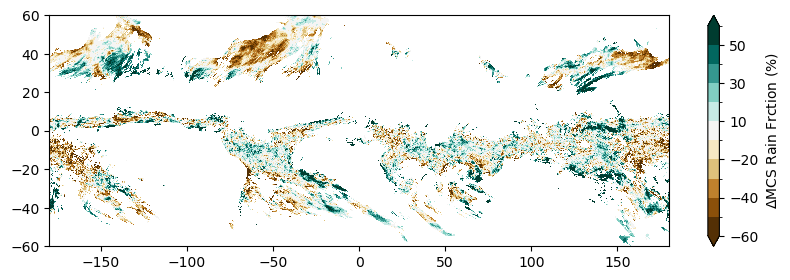

In [64]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = np.arange(-60, 60.1, 10)
levels = np.delete(levels, int((len(levels)-1)/2))
cmap = mpl.colormaps.get_cmap('BrBG')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pcm = plt.pcolormesh(lon_lm, lat_lm, mcspcpfrac_diff_pyflex.where(mcspcp_mod_pyflex > 1).sel(source='m2'), norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$MCS Rain Frction (%)', extend='both')

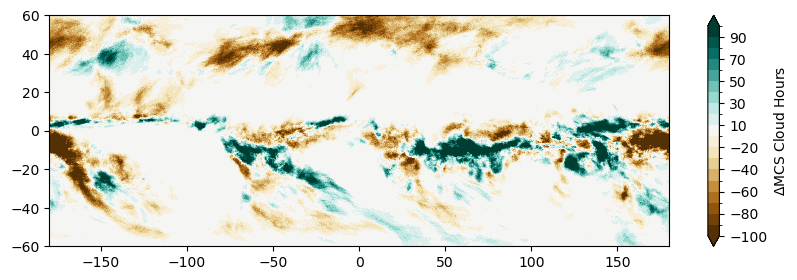

In [65]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = np.arange(-100, 100.1, 10)
levels = np.delete(levels, int((len(levels)-1)/2))
cmap = mpl.colormaps.get_cmap('BrBG')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pcm = plt.pcolormesh(lon_lm, lat_lm, mcscloudhours_diff_pyflex.sel(source='m2'), norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$MCS Cloud Hours', extend='both')

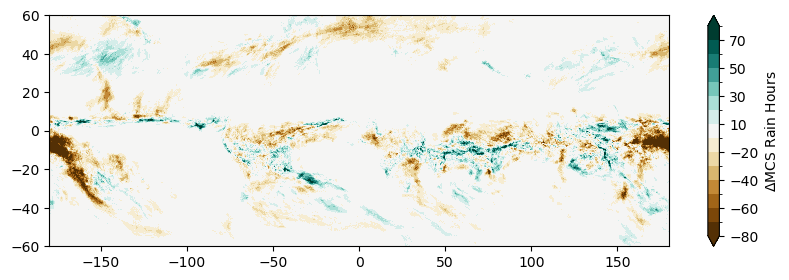

In [66]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = np.arange(-80, 80.1, 10)
levels = np.delete(levels, int((len(levels)-1)/2))
cmap = mpl.colormaps.get_cmap('BrBG')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pcm = plt.pcolormesh(lon_lm, lat_lm, mcspcphours_diff_pyflex.sel(source='m2'), norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$MCS Rain Hours', extend='both')

## Specify regional boundaries for calculating mean values

In [67]:
if PHASE == 'Winter':
    box_tropics = [-180, 180, -30, 12]
    boxes = {
        'Land':box_tropics,
        'Ocean':box_tropics,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))
    
    # Text location
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['Land'][3]+3,
        boxes['Ocean'][3]+3,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [68]:
if PHASE == 'Summer':
    box_tropics = [-180, 180, -12, 30]
    boxes = {
        'Land':box_tropics,
        'Ocean':box_tropics,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))
    
    # Text location
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['Land'][3]+3,
        boxes['Ocean'][3]+3,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [69]:
# name = 'Land'
# fig = plt.figure(figsize=(10,3),dpi=150)
# mcscloudfreq_l_mod_tams.sel(source='m3', lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3])).plot()
# # .sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)

In [70]:
# if PHASE == 'Winter':
#     box_mc = [95%360,150%360,-20,5]
#     box_itcz = [151%360,-110%360,0,12]
#     box_spcz = [151%360,-150%360,-30,-1]
#     box_io = [50%360,94%360,-15,5]
#     box_afc = [10%360,40%360,-20,5]
#     box_amz = [-75%360,-40%360,-20,0]
#     box_ao = [-40%360,-10%360,-8,8]
#     boxes = {'MC':box_mc, 
#              'ITCZ':box_itcz, 
#              'SPCZ':box_spcz, 
#              'IO':box_io, 
#              'AO':box_ao,
#              'AFC':box_afc, 
#              'AMZ':box_amz, 
#              }
#     region_names = dict(zip(boxes.keys(), boxes.keys()))
    
#     # Calculate regional mean difference
#     diff_reg = np.zeros(len(boxes), dtype=float)
#     text_loc_x = np.zeros(len(boxes), dtype=float)
#     for ii, name in enumerate(boxes):
#         text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
#     text_loc_y = [
#         boxes['MC'][3]+3,
#         boxes['ITCZ'][3]+3,
#         boxes['SPCZ'][2]-8, 
#         boxes['IO'][2]-8, 
#         boxes['AO'][3]+3,
#         boxes['AFC'][2]-8, 
#         boxes['AMZ'][2]-8, 
#     ]
#     text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
#     text_loc['SPCZ'] = text_loc['SPCZ'][0] + 20, text_loc['SPCZ'][1]

In [71]:
# if PHASE == 'Summer':
#     box_mc = [95,150,-20,5]
#     box_itcz = [-179,-70,5,18]
#     box_io = [50,94,-15,5]
#     box_wpac = [125,178,0,30]
#     box_sam = [70,125,5,40]
#     box_afc = [-15,40,-5,18]
#     box_amz = [-75,-40,-20,0]
#     box_ao = [-60,-15,5,18]
#     box_cus = [-105, -80, 30, 50]
#     box_ao180 = [-60,-15,5,18]
#     box_cus180 = [-105, -80, 30, 50]
#     boxes = {
#         'WP':box_wpac,
#         'ITCZ':box_itcz, 
#         'IO':box_io, 
#         'AO':box_ao,
#         'AFC':box_afc, 
#         'SAM':box_sam,
#         'CUS':box_cus,
#     }
#     region_names = dict(zip(boxes.keys(), boxes.keys()))
    
#     # Calculate regional mean difference
#     diff_reg = np.zeros(len(boxes), dtype=float)
#     text_loc_x = np.zeros(len(boxes), dtype=float)
#     for ii, name in enumerate(boxes):
#         text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
#     text_loc_y = [
#         boxes['WP'][3]+3,
#         boxes['ITCZ'][3]+3, 
#         boxes['IO'][2]-8, 
#         boxes['AO'][3]+3,
#         boxes['AFC'][2]-8, 
#         boxes['SAM'][3]+3,
#         boxes['CUS'][3]+3,
#     ]
#     text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [72]:
text_loc

{'Land': (0.0, 15), 'Ocean': (0.0, 15)}

## Function to calculate regional mean

In [73]:
def calc_regional_mean(da, boxes):
    """
    Calculate regional mean for all sources
    Args:
        da: DataArray
            Data Array containing dimensions (source, lat, lon)
        boxes: dictionary
            Dictionary containing region names and lat/lon bounds
        
    Returns:
        dict_out: dictionary
            Dictionary containing mean difference for each box.
    """
    # Get number of sources (-1)
    nsource = da.sizes['source']
    # Get number of boxes
    nbox = len(boxes)
    # Get source names (exclude first one 'obs')
    source_names = list(da.source.data[:])
    
    # Make arrays to store the differences
    mean_reg = np.zeros((nsource,nbox), dtype=float)
    text_loc_x = np.zeros((nsource,nbox), dtype=float)
    
    # Loop over each region
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
        
        # Select (subset) the region
        ida = da.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
        # Average over the region
        mean_reg[:,ii] = ida.mean(dim=('lat','lon'))
        
#         # Select non-obs sources, sum over the region
#         ida_mod = ida.isel(source=ida['source'] != 'obs').sum(dim=('lat','lon'))
#         # Select obs, sum over the region
#         ida_obs = ida.sel(source='obs').sum(dim=('lat','lon'))

#         # Calculate fractional difference
#         mean_reg[:,ii] = 100 * (ida_mod - ida_obs) / ida_obs
        
    # Put values in dictionary
    dict_out = dict(zip(source_names, mean_reg))
    # print(dict_out)
    
    return dict_out

In [74]:
name_map

{'obs': 'OBS',
 'm1': 'ARPEGE',
 'm2': 'IFS',
 'm3': 'MPAS',
 'm5': 'SAM',
 'm6': 'UM',
 'm7': 'GRIST',
 'm8': 'SCREAM',
 'm9': 'XSHiELD',
 'm10': 'GEOS',
 'm11': 'ICON',
 'm12': 'SCREAMv1',
 'mmm': 'All Models'}

## Ocean, Land separated

### PyFLEXTRKR

In [75]:
# Ocean
dict_mcspcpAvg_o_pyflex = calc_regional_mean(mcspcp_pyflex.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpAvg_o_pyflex)

dict_mcscloudfreqAvg_o_pyflex = calc_regional_mean(mcscloudfreq_pyflex.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreqAvg_o_pyflex)

dict_mcspcpfreqAvg_o_pyflex = calc_regional_mean(mcspcpfreq_pyflex.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreqAvg_o_pyflex)

# Land
dict_mcspcpAvg_l_pyflex = calc_regional_mean(mcspcp_pyflex.where(landmask <= land_thresh), boxes)
print(dict_mcspcpAvg_l_pyflex)

dict_mcscloudfreqAvg_l_pyflex = calc_regional_mean(mcscloudfreq_pyflex.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreqAvg_l_pyflex)

dict_mcspcpfreqAvg_l_pyflex = calc_regional_mean(mcspcpfreq_pyflex.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreqAvg_l_pyflex)

{'obs': array([2.80164909, 2.80164909]), 'm1': array([2.11371017, 2.11371017]), 'm2': array([2.27061844, 2.27061844]), 'm3': array([3.04916859, 3.04916859]), 'm5': array([2.18455935, 2.18455935]), 'm6': array([2.38401794, 2.38401794]), 'm7': array([1.53823555, 1.53823555]), 'm8': array([1.42207861, 1.42207861]), 'm9': array([2.30599952, 2.30599952]), 'm10': array([1.57801127, 1.57801127]), 'm11': array([1.44943559, 1.44943559]), 'm12': array([2.28241444, 2.28241444]), 'mmm': array([2.05106831, 2.05106831])}
{'obs': array([4.68769264, 4.68769264]), 'm1': array([4.16350937, 4.16350937]), 'm2': array([4.45322371, 4.45322371]), 'm3': array([15.26712799, 15.26712799]), 'm5': array([4.31349707, 4.31349707]), 'm6': array([4.39846373, 4.39846373]), 'm7': array([1.85946643, 1.85946643]), 'm8': array([2.30137372, 2.30137372]), 'm9': array([6.73250866, 6.73250866]), 'm10': array([3.17791271, 3.17791271]), 'm11': array([6.27989912, 6.27989912]), 'm12': array([5.34307146, 5.34307146]), 'mmm': array

### MOAAP

In [76]:
# Ocean
dict_mcspcpAvg_o_moaap = calc_regional_mean(mcspcp_moaap.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpAvg_o_moaap)

dict_mcscloudfreqAvg_o_moaap = calc_regional_mean(mcscloudfreq_moaap.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreqAvg_o_moaap)

dict_mcspcpfreqAvg_o_moaap = calc_regional_mean(mcspcpfreq_moaap.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreqAvg_o_moaap)

# Land
dict_mcspcpAvg_l_moaap = calc_regional_mean(mcspcp_moaap.where(landmask <= land_thresh), boxes)
print(dict_mcspcpAvg_l_moaap)

dict_mcscloudfreqAvg_l_moaap = calc_regional_mean(mcscloudfreq_moaap.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreqAvg_l_moaap)

dict_mcspcpfreqAvg_l_moaap = calc_regional_mean(mcspcpfreq_moaap.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreqAvg_l_moaap)

{'obs': array([2.07279444, 2.07279444]), 'm1': array([1.2201792, 1.2201792]), 'm2': array([1.49133873, 1.49133873]), 'm3': array([2.48246813, 2.48246813]), 'm5': array([1.04228199, 1.04228199]), 'm6': array([1.64989483, 1.64989483]), 'm7': array([0.26804996, 0.26804996]), 'm8': array([0.72255921, 0.72255921]), 'm9': array([1.46902704, 1.46902704]), 'm10': array([1.00194478, 1.00194478]), 'm11': array([0.78870851, 0.78870851]), 'm12': array([1.59405935, 1.59405935]), 'mmm': array([1.24746144, 1.24746144])}
{'obs': array([3.63042593, 3.63042593]), 'm1': array([2.91806865, 2.91806865]), 'm2': array([3.30142736, 3.30142736]), 'm3': array([11.86788654, 11.86788654]), 'm5': array([2.53549504, 2.53549504]), 'm6': array([3.58422923, 3.58422923]), 'm7': array([0.87918949, 0.87918949]), 'm8': array([1.36055624, 1.36055624]), 'm9': array([4.8237834, 4.8237834]), 'm10': array([2.26267958, 2.26267958]), 'm11': array([4.12392759, 4.12392759]), 'm12': array([3.74826002, 3.74826002]), 'mmm': array([3.

### TOOCAN

In [77]:
# Ocean
dict_mcspcpAvg_o_toocan = calc_regional_mean(mcspcp_toocan.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpAvg_o_toocan)

dict_mcscloudfreqAvg_o_toocan = calc_regional_mean(mcscloudfreq_toocan.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreqAvg_o_toocan)

dict_mcspcpfreqAvg_o_toocan = calc_regional_mean(mcspcpfreq_toocan.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreqAvg_o_toocan)

# Land
dict_mcspcpAvg_l_toocan = calc_regional_mean(mcspcp_toocan.where(landmask <= land_thresh), boxes)
print(dict_mcspcpAvg_l_toocan)

dict_mcscloudfreqAvg_l_toocan = calc_regional_mean(mcscloudfreq_toocan.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreqAvg_l_toocan)

dict_mcspcpfreqAvg_l_toocan = calc_regional_mean(mcspcpfreq_toocan.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreqAvg_l_toocan)

{'obs': array([1.64840698, 1.64840698]), 'm1': array([0.84328866, 0.84328866]), 'm2': array([1.18625081, 1.18625081]), 'm3': array([2.18657804, 2.18657804]), 'm5': array([0.59023803, 0.59023803]), 'm6': array([0.9227249, 0.9227249]), 'm7': array([0.29579782, 0.29579782]), 'm8': array([0.54222792, 0.54222792]), 'm9': array([1.11800599, 1.11800599]), 'm10': array([0.87615716, 0.87615716]), 'm11': array([0.30309212, 0.30309212]), 'm12': array([1.1297859, 1.1297859]), 'mmm': array([0.90848237, 0.90848237])}
{'obs': array([2.22617793, 2.22617793]), 'm1': array([1.47231019, 1.47231019]), 'm2': array([2.62050557, 2.62050557]), 'm3': array([8.50634766, 8.50634766]), 'm5': array([1.11729372, 1.11729372]), 'm6': array([1.4853636, 1.4853636]), 'm7': array([0.30322963, 0.30322963]), 'm8': array([0.77845156, 0.77845156]), 'm9': array([2.4849143, 2.4849143]), 'm10': array([1.62205255, 1.62205255]), 'm11': array([1.09257674, 1.09257674]), 'm12': array([2.38842535, 2.38842535]), 'mmm': array([2.168403

### tobac

In [78]:
# Ocean
dict_mcspcpAvg_o_tobac = calc_regional_mean(mcspcp_tobac.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpAvg_o_tobac)

dict_mcscloudfreqAvg_o_tobac = calc_regional_mean(mcscloudfreq_tobac.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreqAvg_o_tobac)

dict_mcspcpfreqAvg_o_tobac = calc_regional_mean(mcspcpfreq_tobac.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreqAvg_o_tobac)

# Land
dict_mcspcpAvg_l_tobac = calc_regional_mean(mcspcp_tobac.where(landmask <= land_thresh), boxes)
print(dict_mcspcpAvg_l_tobac)

dict_mcscloudfreqAvg_l_tobac = calc_regional_mean(mcscloudfreq_tobac.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreqAvg_l_tobac)

dict_mcspcpfreqAvg_l_tobac = calc_regional_mean(mcspcpfreq_tobac.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreqAvg_l_tobac)

{'obs': array([1.61589515, 1.61589515]), 'm1': array([1.05877364, 1.05877364]), 'm2': array([1.27976346, 1.27976346]), 'm3': array([1.32590938, 1.32590938]), 'm5': array([0.84637451, 0.84637451]), 'm6': array([1.43429232, 1.43429232]), 'm7': array([0.57166475, 0.57166475]), 'm8': array([0.7606706, 0.7606706]), 'm9': array([1.21731436, 1.21731436]), 'm10': array([0.95341438, 0.95341438]), 'm11': array([0.76014751, 0.76014751]), 'm12': array([1.13299847, 1.13299847]), 'mmm': array([1.03080344, 1.03080344])}
{'obs': array([2.24677992, 2.24677992]), 'm1': array([2.11465454, 2.11465454]), 'm2': array([2.79420638, 2.79420638]), 'm3': array([6.70635748, 6.70635748]), 'm5': array([1.92544627, 1.92544627]), 'm6': array([2.50021172, 2.50021172]), 'm7': array([0.77658194, 0.77658194]), 'm8': array([1.33153331, 1.33153331]), 'm9': array([3.23515821, 3.23515821]), 'm10': array([1.86827409, 1.86827409]), 'm11': array([3.50367212, 3.50367212]), 'm12': array([2.62576199, 2.62576199]), 'mmm': array([2.

### TAMS

In [79]:
# Ocean
dict_mcspcpAvg_o_tams = calc_regional_mean(mcspcp_tams.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpAvg_o_tams)

dict_mcscloudfreqAvg_o_tams = calc_regional_mean(mcscloudfreq_tams.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreqAvg_o_tams)

dict_mcspcpfreqAvg_o_tams = calc_regional_mean(mcspcpfreq_tams.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreqAvg_o_tams)

# Land
dict_mcspcpAvg_l_tams = calc_regional_mean(mcspcp_tams.where(landmask <= land_thresh), boxes)
print(dict_mcspcpAvg_l_tams)

dict_mcscloudfreqAvg_l_tams = calc_regional_mean(mcscloudfreq_tams.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreqAvg_l_tams)

dict_mcspcpfreqAvg_l_tams = calc_regional_mean(mcspcpfreq_tams.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreqAvg_l_tams)

{'obs': array([2.7416451, 2.7416451]), 'm1': array([1.88698864, 1.88698864]), 'm2': array([1.85187984, 1.85187984]), 'm3': array([3.1367991, 3.1367991]), 'm5': array([1.68026888, 1.68026888]), 'm6': array([2.26887512, 2.26887512]), 'm7': array([1.06904066, 1.06904066]), 'm8': array([1.21362484, 1.21362484]), 'm9': array([2.41320705, 2.41320705]), 'm10': array([1.4505496, 1.4505496]), 'm11': array([1.58949399, 1.58949399]), 'm12': array([2.04120421, 2.04120421]), 'mmm': array([1.87160909, 1.87160909])}
{'obs': array([6.9353981, 6.9353981]), 'm1': array([5.93688393, 5.93688393]), 'm2': array([5.50211573, 5.50211573]), 'm3': array([27.53903961, 27.53903961]), 'm5': array([6.1123209, 6.1123209]), 'm6': array([6.49548721, 6.49548721]), 'm7': array([2.01284194, 2.01284194]), 'm8': array([2.80263495, 2.80263495]), 'm9': array([11.55380821, 11.55380821]), 'm10': array([4.36615992, 4.36615992]), 'm11': array([11.3194685, 11.3194685]), 'm12': array([7.82433081, 7.82433081]), 'mmm': array([8.3026

### SimpleTrack

In [80]:
# Ocean
dict_mcspcpAvg_o_simtrack = calc_regional_mean(mcspcp_simtrack.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpAvg_o_simtrack)

dict_mcscloudfreqAvg_o_simtrack = calc_regional_mean(mcscloudfreq_simtrack.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreqAvg_o_simtrack)

dict_mcspcpfreqAvg_o_simtrack = calc_regional_mean(mcspcpfreq_simtrack.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreqAvg_o_simtrack)

# Land
dict_mcspcpAvg_l_simtrack = calc_regional_mean(mcspcp_simtrack.where(landmask <= land_thresh), boxes)
print(dict_mcspcpAvg_l_simtrack)

dict_mcscloudfreqAvg_l_simtrack = calc_regional_mean(mcscloudfreq_simtrack.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreqAvg_l_simtrack)

dict_mcspcpfreqAvg_l_simtrack = calc_regional_mean(mcspcpfreq_simtrack.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreqAvg_l_simtrack)

{'obs': array([2.49205542, 2.49205542]), 'm1': array([1.58684182, 1.58684182]), 'm2': array([1.76588011, 1.76588011]), 'm3': array([1.57560968, 1.57560968]), 'm5': array([1.16837084, 1.16837084]), 'm6': array([2.02557278, 2.02557278]), 'm7': array([0.86055315, 0.86055315]), 'm8': array([1.09538043, 1.09538043]), 'm9': array([1.60087371, 1.60087371]), 'm10': array([1.34077442, 1.34077442]), 'm11': array([1.18902314, 1.18902314]), 'm12': array([1.51907516, 1.51907516]), 'mmm': array([1.42954922, 1.42954922])}
{'obs': array([4.31617451, 4.31617451]), 'm1': array([3.58649731, 3.58649731]), 'm2': array([3.94885826, 3.94885826]), 'm3': array([8.64424896, 8.64424896]), 'm5': array([3.19011521, 3.19011521]), 'm6': array([4.06308365, 4.06308365]), 'm7': array([1.31200242, 1.31200242]), 'm8': array([1.9913826, 1.9913826]), 'm9': array([5.29087162, 5.29087162]), 'm10': array([2.91914248, 2.91914248]), 'm11': array([5.82544184, 5.82544184]), 'm12': array([4.08664751, 4.08664751]), 'mmm': array([4.

## DL

In [81]:
# Ocean
dict_mcspcpAvg_o_dl = calc_regional_mean(mcspcp_dl.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpAvg_o_dl)

dict_mcscloudfreqAvg_o_dl = calc_regional_mean(mcscloudfreq_dl.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreqAvg_o_dl)

dict_mcspcpfreqAvg_o_dl = calc_regional_mean(mcspcpfreq_dl.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreqAvg_o_dl)

# Land
dict_mcspcpAvg_l_dl = calc_regional_mean(mcspcp_dl.where(landmask <= land_thresh), boxes)
print(dict_mcspcpAvg_l_dl)

dict_mcscloudfreqAvg_l_dl = calc_regional_mean(mcscloudfreq_dl.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreqAvg_l_dl)

dict_mcspcpfreqAvg_l_dl = calc_regional_mean(mcspcpfreq_dl.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreqAvg_l_dl)

{'obs': array([2.66874337, 2.66874337]), 'm1': array([1.94010437, 1.94010437]), 'm2': array([1.97789609, 1.97789609]), 'm3': array([2.94234276, 2.94234276]), 'm5': array([1.69336522, 1.69336522]), 'm6': array([2.16665578, 2.16665578]), 'm7': array([1.10276687, 1.10276687]), 'm8': array([1.29467475, 1.29467475]), 'm9': array([2.23375607, 2.23375607]), 'm10': array([1.53295493, 1.53295493]), 'm11': array([1.41190422, 1.41190422]), 'm12': array([2.17125082, 2.17125082]), 'mmm': array([1.85968721, 1.85968721])}
{'obs': array([5.97548866, 5.97548866]), 'm1': array([5.73515177, 5.73515177]), 'm2': array([5.36069059, 5.36069059]), 'm3': array([17.92465782, 17.92465782]), 'm5': array([5.75082922, 5.75082922]), 'm6': array([5.35535288, 5.35535288]), 'm7': array([2.18316245, 2.18316245]), 'm8': array([2.97364235, 2.97364235]), 'm9': array([8.63555527, 8.63555527]), 'm10': array([4.12085819, 4.12085819]), 'm11': array([7.74036455, 7.74036455]), 'm12': array([7.06563902, 7.06563902]), 'mmm': array

## KFyAO

In [82]:
# Ocean
dict_mcspcpAvg_o_kfyao = calc_regional_mean(mcspcp_kfyao.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpAvg_o_kfyao)

dict_mcscloudfreqAvg_o_kfyao = calc_regional_mean(mcscloudfreq_kfyao.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreqAvg_o_kfyao)

dict_mcspcpfreqAvg_o_kfyao = calc_regional_mean(mcspcpfreq_kfyao.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreqAvg_o_kfyao)

# Land
dict_mcspcpAvg_l_kfyao = calc_regional_mean(mcspcp_kfyao.where(landmask <= land_thresh), boxes)
print(dict_mcspcpAvg_l_kfyao)

dict_mcscloudfreqAvg_l_kfyao = calc_regional_mean(mcscloudfreq_kfyao.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreqAvg_l_kfyao)

dict_mcspcpfreqAvg_l_kfyao = calc_regional_mean(mcspcpfreq_kfyao.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreqAvg_l_kfyao)

{'obs': array([2.39887977, 2.39887977]), 'm1': array([1.49139535, 1.49139535]), 'm2': array([1.57989454, 1.57989454]), 'm3': array([2.66883373, 2.66883373]), 'm5': array([1.2480514, 1.2480514]), 'm6': array([1.84540784, 1.84540784]), 'm7': array([0.72021836, 0.72021836]), 'm8': array([1.01018846, 1.01018846]), 'm9': array([1.91399825, 1.91399825]), 'm10': array([1.26267409, 1.26267409]), 'm11': array([0.22690697, 0.22690697]), 'm12': array([1.78341389, 1.78341389]), 'mmm': array([1.43142509, 1.43142509])}
{'obs': array([4.21191406, 4.21191406]), 'm1': array([3.37516356, 3.37516356]), 'm2': array([3.55673862, 3.55673862]), 'm3': array([14.48119164, 14.48119164]), 'm5': array([3.39223361, 3.39223361]), 'm6': array([3.80664229, 3.80664229]), 'm7': array([1.13941669, 1.13941669]), 'm8': array([1.79937255, 1.79937255]), 'm9': array([6.24603033, 6.24603033]), 'm10': array([2.74345684, 2.74345684]), 'm11': array([1.1446377, 1.1446377]), 'm12': array([4.55737019, 4.55737019]), 'mmm': array([4.

## Function to calculate regional mean percentage difference

In [83]:
def calc_regional_diff_percent(da, boxes):
    """
    Calculate regional mean percentage difference
    Args:
        da: DataArray
            Data Array containing dimensions (source, lat, lon)
        boxes: dictionary
            Dictionary containing region names and lat/lon bounds
        
    Returns:
        dict_out: dictionary
            Dictionary containing mean difference for each box.
    """
    # Get number of sources (-1)
    nsource = da.sizes['source']-1
    # Get number of boxes
    nbox = len(boxes)
    # Get source names (exclude first one 'obs')
    source_names = list(da.source.data[1:])
    
    # Make arrays to store the differences
    diff_reg = np.zeros((nsource,nbox), dtype=float)
    text_loc_x = np.zeros((nsource,nbox), dtype=float)
    
    # Loop over each region
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
        
        # Select (subset) the region
        ida = da.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)        
        # Select non-obs sources, sum over the region
        ida_mod = ida.isel(source=ida['source'] != 'obs').sum(dim=('lat','lon'))
        # Select obs, sum over the region
        ida_obs = ida.sel(source='obs').sum(dim=('lat','lon'))

        # Calculate fractional difference
        diff_reg[:,ii] = 100 * (ida_mod - ida_obs) / ida_obs
        
    # Put values in dictionary
    dict_out = dict(zip(source_names, diff_reg))
    # print(dict_out)
    
    return dict_out

In [84]:
# mcscloudhours_diff.sel(source='m3').where(landmask >= ocean_thresh).plot()

## Ocean & Land

### PyFLEXTRKR

In [85]:
# dict_totpcp_pyflex = calc_regional_diff_percent(totpcp_pyflex, boxes)
# print(dict_totpcp_pyflex)

# dict_mcspcp_pyflex = calc_regional_diff_percent(mcspcp_pyflex, boxes)
# print(dict_mcspcp_pyflex)

# dict_mcscloudfreq_pyflex = calc_regional_diff_percent(mcscloudfreq_pyflex, boxes)
# print(dict_mcscloudfreq_pyflex)

# dict_mcspcpfreq_pyflex = calc_regional_diff_percent(mcspcpfreq_pyflex, boxes)
# print(dict_mcspcpfreq_pyflex)

### MOAAP

In [86]:
# dict_totpcp_moaap = calc_regional_diff_percent(totpcp_moaap, boxes)
# print(dict_totpcp_moaap)

# dict_mcspcp_moaap = calc_regional_diff_percent(mcspcp_moaap, boxes)
# print(dict_mcspcp_moaap)

# dict_mcscloudfreq_moaap = calc_regional_diff_percent(mcscloudfreq_moaap, boxes)
# print(dict_mcscloudfreq_moaap)

# dict_mcspcpfreq_moaap = calc_regional_diff_percent(mcspcpfreq_moaap, boxes)
# print(dict_mcspcpfreq_moaap)

## Ocean, Land separated

### PyFLEXTRKR

In [87]:
# Ocean
dict_totpcp_o_pyflex = calc_regional_diff_percent(totpcp_pyflex.where(landmask >= ocean_thresh), boxes)
print(dict_totpcp_o_pyflex)

dict_mcspcp_o_pyflex = calc_regional_diff_percent(mcspcp_pyflex.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcp_o_pyflex)

dict_mcscloudfreq_o_pyflex = calc_regional_diff_percent(mcscloudfreq_pyflex.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreq_o_pyflex)

dict_mcspcpfreq_o_pyflex = calc_regional_diff_percent(mcspcpfreq_pyflex.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreq_o_pyflex)

# Land
dict_totpcp_l_pyflex = calc_regional_diff_percent(totpcp_pyflex.where(landmask <= land_thresh), boxes)
print(dict_totpcp_l_pyflex)

dict_mcspcp_l_pyflex = calc_regional_diff_percent(mcspcp_pyflex.where(landmask <= land_thresh), boxes)
print(dict_mcspcp_l_pyflex)

dict_mcscloudfreq_l_pyflex = calc_regional_diff_percent(mcscloudfreq_pyflex.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreq_l_pyflex)

dict_mcspcpfreq_l_pyflex = calc_regional_diff_percent(mcspcpfreq_pyflex.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreq_l_pyflex)

{'m1': array([1.46381056, 1.46381056]), 'm2': array([8.49660301, 8.49660301]), 'm3': array([-13.36811733, -13.36811733]), 'm5': array([22.33462715, 22.33462715]), 'm6': array([14.39034462, 14.39034462]), 'm7': array([26.08804512, 26.08804512]), 'm8': array([21.40159607, 21.40159607]), 'm9': array([14.59757423, 14.59757423]), 'm10': array([-4.98040485, -4.98040485]), 'm11': array([-5.10949183, -5.10949183]), 'm12': array([3.24922633, 3.24922633]), 'mmm': array([8.0099678, 8.0099678])}
{'m1': array([-24.55478287, -24.55478287]), 'm2': array([-18.9542141, -18.9542141]), 'm3': array([8.83477974, 8.83477974]), 'm5': array([-22.02594566, -22.02594566]), 'm6': array([-14.90662193, -14.90662193]), 'm7': array([-45.09535217, -45.09535217]), 'm8': array([-49.24137497, -49.24137497]), 'm9': array([-17.69135284, -17.69135284]), 'm10': array([-43.67562866, -43.67562866]), 'm11': array([-48.26491547, -48.26491547]), 'm12': array([-18.53318405, -18.53318405]), 'mmm': array([-26.79068184, -26.79068184

### MOAAP

In [88]:
# Ocean
dict_totpcp_o_moaap = calc_regional_diff_percent(totpcp_moaap.where(landmask >= ocean_thresh), boxes)
print(dict_totpcp_o_moaap)

dict_mcspcp_o_moaap = calc_regional_diff_percent(mcspcp_moaap.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcp_o_moaap)

dict_mcscloudfreq_o_moaap = calc_regional_diff_percent(mcscloudfreq_moaap.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreq_o_moaap)

dict_mcspcpfreq_o_moaap = calc_regional_diff_percent(mcspcpfreq_moaap.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreq_o_moaap)

# Land
dict_totpcp_l_moaap = calc_regional_diff_percent(totpcp_moaap.where(landmask <= land_thresh), boxes)
print(dict_totpcp_l_moaap)

dict_mcspcp_l_moaap = calc_regional_diff_percent(mcspcp_moaap.where(landmask <= land_thresh), boxes)
print(dict_mcspcp_l_moaap)

dict_mcscloudfreq_l_moaap = calc_regional_diff_percent(mcscloudfreq_moaap.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreq_l_moaap)

dict_mcspcpfreq_l_moaap = calc_regional_diff_percent(mcspcpfreq_moaap.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreq_l_moaap)

{'m1': array([1.46381056, 1.46381056]), 'm2': array([8.49660301, 8.49660301]), 'm3': array([-13.36811733, -13.36811733]), 'm5': array([22.33462715, 22.33462715]), 'm6': array([14.39034462, 14.39034462]), 'm7': array([26.08804512, 26.08804512]), 'm8': array([21.40159607, 21.40159607]), 'm9': array([14.59757423, 14.59757423]), 'm10': array([-4.98040485, -4.98040485]), 'm11': array([-5.10949183, -5.10949183]), 'm12': array([3.24922633, 3.24922633]), 'mmm': array([8.0099678, 8.0099678])}
{'m1': array([-41.1336174, -41.1336174]), 'm2': array([-28.05178452, -28.05178452]), 'm3': array([19.76431084, 19.76431084]), 'm5': array([-49.71609497, -49.71609497]), 'm6': array([-20.40239525, -20.40239525]), 'm7': array([-87.0681839, -87.0681839]), 'm8': array([-65.14081573, -65.14081573]), 'm9': array([-29.12819099, -29.12819099]), 'm10': array([-51.66212845, -51.66212845]), 'm11': array([-61.94950485, -61.94950485]), 'm12': array([-23.09612465, -23.09612465]), 'mmm': array([-39.81741333, -39.81741333

### TOOCAN

In [89]:
# Ocean
dict_totpcp_o_toocan = calc_regional_diff_percent(totpcp_toocan.where(landmask >= ocean_thresh), boxes)
print(dict_totpcp_o_toocan)

dict_mcspcp_o_toocan = calc_regional_diff_percent(mcspcp_toocan.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcp_o_toocan)

dict_mcscloudfreq_o_toocan = calc_regional_diff_percent(mcscloudfreq_toocan.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreq_o_toocan)

dict_mcspcpfreq_o_toocan = calc_regional_diff_percent(mcspcpfreq_toocan.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreq_o_toocan)

# Land
dict_totpcp_l_toocan = calc_regional_diff_percent(totpcp_toocan.where(landmask <= land_thresh), boxes)
print(dict_totpcp_l_toocan)

dict_mcspcp_l_toocan = calc_regional_diff_percent(mcspcp_toocan.where(landmask <= land_thresh), boxes)
print(dict_mcspcp_l_toocan)

dict_mcscloudfreq_l_toocan = calc_regional_diff_percent(mcscloudfreq_toocan.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreq_l_toocan)

dict_mcspcpfreq_l_toocan = calc_regional_diff_percent(mcspcpfreq_toocan.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreq_l_toocan)

{'m1': array([1.47160459, 1.47160459]), 'm2': array([8.50079441, 8.50079441]), 'm3': array([-13.36811733, -13.36811733]), 'm5': array([22.33462715, 22.33462715]), 'm6': array([14.39036655, 14.39036655]), 'm7': array([26.08804512, 26.08804512]), 'm8': array([21.40161705, 21.40161705]), 'm9': array([14.59757423, 14.59757423]), 'm10': array([-4.98039436, -4.98039436]), 'm11': array([-5.10949183, -5.10949183]), 'm12': array([3.24922633, 3.24922633]), 'mmm': array([8.01109028, 8.01109028])}
{'m1': array([-48.84220505, -48.84220505]), 'm2': array([-28.03653336, -28.03653336]), 'm3': array([32.64795303, 32.64795303]), 'm5': array([-64.19343567, -64.19343567]), 'm6': array([-44.02323532, -44.02323532]), 'm7': array([-82.05553436, -82.05553436]), 'm8': array([-67.10594177, -67.10594177]), 'm9': array([-32.17658234, -32.17658234]), 'm10': array([-46.84824753, -46.84824753]), 'm11': array([-81.61302948, -81.61302948]), 'm12': array([-31.46195793, -31.46195793]), 'mmm': array([-44.88725281, -44.88

## tobac

In [90]:
# Ocean
dict_totpcp_o_tobac = calc_regional_diff_percent(totpcp_tobac.where(landmask >= ocean_thresh), boxes)
print(dict_totpcp_o_tobac)

dict_mcspcp_o_tobac = calc_regional_diff_percent(mcspcp_tobac.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcp_o_tobac)

dict_mcscloudfreq_o_tobac = calc_regional_diff_percent(mcscloudfreq_tobac.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreq_o_tobac)

dict_mcspcpfreq_o_tobac = calc_regional_diff_percent(mcspcpfreq_tobac.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreq_o_tobac)

# Land
dict_totpcp_l_tobac = calc_regional_diff_percent(totpcp_tobac.where(landmask <= land_thresh), boxes)
print(dict_totpcp_l_tobac)

dict_mcspcp_l_tobac = calc_regional_diff_percent(mcspcp_tobac.where(landmask <= land_thresh), boxes)
print(dict_mcspcp_l_tobac)

dict_mcscloudfreq_l_tobac = calc_regional_diff_percent(mcscloudfreq_tobac.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreq_l_tobac)

dict_mcspcpfreq_l_tobac = calc_regional_diff_percent(mcspcpfreq_tobac.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreq_l_tobac)

{'m1': array([1.46381056, 1.46381056]), 'm2': array([8.49660301, 8.49660301]), 'm3': array([-13.36811733, -13.36811733]), 'm5': array([22.33462715, 22.33462715]), 'm6': array([14.39034462, 14.39034462]), 'm7': array([26.08804512, 26.08804512]), 'm8': array([21.40159607, 21.40159607]), 'm9': array([14.59757423, 14.59757423]), 'm10': array([-4.98040485, -4.98040485]), 'm11': array([-5.10949183, -5.10949183]), 'm12': array([3.24922633, 3.24922633]), 'mmm': array([8.0099678, 8.0099678])}
{'m1': array([-34.47758102, -34.47758102]), 'm2': array([-20.80158234, -20.80158234]), 'm3': array([-17.94583511, -17.94583511]), 'm5': array([-47.62194443, -47.62194443]), 'm6': array([-11.23853111, -11.23853111]), 'm7': array([-64.62241364, -64.62241364]), 'm8': array([-52.92574692, -52.92574692]), 'm9': array([-24.66625595, -24.66625595]), 'm10': array([-40.99775696, -40.99775696]), 'm11': array([-52.95811844, -52.95811844]), 'm12': array([-29.88416481, -29.88416481]), 'mmm': array([-36.20851898, -36.20

## TAMS

In [91]:
# Ocean
dict_totpcp_o_tams = calc_regional_diff_percent(totpcp_tams.where(landmask >= ocean_thresh), boxes)
print(dict_totpcp_o_tams)

dict_mcspcp_o_tams = calc_regional_diff_percent(mcspcp_tams.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcp_o_tams)

dict_mcscloudfreq_o_tams = calc_regional_diff_percent(mcscloudfreq_tams.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreq_o_tams)

dict_mcspcpfreq_o_tams = calc_regional_diff_percent(mcspcpfreq_tams.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreq_o_tams)

# Land
dict_totpcp_l_tams = calc_regional_diff_percent(totpcp_tams.where(landmask <= land_thresh), boxes)
print(dict_totpcp_l_tams)

dict_mcspcp_l_tams = calc_regional_diff_percent(mcspcp_tams.where(landmask <= land_thresh), boxes)
print(dict_mcspcp_l_tams)

dict_mcscloudfreq_l_tams = calc_regional_diff_percent(mcscloudfreq_tams.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreq_l_tams)

dict_mcspcpfreq_l_tams = calc_regional_diff_percent(mcspcpfreq_tams.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreq_l_tams)

{'m1': array([1.46381056, 1.46381056]), 'm2': array([8.49660301, 8.49660301]), 'm3': array([-13.36811733, -13.36811733]), 'm5': array([22.33462715, 22.33462715]), 'm6': array([14.39034462, 14.39034462]), 'm7': array([26.08804512, 26.08804512]), 'm8': array([21.40159607, 21.40159607]), 'm9': array([14.59757423, 14.59757423]), 'm10': array([-4.98040485, -4.98040485]), 'm11': array([-5.10949183, -5.10949183]), 'm12': array([3.24922633, 3.24922633]), 'mmm': array([8.0099678, 8.0099678])}
{'m1': array([-31.17312622, -31.17312622]), 'm2': array([-32.45370102, -32.45370102]), 'm3': array([14.41302013, 14.41302013]), 'm5': array([-38.71311951, -38.71311951]), 'm6': array([-17.24403, -17.24403]), 'm7': array([-61.00732803, -61.00732803]), 'm8': array([-55.7336998, -55.7336998]), 'm9': array([-11.979599, -11.979599]), 'm10': array([-47.09199905, -47.09199905]), 'm11': array([-42.02408218, -42.02408218]), 'm12': array([-25.54819679, -25.54819679]), 'mmm': array([-31.7340889, -31.7340889])}
{'m1':

## simpleTrack

In [92]:
# Ocean
dict_totpcp_o_simtrack = calc_regional_diff_percent(totpcp_simtrack.where(landmask >= ocean_thresh), boxes)
print(dict_totpcp_o_simtrack)

dict_mcspcp_o_simtrack = calc_regional_diff_percent(mcspcp_simtrack.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcp_o_simtrack)

dict_mcscloudfreq_o_simtrack = calc_regional_diff_percent(mcscloudfreq_simtrack.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreq_o_simtrack)

dict_mcspcpfreq_o_simtrack = calc_regional_diff_percent(mcspcpfreq_simtrack.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreq_o_simtrack)

# Land
dict_totpcp_l_simtrack = calc_regional_diff_percent(totpcp_simtrack.where(landmask <= land_thresh), boxes)
print(dict_totpcp_l_simtrack)

dict_mcspcp_l_simtrack = calc_regional_diff_percent(mcspcp_simtrack.where(landmask <= land_thresh), boxes)
print(dict_mcspcp_l_simtrack)

dict_mcscloudfreq_l_simtrack = calc_regional_diff_percent(mcscloudfreq_simtrack.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreq_l_simtrack)

dict_mcspcpfreq_l_simtrack = calc_regional_diff_percent(mcspcpfreq_simtrack.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreq_l_simtrack)

{'m1': array([1.46381056, 1.46381056]), 'm2': array([8.49660301, 8.49660301]), 'm3': array([-13.36811733, -13.36811733]), 'm5': array([22.33462715, 22.33462715]), 'm6': array([14.39034462, 14.39034462]), 'm7': array([26.08804512, 26.08804512]), 'm8': array([21.40159607, 21.40159607]), 'm9': array([14.59757423, 14.59757423]), 'm10': array([-4.98040485, -4.98040485]), 'm11': array([-5.10949183, -5.10949183]), 'm12': array([3.24922633, 3.24922633]), 'mmm': array([8.0099678, 8.0099678])}
{'m1': array([-36.32397461, -36.32397461]), 'm2': array([-29.13961411, -29.13961411]), 'm3': array([-36.77469254, -36.77469254]), 'm5': array([-53.11617661, -53.11617661]), 'm6': array([-18.71878624, -18.71878624]), 'm7': array([-65.46813965, -65.46813965]), 'm8': array([-56.04510117, -56.04510117]), 'm9': array([-35.76091003, -35.76091003]), 'm10': array([-46.19805145, -46.19805145]), 'm11': array([-52.28744888, -52.28744888]), 'm12': array([-39.04328537, -39.04328537]), 'mmm': array([-42.63573837, -42.63

## DL

In [93]:
# Ocean
dict_totpcp_o_dl = calc_regional_diff_percent(totpcp_dl.where(landmask >= ocean_thresh), boxes)
print(dict_totpcp_o_dl)

dict_mcspcp_o_dl = calc_regional_diff_percent(mcspcp_dl.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcp_o_dl)

dict_mcscloudfreq_o_dl = calc_regional_diff_percent(mcscloudfreq_dl.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreq_o_dl)

dict_mcspcpfreq_o_dl = calc_regional_diff_percent(mcspcpfreq_dl.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreq_o_dl)

# Land
dict_totpcp_l_dl = calc_regional_diff_percent(totpcp_dl.where(landmask <= land_thresh), boxes)
print(dict_totpcp_l_dl)

dict_mcspcp_l_dl = calc_regional_diff_percent(mcspcp_dl.where(landmask <= land_thresh), boxes)
print(dict_mcspcp_l_dl)

dict_mcscloudfreq_l_dl = calc_regional_diff_percent(mcscloudfreq_dl.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreq_l_dl)

dict_mcspcpfreq_l_dl = calc_regional_diff_percent(mcspcpfreq_dl.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreq_l_dl)

{'m1': array([1.46381056, 1.46381056]), 'm2': array([8.49660301, 8.49660301]), 'm3': array([-13.36811733, -13.36811733]), 'm5': array([22.33462715, 22.33462715]), 'm6': array([14.39034462, 14.39034462]), 'm7': array([26.08804512, 26.08804512]), 'm8': array([21.40159607, 21.40159607]), 'm9': array([14.59757423, 14.59757423]), 'm10': array([-4.98040485, -4.98040485]), 'm11': array([-5.10949183, -5.10949183]), 'm12': array([3.24922633, 3.24922633]), 'mmm': array([8.0099678, 8.0099678])}
{'m1': array([-27.30269623, -27.30269623]), 'm2': array([-25.88661194, -25.88661194]), 'm3': array([10.25199986, 10.25199986]), 'm5': array([-36.54821777, -36.54821777]), 'm6': array([-18.81363487, -18.81363487]), 'm7': array([-58.67842484, -58.67842484]), 'm8': array([-51.48747253, -51.48747253]), 'm9': array([-16.29932404, -16.29932404]), 'm10': array([-42.55892181, -42.55892181]), 'm11': array([-47.0947876, -47.0947876]), 'm12': array([-18.64145088, -18.64145088]), 'mmm': array([-30.31599236, -30.315992

## KFyAO

In [94]:
# Ocean
dict_totpcp_o_kfyao = calc_regional_diff_percent(totpcp_kfyao.where(landmask >= ocean_thresh), boxes)
print(dict_totpcp_o_kfyao)

dict_mcspcp_o_kfyao = calc_regional_diff_percent(mcspcp_kfyao.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcp_o_kfyao)

dict_mcscloudfreq_o_kfyao = calc_regional_diff_percent(mcscloudfreq_kfyao.where(landmask >= ocean_thresh), boxes)
print(dict_mcscloudfreq_o_kfyao)

dict_mcspcpfreq_o_kfyao = calc_regional_diff_percent(mcspcpfreq_kfyao.where(landmask >= ocean_thresh), boxes)
print(dict_mcspcpfreq_o_kfyao)

# Land
dict_totpcp_l_kfyao = calc_regional_diff_percent(totpcp_kfyao.where(landmask <= land_thresh), boxes)
print(dict_totpcp_l_kfyao)

dict_mcspcp_l_kfyao = calc_regional_diff_percent(mcspcp_kfyao.where(landmask <= land_thresh), boxes)
print(dict_mcspcp_l_kfyao)

dict_mcscloudfreq_l_kfyao = calc_regional_diff_percent(mcscloudfreq_kfyao.where(landmask <= land_thresh), boxes)
print(dict_mcscloudfreq_l_kfyao)

dict_mcspcpfreq_l_kfyao = calc_regional_diff_percent(mcspcpfreq_kfyao.where(landmask <= land_thresh), boxes)
print(dict_mcspcpfreq_l_kfyao)

{'m1': array([1.46381056, 1.46381056]), 'm2': array([8.49660301, 8.49660301]), 'm3': array([-13.36811733, -13.36811733]), 'm5': array([22.33462715, 22.33462715]), 'm6': array([14.39034462, 14.39034462]), 'm7': array([26.08804512, 26.08804512]), 'm8': array([21.40159607, 21.40159607]), 'm9': array([14.59757423, 14.59757423]), 'm10': array([-4.98040485, -4.98040485]), 'm11': array([-5.10949183, -5.10949183]), 'm12': array([3.24922633, 3.24922633]), 'mmm': array([8.0099678, 8.0099678])}
{'m1': array([-37.82950211, -37.82950211]), 'm2': array([-34.14031601, -34.14031601]), 'm3': array([11.25333309, 11.25333309]), 'm5': array([-47.97357178, -47.97357178]), 'm6': array([-23.07209587, -23.07209587]), 'm7': array([-69.97689056, -69.97689056]), 'm8': array([-57.88915634, -57.88915634]), 'm9': array([-20.21282959, -20.21282959]), 'm10': array([-47.36400604, -47.36400604]), 'm11': array([-90.54113007, -90.54113007]), 'm12': array([-25.65638351, -25.65638351]), 'mmm': array([-40.32943726, -40.3294

In [95]:
name_map

{'obs': 'OBS',
 'm1': 'ARPEGE',
 'm2': 'IFS',
 'm3': 'MPAS',
 'm5': 'SAM',
 'm6': 'UM',
 'm7': 'GRIST',
 'm8': 'SCREAM',
 'm9': 'XSHiELD',
 'm10': 'GEOS',
 'm11': 'ICON',
 'm12': 'SCREAMv1',
 'mmm': 'All Models'}

In [96]:
boxes

{'Land': [-180, 180, -30, 12], 'Ocean': [-180, 180, -30, 12]}

In [97]:
dict_mcscloudfreq_l_pyflex

{'m1': array([36.13357925, 36.13357925]),
 'm2': array([11.92130756, 11.92130756]),
 'm3': array([-7.97036028, -7.97036028]),
 'm5': array([-34.04493332, -34.04493332]),
 'm6': array([-10.98995018, -10.98995018]),
 'm7': array([-69.60218048, -69.60218048]),
 'm8': array([-51.63250351, -51.63250351]),
 'm9': array([-4.71391106, -4.71391106]),
 'm10': array([19.92780876, 19.92780876]),
 'm11': array([219.51408386, 219.51408386]),
 'm12': array([58.17876816, 58.17876816]),
 'mmm': array([15.1693182, 15.1693182])}

## Function to calculate regional mean fraction for all sources

In [98]:
def calc_regional_mean_frac(da1, da2, boxes):
    """
    Calculate regional mean fraction for all sources
    fraction = da1 / da2
    
    Args:
        da1: DataArray
            Data Array 1 containing dimensions (source, lat, lon)
        da2: DataArray
            Data Array 2 containing dimensions (source, lat, lon)
        boxes: dictionary
            Dictionary containing region names and lat/lon bounds
        
    Returns:
        dict_out: dictionary
            Dictionary containing mean difference for each box.
    """
    # Get number of sources
    nsource = da1.sizes['source']
    # Get number of boxes
    nbox = len(boxes)
    # Get source names (exclude first one 'obs')
    source_names = list(da1.source.data[:])
    
    # Make arrays to store the differences
    mean_reg = np.zeros((nsource,nbox), dtype=float)
    text_loc_x = np.zeros((nsource,nbox), dtype=float)
    
    # Loop over each region
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
        
        # Select (subset) the region
        ida1 = da1.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
        ida2 = da2.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
        # Sum over the region
        ida1_mod = ida1.sum(dim=('lat','lon'))
        ida2_mod = ida2.sum(dim=('lat','lon'))
        # Calculate mean fraction
        mean_reg[:,ii] = 100 * (ida1_mod) / (ida2_mod)       
        
    # Put values in dictionary
    dict_out = dict(zip(source_names, mean_reg))
    # print(dict_out)
    
    return dict_out

In [99]:
# # Calculate multi-model-mean
# mask = mcspcp_pyflex['source'] != 'obs'
# mcspcp_mmm = mcspcp_pyflex.sel(source=mask).mean(dim='source')
# mcspcp_mmmdiff_pyflex = (mcspcp_mmm - mcspcp_pyflex.sel(source='obs'))
# mcspcp_mmmdiff_pyflex.plot()

## PyFLEXTRKR

In [100]:
# Ocean & Land
dict_mcspcpfracAvg_pyflex = calc_regional_mean_frac(mcspcp_pyflex, totpcp_pyflex, boxes)
# dict_mcspcpfrac_pyflex

# Ocean
dict_mcspcpfracAvg_o_pyflex = calc_regional_mean_frac(mcspcp_pyflex.where(landmask >= ocean_thresh), totpcp_pyflex.where(landmask >= ocean_thresh), boxes)
# dict_mcspcpfracAvg_o_pyflex

# Land
dict_mcspcpfracAvg_l_pyflex = calc_regional_mean_frac(mcspcp_pyflex.where(landmask <= land_thresh), totpcp_pyflex.where(landmask <= land_thresh), boxes)
dict_mcspcpfracAvg_l_pyflex

{'obs': array([56.86716843, 56.86716843]),
 'm1': array([56.35290527, 56.35290527]),
 'm2': array([54.74124146, 54.74124146]),
 'm3': array([52.95892334, 52.95892334]),
 'm5': array([40.44018936, 40.44018936]),
 'm6': array([49.72572708, 49.72572708]),
 'm7': array([31.66135597, 31.66135597]),
 'm8': array([34.2415657, 34.2415657]),
 'm9': array([45.00370026, 45.00370026]),
 'm10': array([45.49655914, 45.49655914]),
 'm11': array([59.81113434, 59.81113434]),
 'm12': array([57.68638229, 57.68638229]),
 'mmm': array([48.43673706, 48.43673706])}

## MOAAP

In [101]:
# Ocean & Land
dict_mcspcpfracAvg_moaap = calc_regional_mean_frac(mcspcp_moaap, totpcp_moaap, boxes)
# dict_mcspcpfrac_moaap

# Ocean
dict_mcspcpfracAvg_o_moaap = calc_regional_mean_frac(mcspcp_moaap.where(landmask >= ocean_thresh), totpcp_moaap.where(landmask >= ocean_thresh), boxes)
# dict_mcspcpfracAvg_o_moaap

# Land
dict_mcspcpfracAvg_l_moaap = calc_regional_mean_frac(mcspcp_moaap.where(landmask <= land_thresh), totpcp_moaap.where(landmask <= land_thresh), boxes)
dict_mcspcpfracAvg_l_moaap

{'obs': array([36.39418793, 36.39418793]),
 'm1': array([28.7042141, 28.7042141]),
 'm2': array([35.33868408, 35.33868408]),
 'm3': array([36.55871964, 36.55871964]),
 'm5': array([17.18997955, 17.18997955]),
 'm6': array([23.6756115, 23.6756115]),
 'm7': array([3.03189254, 3.03189254]),
 'm8': array([13.86912632, 13.86912632]),
 'm9': array([23.87778473, 23.87778473]),
 'm10': array([21.43188477, 21.43188477]),
 'm11': array([29.85591125, 29.85591125]),
 'm12': array([38.18202209, 38.18202209]),
 'mmm': array([24.71098137, 24.71098137])}

## TOOCAN

In [102]:
# Ocean & Land
dict_mcspcpfracAvg_toocan = calc_regional_mean_frac(mcspcp_toocan, totpcp_toocan, boxes)
# dict_mcspcpfrac_toocan

# Ocean
dict_mcspcpfracAvg_o_toocan = calc_regional_mean_frac(mcspcp_toocan.where(landmask >= ocean_thresh), totpcp_toocan.where(landmask >= ocean_thresh), boxes)
# dict_mcspcpfracAvg_o_toocan

# Land
dict_mcspcpfracAvg_l_toocan = calc_regional_mean_frac(mcspcp_toocan.where(landmask <= land_thresh), totpcp_toocan.where(landmask <= land_thresh), boxes)
dict_mcspcpfracAvg_l_toocan

{'obs': array([25.36285019, 25.36285019]),
 'm1': array([22.91636276, 22.91636276]),
 'm2': array([30.19060516, 30.19060516]),
 'm3': array([28.35577011, 28.35577011]),
 'm5': array([10.01219368, 10.01219368]),
 'm6': array([12.20741463, 12.20741463]),
 'm7': array([3.08144045, 3.08144045]),
 'm8': array([11.35968113, 11.35968113]),
 'm9': array([18.06034279, 18.06034279]),
 'm10': array([16.04255867, 16.04255867]),
 'm11': array([3.37148786, 3.37148786]),
 'm12': array([28.04246902, 28.04246902]),
 'mmm': array([16.29299164, 16.29299164])}

## tobac

In [103]:
# Ocean & Land
dict_mcspcpfracAvg_tobac = calc_regional_mean_frac(mcspcp_tobac, totpcp_tobac, boxes)
# dict_mcspcpfrac_tobac

# Ocean
dict_mcspcpfracAvg_o_tobac = calc_regional_mean_frac(mcspcp_tobac.where(landmask >= ocean_thresh), totpcp_tobac.where(landmask >= ocean_thresh), boxes)
# dict_mcspcpfracAvg_o_tobac

# Land
dict_mcspcpfracAvg_l_tobac = calc_regional_mean_frac(mcspcp_tobac.where(landmask <= land_thresh), totpcp_tobac.where(landmask <= land_thresh), boxes)
dict_mcspcpfracAvg_l_tobac

{'obs': array([27.91241646, 27.91241646]),
 'm1': array([27.31422806, 27.31422806]),
 'm2': array([30.43951225, 30.43951225]),
 'm3': array([26.65089417, 26.65089417]),
 'm5': array([13.79290867, 13.79290867]),
 'm6': array([22.46318436, 22.46318436]),
 'm7': array([8.15325928, 8.15325928]),
 'm8': array([16.68950844, 16.68950844]),
 'm9': array([23.20004463, 23.20004463]),
 'm10': array([20.95218086, 20.95218086]),
 'm11': array([23.17300415, 23.17300415]),
 'm12': array([23.04154587, 23.04154587]),
 'mmm': array([21.49424171, 21.49424171])}

### TAMS

In [104]:
# Ocean & Land
dict_mcspcpfracAvg_tams = calc_regional_mean_frac(mcspcp_tams, totpcp_tams, boxes)
# dict_mcspcpfrac_tams

# Ocean
dict_mcspcpfracAvg_o_tams = calc_regional_mean_frac(mcspcp_tams.where(landmask >= ocean_thresh), totpcp_tams.where(landmask >= ocean_thresh), boxes)
# dict_mcspcpfracAvg_o_tams

# Land
dict_mcspcpfracAvg_l_tams = calc_regional_mean_frac(mcspcp_tams.where(landmask <= land_thresh), totpcp_tams.where(landmask <= land_thresh), boxes)
dict_mcspcpfracAvg_l_tams

{'obs': array([54.36448669, 54.36448669]),
 'm1': array([49.79415512, 49.79415512]),
 'm2': array([43.08667374, 43.08667374]),
 'm3': array([54.72803497, 54.72803497]),
 'm5': array([28.53401947, 28.53401947]),
 'm6': array([38.18641281, 38.18641281]),
 'm7': array([17.45401955, 17.45401955]),
 'm8': array([26.69074249, 26.69074249]),
 'm9': array([43.62646103, 43.62646103]),
 'm10': array([36.79842758, 36.79842758]),
 'm11': array([57.14621735, 57.14621735]),
 'm12': array([48.59479523, 48.59479523]),
 'mmm': array([40.2770462, 40.2770462])}

### simpleTrack

In [105]:
# Ocean & Land
dict_mcspcpfracAvg_simtrack = calc_regional_mean_frac(mcspcp_simtrack, totpcp_simtrack, boxes)
# dict_mcspcpfrac_simtrack

# Ocean
dict_mcspcpfracAvg_o_simtrack = calc_regional_mean_frac(mcspcp_simtrack.where(landmask >= ocean_thresh), totpcp_simtrack.where(landmask >= ocean_thresh), boxes)
# dict_mcspcpfracAvg_o_simtrack

# Land
dict_mcspcpfracAvg_l_simtrack = calc_regional_mean_frac(mcspcp_simtrack.where(landmask <= land_thresh), totpcp_simtrack.where(landmask <= land_thresh), boxes)
dict_mcspcpfracAvg_l_simtrack

{'obs': array([51.82833099, 51.82833099]),
 'm1': array([41.72987747, 41.72987747]),
 'm2': array([41.74332809, 41.74332809]),
 'm3': array([27.02762985, 27.02762985]),
 'm5': array([21.66293144, 21.66293144]),
 'm6': array([36.07545853, 36.07545853]),
 'm7': array([17.51467514, 17.51467514]),
 'm8': array([26.75384712, 26.75384712]),
 'm9': array([32.66477966, 32.66477966]),
 'm10': array([34.12474823, 34.12474823]),
 'm11': array([45.91594696, 45.91594696]),
 'm12': array([42.48554611, 42.48554611]),
 'mmm': array([34.4995079, 34.4995079])}

## DL

In [106]:
# Ocean & Land
dict_mcspcpfracAvg_dl = calc_regional_mean_frac(mcspcp_dl, totpcp_dl, boxes)
# dict_mcspcpfrac_dl

# Ocean
dict_mcspcpfracAvg_o_dl = calc_regional_mean_frac(mcspcp_dl.where(landmask >= ocean_thresh), totpcp_dl.where(landmask >= ocean_thresh), boxes)
# dict_mcspcpfracAvg_o_dl

# Land
dict_mcspcpfracAvg_l_dl = calc_regional_mean_frac(mcspcp_dl.where(landmask <= land_thresh), totpcp_dl.where(landmask <= land_thresh), boxes)
dict_mcspcpfracAvg_l_dl

{'obs': array([57.39575958, 57.39575958]),
 'm1': array([51.04500961, 51.04500961]),
 'm2': array([46.29338837, 46.29338837]),
 'm3': array([48.64468765, 48.64468765]),
 'm5': array([29.46866226, 29.46866226]),
 'm6': array([41.03108597, 41.03108597]),
 'm7': array([20.37784386, 20.37784386]),
 'm8': array([29.93533707, 29.93533707]),
 'm9': array([41.19658661, 41.19658661]),
 'm10': array([37.9251976, 37.9251976]),
 'm11': array([49.87524414, 49.87524414]),
 'm12': array([49.4348526, 49.4348526]),
 'mmm': array([40.63652802, 40.63652802])}

## KFyAO

In [107]:
# Ocean & Land
dict_mcspcpfracAvg_kfyao = calc_regional_mean_frac(mcspcp_kfyao, totpcp_kfyao, boxes)
# dict_mcspcpfrac_kfyao

# Ocean
dict_mcspcpfracAvg_o_kfyao = calc_regional_mean_frac(mcspcp_kfyao.where(landmask >= ocean_thresh), totpcp_kfyao.where(landmask >= ocean_thresh), boxes)
# dict_mcspcpfracAvg_o_kfyao

# Land
dict_mcspcpfracAvg_l_kfyao = calc_regional_mean_frac(mcspcp_kfyao.where(landmask <= land_thresh), totpcp_kfyao.where(landmask <= land_thresh), boxes)
dict_mcspcpfracAvg_l_kfyao

{'obs': array([45.43143463, 45.43143463]),
 'm1': array([39.66448975, 39.66448975]),
 'm2': array([38.4189949, 38.4189949]),
 'm3': array([42.58028412, 42.58028412]),
 'm5': array([20.52353096, 20.52353096]),
 'm6': array([32.72875977, 32.72875977]),
 'm7': array([13.22031116, 13.22031116]),
 'm8': array([22.45168114, 22.45168114]),
 'm9': array([35.51661301, 35.51661301]),
 'm10': array([32.59646606, 32.59646606]),
 'm11': array([8.05560684, 8.05560684]),
 'm12': array([42.27442932, 42.27442932]),
 'mmm': array([29.41614723, 29.41614723])}

## Function to calculate regional fractionl difference between two sources

In [108]:
def calc_regional_diff_frac(da1, da2, boxes):
    """
    Calculate regional fractional difference between two sources
    fraction = da1 / da2
    
    Args:
        da1: DataArray
            Data Array 1 containing dimensions (source, lat, lon)
        da2: DataArray
            Data Array 2 containing dimensions (source, lat, lon)
        boxes: dictionary
            Dictionary containing region names and lat/lon bounds
        
    Returns:
        dict_out: dictionary
            Dictionary containing mean difference for each box.
    """
    # Get number of sources (-1)
    nsource = da1.sizes['source']-1
    # Get number of boxes
    nbox = len(boxes)
    # Get source names (exclude first one 'obs')
    source_names = list(da1.source.data[1:])
    
    # Make arrays to store the differences
    diff_reg = np.zeros((nsource,nbox), dtype=float)
    text_loc_x = np.zeros((nsource,nbox), dtype=float)
    
    # Loop over each region
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
        
        # Select (subset) the region
        ida1 = da1.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
        ida2 = da2.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)     
        # Select non-obs sources, sum over the region
        ida1_mod = ida1.isel(source=ida1['source'] != 'obs').sum(dim=('lat','lon'))
        ida2_mod = ida2.isel(source=ida2['source'] != 'obs').sum(dim=('lat','lon'))
        # Select obs, sum over the region
        ida1_obs = ida1.sel(source='obs').sum(dim=('lat','lon'))
        ida2_obs = ida2.sel(source='obs').sum(dim=('lat','lon'))
        
        # Calculate mean fraction
        idafrac_obs = 100 * (ida1_obs) / (ida2_obs)
        idafrac_mod = 100 * (ida1_mod) / (ida2_mod)

        # Calculate difference
        diff_reg[:,ii] = (idafrac_mod - idafrac_obs)
        
    # Put values in dictionary
    dict_out = dict(zip(source_names, diff_reg))
    # print(dict_out)
    
    return dict_out

### PyFLEXTRKR

In [109]:
# Ocean & Land
dict_mcspcpfrac_pyflex = calc_regional_diff_frac(mcspcp_pyflex, totpcp_pyflex, boxes)
dict_mcspcpfrac_pyflex

# Ocean
dict_mcspcpfrac_o_pyflex = calc_regional_diff_frac(mcspcp_pyflex.where(landmask >= ocean_thresh), totpcp_pyflex.where(landmask >= ocean_thresh), boxes)
dict_mcspcpfrac_o_pyflex

# Land
dict_mcspcpfrac_l_pyflex = calc_regional_diff_frac(mcspcp_pyflex.where(landmask <= land_thresh), totpcp_pyflex.where(landmask <= land_thresh), boxes)
dict_mcspcpfrac_l_pyflex

{'m1': array([-0.51426315, -0.51426315]),
 'm2': array([-2.12592697, -2.12592697]),
 'm3': array([-3.90824509, -3.90824509]),
 'm5': array([-16.42697906, -16.42697906]),
 'm6': array([-7.14144135, -7.14144135]),
 'm7': array([-25.20581245, -25.20581245]),
 'm8': array([-22.62560272, -22.62560272]),
 'm9': array([-11.86346817, -11.86346817]),
 'm10': array([-11.37060928, -11.37060928]),
 'm11': array([2.94396591, 2.94396591]),
 'm12': array([0.81921387, 0.81921387]),
 'mmm': array([-8.43043137, -8.43043137])}

### MOAAP

In [110]:
# Ocean & Land
dict_mcspcpfrac_moaap = calc_regional_diff_frac(mcspcp_moaap, totpcp_moaap, boxes)
dict_mcspcpfrac_moaap

# Ocean
dict_mcspcpfrac_o_moaap = calc_regional_diff_frac(mcspcp_moaap.where(landmask >= ocean_thresh), totpcp_moaap.where(landmask >= ocean_thresh), boxes)
dict_mcspcpfrac_o_moaap

# Land
dict_mcspcpfrac_l_moaap = calc_regional_diff_frac(mcspcp_moaap.where(landmask <= land_thresh), totpcp_moaap.where(landmask <= land_thresh), boxes)
dict_mcspcpfrac_l_moaap

{'m1': array([-7.68997383, -7.68997383]),
 'm2': array([-1.05550385, -1.05550385]),
 'm3': array([0.16453171, 0.16453171]),
 'm5': array([-19.20420837, -19.20420837]),
 'm6': array([-12.71857643, -12.71857643]),
 'm7': array([-33.36229706, -33.36229706]),
 'm8': array([-22.52506256, -22.52506256]),
 'm9': array([-12.5164032, -12.5164032]),
 'm10': array([-14.96230316, -14.96230316]),
 'm11': array([-6.53827667, -6.53827667]),
 'm12': array([1.78783417, 1.78783417]),
 'mmm': array([-11.68320656, -11.68320656])}

### TOOCAN

In [111]:
# Ocean & Land
dict_mcspcpfrac_toocan = calc_regional_diff_frac(mcspcp_toocan, totpcp_toocan, boxes)
dict_mcspcpfrac_toocan

# Ocean
dict_mcspcpfrac_o_toocan = calc_regional_diff_frac(mcspcp_toocan.where(landmask >= ocean_thresh), totpcp_toocan.where(landmask >= ocean_thresh), boxes)
dict_mcspcpfrac_o_toocan

# Land
dict_mcspcpfrac_l_toocan = calc_regional_diff_frac(mcspcp_toocan.where(landmask <= land_thresh), totpcp_toocan.where(landmask <= land_thresh), boxes)
dict_mcspcpfrac_l_toocan

{'m1': array([-2.44648743, -2.44648743]),
 'm2': array([4.82775497, 4.82775497]),
 'm3': array([2.99291992, 2.99291992]),
 'm5': array([-15.35065651, -15.35065651]),
 'm6': array([-13.15543556, -13.15543556]),
 'm7': array([-22.28141022, -22.28141022]),
 'm8': array([-14.00316906, -14.00316906]),
 'm9': array([-7.3025074, -7.3025074]),
 'm10': array([-9.32029152, -9.32029152]),
 'm11': array([-21.99136162, -21.99136162]),
 'm12': array([2.67961884, 2.67961884]),
 'mmm': array([-9.06985855, -9.06985855])}

## tobac

In [112]:
# Ocean & Land
dict_mcspcpfrac_tobac = calc_regional_diff_frac(mcspcp_tobac, totpcp_tobac, boxes)
dict_mcspcpfrac_tobac

# Ocean
dict_mcspcpfrac_o_tobac = calc_regional_diff_frac(mcspcp_tobac.where(landmask >= ocean_thresh), totpcp_tobac.where(landmask >= ocean_thresh), boxes)
dict_mcspcpfrac_o_tobac

# Land
dict_mcspcpfrac_l_tobac = calc_regional_diff_frac(mcspcp_tobac.where(landmask <= land_thresh), totpcp_tobac.where(landmask <= land_thresh), boxes)
dict_mcspcpfrac_l_tobac

{'m1': array([-0.5981884, -0.5981884]),
 'm2': array([2.52709579, 2.52709579]),
 'm3': array([-1.26152229, -1.26152229]),
 'm5': array([-14.11950779, -14.11950779]),
 'm6': array([-5.4492321, -5.4492321]),
 'm7': array([-19.75915718, -19.75915718]),
 'm8': array([-11.22290802, -11.22290802]),
 'm9': array([-4.71237183, -4.71237183]),
 'm10': array([-6.9602356, -6.9602356]),
 'm11': array([-4.73941231, -4.73941231]),
 'm12': array([-4.87087059, -4.87087059]),
 'mmm': array([-6.41817474, -6.41817474])}

## TAMS

In [113]:
# Ocean & Land
dict_mcspcpfrac_tams = calc_regional_diff_frac(mcspcp_tams, totpcp_tams, boxes)
dict_mcspcpfrac_tams

# Ocean
dict_mcspcpfrac_o_tams = calc_regional_diff_frac(mcspcp_tams.where(landmask >= ocean_thresh), totpcp_tams.where(landmask >= ocean_thresh), boxes)
dict_mcspcpfrac_o_tams

# Land
dict_mcspcpfrac_l_tams = calc_regional_diff_frac(mcspcp_tams.where(landmask <= land_thresh), totpcp_tams.where(landmask <= land_thresh), boxes)
dict_mcspcpfrac_l_tams

{'m1': array([-4.57033157, -4.57033157]),
 'm2': array([-11.27781296, -11.27781296]),
 'm3': array([0.36354828, 0.36354828]),
 'm5': array([-25.83046722, -25.83046722]),
 'm6': array([-16.17807388, -16.17807388]),
 'm7': array([-36.91046906, -36.91046906]),
 'm8': array([-27.6737442, -27.6737442]),
 'm9': array([-10.73802567, -10.73802567]),
 'm10': array([-17.56605911, -17.56605911]),
 'm11': array([2.78173065, 2.78173065]),
 'm12': array([-5.76969147, -5.76969147]),
 'mmm': array([-14.08744049, -14.08744049])}

## simpleTrack

In [114]:
# Ocean & Land
dict_mcspcpfrac_simtrack = calc_regional_diff_frac(mcspcp_simtrack, totpcp_simtrack, boxes)
dict_mcspcpfrac_simtrack

# Ocean
dict_mcspcpfrac_o_simtrack = calc_regional_diff_frac(mcspcp_simtrack.where(landmask >= ocean_thresh), totpcp_simtrack.where(landmask >= ocean_thresh), boxes)
dict_mcspcpfrac_o_simtrack

# Land
dict_mcspcpfrac_l_simtrack = calc_regional_diff_frac(mcspcp_simtrack.where(landmask <= land_thresh), totpcp_simtrack.where(landmask <= land_thresh), boxes)
dict_mcspcpfrac_l_simtrack

{'m1': array([-10.09845352, -10.09845352]),
 'm2': array([-10.0850029, -10.0850029]),
 'm3': array([-24.80070114, -24.80070114]),
 'm5': array([-30.16539955, -30.16539955]),
 'm6': array([-15.75287247, -15.75287247]),
 'm7': array([-34.31365585, -34.31365585]),
 'm8': array([-25.07448387, -25.07448387]),
 'm9': array([-19.16355133, -19.16355133]),
 'm10': array([-17.70358276, -17.70358276]),
 'm11': array([-5.91238403, -5.91238403]),
 'm12': array([-9.34278488, -9.34278488]),
 'mmm': array([-17.32882309, -17.32882309])}

## DL

In [115]:
# Ocean & Land
dict_mcspcpfrac_dl = calc_regional_diff_frac(mcspcp_dl, totpcp_dl, boxes)
dict_mcspcpfrac_dl

# Ocean
dict_mcspcpfrac_o_dl = calc_regional_diff_frac(mcspcp_dl.where(landmask >= ocean_thresh), totpcp_dl.where(landmask >= ocean_thresh), boxes)
dict_mcspcpfrac_o_dl

# Land
dict_mcspcpfrac_l_dl = calc_regional_diff_frac(mcspcp_dl.where(landmask <= land_thresh), totpcp_dl.where(landmask <= land_thresh), boxes)
dict_mcspcpfrac_l_dl

{'m1': array([-6.35074997, -6.35074997]),
 'm2': array([-11.10237122, -11.10237122]),
 'm3': array([-8.75107193, -8.75107193]),
 'm5': array([-27.92709732, -27.92709732]),
 'm6': array([-16.36467361, -16.36467361]),
 'm7': array([-37.01791382, -37.01791382]),
 'm8': array([-27.46042252, -27.46042252]),
 'm9': array([-16.19917297, -16.19917297]),
 'm10': array([-19.47056198, -19.47056198]),
 'm11': array([-7.52051544, -7.52051544]),
 'm12': array([-7.96090698, -7.96090698]),
 'mmm': array([-16.75923157, -16.75923157])}

## KFyAO

In [116]:
# Ocean & Land
dict_mcspcpfrac_kfyao = calc_regional_diff_frac(mcspcp_kfyao, totpcp_kfyao, boxes)
dict_mcspcpfrac_kfyao

# Ocean
dict_mcspcpfrac_o_kfyao = calc_regional_diff_frac(mcspcp_kfyao.where(landmask >= ocean_thresh), totpcp_kfyao.where(landmask >= ocean_thresh), boxes)
dict_mcspcpfrac_o_kfyao

# Land
dict_mcspcpfrac_l_kfyao = calc_regional_diff_frac(mcspcp_kfyao.where(landmask <= land_thresh), totpcp_kfyao.where(landmask <= land_thresh), boxes)
dict_mcspcpfrac_l_kfyao

{'m1': array([-5.76694489, -5.76694489]),
 'm2': array([-7.01243973, -7.01243973]),
 'm3': array([-2.85115051, -2.85115051]),
 'm5': array([-24.90790367, -24.90790367]),
 'm6': array([-12.70267487, -12.70267487]),
 'm7': array([-32.21112442, -32.21112442]),
 'm8': array([-22.97975349, -22.97975349]),
 'm9': array([-9.91482162, -9.91482162]),
 'm10': array([-12.83496857, -12.83496857]),
 'm11': array([-37.37582779, -37.37582779]),
 'm12': array([-3.15700531, -3.15700531]),
 'mmm': array([-16.0152874, -16.0152874])}

## Combine land & ocean to the same dictionary

In [117]:
dict_totpcp_lo_pyflex = {}
dict_mcspcp_lo_pyflex = {}
dict_mcscloudfreq_lo_pyflex = {}
dict_mcspcpfreq_lo_pyflex = {}
dict_mcspcpfrac_lo_pyflex = {}

for key in dict_totpcp_l_pyflex.keys():
    dict_totpcp_lo_pyflex[key] = [dict_totpcp_l_pyflex[key][0], dict_totpcp_o_pyflex[key][0]]
    dict_mcspcp_lo_pyflex[key] = [dict_mcspcp_l_pyflex[key][0], dict_mcspcp_o_pyflex[key][0]]
    dict_mcscloudfreq_lo_pyflex[key] = [dict_mcscloudfreq_l_pyflex[key][0], dict_mcscloudfreq_o_pyflex[key][0]]
    dict_mcspcpfreq_lo_pyflex[key] = [dict_mcspcpfreq_l_pyflex[key][0], dict_mcspcpfreq_o_pyflex[key][0]]
    dict_mcspcpfrac_lo_pyflex[key] = [dict_mcspcpfrac_l_pyflex[key][0], dict_mcspcpfrac_o_pyflex[key][0]]

In [118]:
dict_totpcp_lo_moaap = {}
dict_mcspcp_lo_moaap = {}
dict_mcscloudfreq_lo_moaap = {}
dict_mcspcpfreq_lo_moaap = {}
dict_mcspcpfrac_lo_moaap = {}

for key in dict_totpcp_l_moaap.keys():
    dict_totpcp_lo_moaap[key] = [dict_totpcp_l_moaap[key][0], dict_totpcp_o_moaap[key][0]]
    dict_mcspcp_lo_moaap[key] = [dict_mcspcp_l_moaap[key][0], dict_mcspcp_o_moaap[key][0]]
    dict_mcscloudfreq_lo_moaap[key] = [dict_mcscloudfreq_l_moaap[key][0], dict_mcscloudfreq_o_moaap[key][0]]
    dict_mcspcpfreq_lo_moaap[key] = [dict_mcspcpfreq_l_moaap[key][0], dict_mcspcpfreq_o_moaap[key][0]]
    dict_mcspcpfrac_lo_moaap[key] = [dict_mcspcpfrac_l_moaap[key][0], dict_mcspcpfrac_o_moaap[key][0]]

In [119]:
dict_totpcp_lo_toocan = {}
dict_mcspcp_lo_toocan = {}
dict_mcscloudfreq_lo_toocan = {}
dict_mcspcpfreq_lo_toocan = {}
dict_mcspcpfrac_lo_toocan = {}

for key in dict_totpcp_l_toocan.keys():
    dict_totpcp_lo_toocan[key] = [dict_totpcp_l_toocan[key][0], dict_totpcp_o_toocan[key][0]]
    dict_mcspcp_lo_toocan[key] = [dict_mcspcp_l_toocan[key][0], dict_mcspcp_o_toocan[key][0]]
    dict_mcscloudfreq_lo_toocan[key] = [dict_mcscloudfreq_l_toocan[key][0], dict_mcscloudfreq_o_toocan[key][0]]
    dict_mcspcpfreq_lo_toocan[key] = [dict_mcspcpfreq_l_toocan[key][0], dict_mcspcpfreq_o_toocan[key][0]]
    dict_mcspcpfrac_lo_toocan[key] = [dict_mcspcpfrac_l_toocan[key][0], dict_mcspcpfrac_o_toocan[key][0]]

In [120]:
dict_totpcp_lo_tobac = {}
dict_mcspcp_lo_tobac = {}
dict_mcscloudfreq_lo_tobac = {}
dict_mcspcpfreq_lo_tobac = {}
dict_mcspcpfrac_lo_tobac = {}

for key in dict_totpcp_l_tobac.keys():
    dict_totpcp_lo_tobac[key] = [dict_totpcp_l_tobac[key][0], dict_totpcp_o_tobac[key][0]]
    dict_mcspcp_lo_tobac[key] = [dict_mcspcp_l_tobac[key][0], dict_mcspcp_o_tobac[key][0]]
    dict_mcscloudfreq_lo_tobac[key] = [dict_mcscloudfreq_l_tobac[key][0], dict_mcscloudfreq_o_tobac[key][0]]
    dict_mcspcpfreq_lo_tobac[key] = [dict_mcspcpfreq_l_tobac[key][0], dict_mcspcpfreq_o_tobac[key][0]]
    dict_mcspcpfrac_lo_tobac[key] = [dict_mcspcpfrac_l_tobac[key][0], dict_mcspcpfrac_o_tobac[key][0]]

In [121]:
dict_totpcp_lo_tams = {}
dict_mcspcp_lo_tams = {}
dict_mcscloudfreq_lo_tams = {}
dict_mcspcpfreq_lo_tams = {}
dict_mcspcpfrac_lo_tams = {}

for key in dict_totpcp_l_tams.keys():
    dict_totpcp_lo_tams[key] = [dict_totpcp_l_tams[key][0], dict_totpcp_o_tams[key][0]]
    dict_mcspcp_lo_tams[key] = [dict_mcspcp_l_tams[key][0], dict_mcspcp_o_tams[key][0]]
    dict_mcscloudfreq_lo_tams[key] = [dict_mcscloudfreq_l_tams[key][0], dict_mcscloudfreq_o_tams[key][0]]
    dict_mcspcpfreq_lo_tams[key] = [dict_mcspcpfreq_l_tams[key][0], dict_mcspcpfreq_o_tams[key][0]]
    dict_mcspcpfrac_lo_tams[key] = [dict_mcspcpfrac_l_tams[key][0], dict_mcspcpfrac_o_tams[key][0]]

In [122]:
dict_totpcp_lo_simtrack = {}
dict_mcspcp_lo_simtrack = {}
dict_mcscloudfreq_lo_simtrack = {}
dict_mcspcpfreq_lo_simtrack = {}
dict_mcspcpfrac_lo_simtrack = {}

for key in dict_totpcp_l_simtrack.keys():
    dict_totpcp_lo_simtrack[key] = [dict_totpcp_l_simtrack[key][0], dict_totpcp_o_simtrack[key][0]]
    dict_mcspcp_lo_simtrack[key] = [dict_mcspcp_l_simtrack[key][0], dict_mcspcp_o_simtrack[key][0]]
    dict_mcscloudfreq_lo_simtrack[key] = [dict_mcscloudfreq_l_simtrack[key][0], dict_mcscloudfreq_o_simtrack[key][0]]
    dict_mcspcpfreq_lo_simtrack[key] = [dict_mcspcpfreq_l_simtrack[key][0], dict_mcspcpfreq_o_simtrack[key][0]]
    dict_mcspcpfrac_lo_simtrack[key] = [dict_mcspcpfrac_l_simtrack[key][0], dict_mcspcpfrac_o_simtrack[key][0]]

In [123]:
dict_totpcp_lo_dl = {}
dict_mcspcp_lo_dl = {}
dict_mcscloudfreq_lo_dl = {}
dict_mcspcpfreq_lo_dl = {}
dict_mcspcpfrac_lo_dl = {}

for key in dict_totpcp_l_dl.keys():
    dict_totpcp_lo_dl[key] = [dict_totpcp_l_dl[key][0], dict_totpcp_o_dl[key][0]]
    dict_mcspcp_lo_dl[key] = [dict_mcspcp_l_dl[key][0], dict_mcspcp_o_dl[key][0]]
    dict_mcscloudfreq_lo_dl[key] = [dict_mcscloudfreq_l_dl[key][0], dict_mcscloudfreq_o_dl[key][0]]
    dict_mcspcpfreq_lo_dl[key] = [dict_mcspcpfreq_l_dl[key][0], dict_mcspcpfreq_o_dl[key][0]]
    dict_mcspcpfrac_lo_dl[key] = [dict_mcspcpfrac_l_dl[key][0], dict_mcspcpfrac_o_dl[key][0]]

In [124]:
dict_totpcp_lo_kfyao = {}
dict_mcspcp_lo_kfyao = {}
dict_mcscloudfreq_lo_kfyao = {}
dict_mcspcpfreq_lo_kfyao = {}
dict_mcspcpfrac_lo_kfyao = {}

for key in dict_totpcp_l_kfyao.keys():
    dict_totpcp_lo_kfyao[key] = [dict_totpcp_l_kfyao[key][0], dict_totpcp_o_kfyao[key][0]]
    dict_mcspcp_lo_kfyao[key] = [dict_mcspcp_l_kfyao[key][0], dict_mcspcp_o_kfyao[key][0]]
    dict_mcscloudfreq_lo_kfyao[key] = [dict_mcscloudfreq_l_kfyao[key][0], dict_mcscloudfreq_o_kfyao[key][0]]
    dict_mcspcpfreq_lo_kfyao[key] = [dict_mcspcpfreq_l_kfyao[key][0], dict_mcspcpfreq_o_kfyao[key][0]]
    dict_mcspcpfrac_lo_kfyao[key] = [dict_mcspcpfrac_l_kfyao[key][0], dict_mcspcpfrac_o_kfyao[key][0]]

In [125]:
# dict_mcscloudfreq_o_pyflex, dict_mcscloudfreq_o_moaap, dict_mcscloudfreq_o_toocan, dict_mcscloudfreq_o_tobac, dict_mcscloudfreq_o_tams, dict_mcscloudfreq_o_simtrack

## Combine all trackers to the same dictionary

In [126]:
region_names_all = ['L (PyFLEXTRKR)', 'L (MOAAP)', 'L (TOOCAN)', 'L (tobac)', 'L (TAMS)', 'L (simpleTrack)', 'L (DL)', 'L (KFyAO)',  
                    'O (PyFLEXTRKR)', 'O (MOAAP)',  'O (TOOCAN)', 'O (tobac)', 'O (TAMS)', 'O (simpleTrack)', 'O (DL)', 'O (KFyAO)',]

dict_totpcp_lo = {}
dict_mcspcp_lo = {}
dict_mcscloudfreq_lo = {}
dict_mcspcpfreq_lo = {}
dict_mcspcpfrac_lo = {}

for key in dict_totpcp_l_pyflex.keys():
    # The order must be consistent with the region_names_all
    dict_totpcp_lo[key] = [dict_totpcp_l_pyflex[key][0], dict_totpcp_l_moaap[key][0], dict_totpcp_l_toocan[key][0], dict_totpcp_l_tobac[key][0], dict_totpcp_l_tams[key][0], dict_totpcp_l_simtrack[key][0], dict_totpcp_l_dl[key][0], dict_totpcp_l_kfyao[key][0],
                           dict_totpcp_o_pyflex[key][0], dict_totpcp_o_moaap[key][0], dict_totpcp_o_toocan[key][0], dict_totpcp_o_tobac[key][0], dict_totpcp_o_tams[key][0], dict_totpcp_o_simtrack[key][0], dict_totpcp_o_dl[key][0], dict_totpcp_o_kfyao[key][0],]
    dict_mcspcp_lo[key] = [dict_mcspcp_l_pyflex[key][0], dict_mcspcp_l_moaap[key][0], dict_mcspcp_l_toocan[key][0], dict_mcspcp_l_tobac[key][0], dict_mcspcp_l_tams[key][0], dict_mcspcp_l_simtrack[key][0], dict_mcspcp_l_dl[key][0], dict_mcspcp_l_kfyao[key][0],
                           dict_mcspcp_o_pyflex[key][0], dict_mcspcp_o_moaap[key][0], dict_mcspcp_o_toocan[key][0], dict_mcspcp_o_tobac[key][0], dict_mcspcp_o_tams[key][0], dict_mcspcp_o_simtrack[key][0], dict_mcspcp_o_dl[key][0], dict_mcspcp_o_kfyao[key][0],]
    dict_mcscloudfreq_lo[key] = [dict_mcscloudfreq_l_pyflex[key][0], dict_mcscloudfreq_l_moaap[key][0], dict_mcscloudfreq_l_toocan[key][0], dict_mcscloudfreq_l_tobac[key][0], dict_mcscloudfreq_l_tams[key][0], dict_mcscloudfreq_l_simtrack[key][0], dict_mcscloudfreq_l_dl[key][0], dict_mcscloudfreq_l_kfyao[key][0],
                                 dict_mcscloudfreq_o_pyflex[key][0], dict_mcscloudfreq_o_moaap[key][0], dict_mcscloudfreq_o_toocan[key][0], dict_mcscloudfreq_o_tobac[key][0], dict_mcscloudfreq_o_tams[key][0], dict_mcscloudfreq_o_simtrack[key][0], dict_mcscloudfreq_o_dl[key][0], dict_mcscloudfreq_o_kfyao[key][0],]
    dict_mcspcpfreq_lo[key] = [dict_mcspcpfreq_l_pyflex[key][0], dict_mcspcpfreq_l_moaap[key][0], dict_mcspcpfreq_l_toocan[key][0], dict_mcspcpfreq_l_tobac[key][0], dict_mcspcpfreq_l_tams[key][0], dict_mcspcpfreq_l_simtrack[key][0], dict_mcspcpfreq_l_dl[key][0], dict_mcspcpfreq_l_kfyao[key][0],
                               dict_mcspcpfreq_o_pyflex[key][0], dict_mcspcpfreq_o_moaap[key][0], dict_mcspcpfreq_o_toocan[key][0], dict_mcspcpfreq_o_tobac[key][0], dict_mcspcpfreq_o_tams[key][0], dict_mcspcpfreq_o_simtrack[key][0], dict_mcspcpfreq_o_dl[key][0], dict_mcspcpfreq_o_kfyao[key][0],]
    dict_mcspcpfrac_lo[key] = [dict_mcspcpfrac_l_pyflex[key][0], dict_mcspcpfrac_l_moaap[key][0], dict_mcspcpfrac_l_toocan[key][0], dict_mcspcpfrac_l_tobac[key][0], dict_mcspcpfrac_l_tams[key][0], dict_mcspcpfrac_l_simtrack[key][0], dict_mcspcpfrac_l_dl[key][0], dict_mcspcpfrac_l_kfyao[key][0],
                               dict_mcspcpfrac_o_pyflex[key][0], dict_mcspcpfrac_o_moaap[key][0], dict_mcspcpfrac_o_toocan[key][0], dict_mcspcpfrac_o_tobac[key][0], dict_mcspcpfrac_o_tams[key][0], dict_mcspcpfrac_o_simtrack[key][0], dict_mcspcpfrac_o_dl[key][0], dict_mcspcpfrac_o_kfyao[key][0],]

In [127]:
dict_mcspcpAvg_lo = {}
dict_mcspcpfracAvg_lo = {}
dict_mcscloudfreqAvg_lo = {}
dict_mcspcpfreqAvg_lo = {}

for key in name_map.keys():
    # The order must be consistent with the region_names_all
    dict_mcspcpAvg_lo[key] = [
        dict_mcspcpAvg_l_pyflex[key][0], dict_mcspcpAvg_l_moaap[key][0], dict_mcspcpAvg_l_toocan[key][0], dict_mcspcpAvg_l_tobac[key][0], dict_mcspcpAvg_l_tams[key][0], dict_mcspcpAvg_l_simtrack[key][0], dict_mcspcpAvg_l_dl[key][0], dict_mcspcpAvg_l_kfyao[key][0], 
        dict_mcspcpAvg_o_pyflex[key][0], dict_mcspcpAvg_o_moaap[key][0], dict_mcspcpAvg_o_toocan[key][0], dict_mcspcpAvg_o_tobac[key][0], dict_mcspcpAvg_o_tams[key][0], dict_mcspcpAvg_o_simtrack[key][0], dict_mcspcpAvg_o_dl[key][0], dict_mcspcpAvg_o_kfyao[key][0], 
    ]
    dict_mcspcpfracAvg_lo[key] = [
        dict_mcspcpfracAvg_l_pyflex[key][0], dict_mcspcpfracAvg_l_moaap[key][0], dict_mcspcpfracAvg_l_toocan[key][0], dict_mcspcpfracAvg_l_tobac[key][0], dict_mcspcpfracAvg_l_tams[key][0], dict_mcspcpfracAvg_l_simtrack[key][0], dict_mcspcpfracAvg_l_dl[key][0], dict_mcspcpfracAvg_l_kfyao[key][0], 
        dict_mcspcpfracAvg_o_pyflex[key][0], dict_mcspcpfracAvg_o_moaap[key][0], dict_mcspcpfracAvg_o_toocan[key][0], dict_mcspcpfracAvg_o_tobac[key][0], dict_mcspcpfracAvg_o_tams[key][0], dict_mcspcpfracAvg_o_simtrack[key][0], dict_mcspcpfracAvg_o_dl[key][0], dict_mcspcpfracAvg_o_kfyao[key][0], 
    ]
    dict_mcscloudfreqAvg_lo[key] = [
        dict_mcscloudfreqAvg_l_pyflex[key][0], dict_mcscloudfreqAvg_l_moaap[key][0], dict_mcscloudfreqAvg_l_toocan[key][0], dict_mcscloudfreqAvg_l_tobac[key][0], dict_mcscloudfreqAvg_l_tams[key][0], dict_mcscloudfreqAvg_l_simtrack[key][0], dict_mcscloudfreqAvg_l_dl[key][0], dict_mcscloudfreqAvg_l_kfyao[key][0], 
        dict_mcscloudfreqAvg_o_pyflex[key][0], dict_mcscloudfreqAvg_o_moaap[key][0], dict_mcscloudfreqAvg_o_toocan[key][0], dict_mcscloudfreqAvg_o_tobac[key][0], dict_mcscloudfreqAvg_o_tams[key][0], dict_mcscloudfreqAvg_o_simtrack[key][0], dict_mcscloudfreqAvg_o_dl[key][0], dict_mcscloudfreqAvg_o_kfyao[key][0], 
    ]
    dict_mcspcpfreqAvg_lo[key] = [
        dict_mcspcpfreqAvg_l_pyflex[key][0], dict_mcspcpfreqAvg_l_moaap[key][0], dict_mcspcpfreqAvg_l_toocan[key][0], dict_mcspcpfreqAvg_l_tobac[key][0], dict_mcspcpfreqAvg_l_tams[key][0], dict_mcspcpfreqAvg_l_simtrack[key][0], dict_mcspcpfreqAvg_l_dl[key][0], dict_mcspcpfreqAvg_l_kfyao[key][0], 
        dict_mcspcpfreqAvg_o_pyflex[key][0], dict_mcspcpfreqAvg_o_moaap[key][0], dict_mcspcpfreqAvg_o_toocan[key][0], dict_mcspcpfreqAvg_o_tobac[key][0], dict_mcspcpfreqAvg_o_tams[key][0], dict_mcspcpfreqAvg_o_simtrack[key][0], dict_mcspcpfreqAvg_o_dl[key][0], dict_mcspcpfreqAvg_o_kfyao[key][0], 
    ]

In [128]:
name_map

{'obs': 'OBS',
 'm1': 'ARPEGE',
 'm2': 'IFS',
 'm3': 'MPAS',
 'm5': 'SAM',
 'm6': 'UM',
 'm7': 'GRIST',
 'm8': 'SCREAM',
 'm9': 'XSHiELD',
 'm10': 'GEOS',
 'm11': 'ICON',
 'm12': 'SCREAMv1',
 'mmm': 'All Models'}

In [129]:
# dict_mcscloudfreqAvg_l_pyflex
# dict_mcspcpfreqAvg_l_pyflex
# dict_mcscloudfreqAvg_l_tams

In [130]:
# dict_mcscloudfreqAvg_lo

## Combine all tracker mean differences in an array as [region-tracker, model]

In [131]:
# Put mean differences in an array as [region-tracker, model]
nrow = len(region_names_all)
ncol = len(dict_totpcp_l_pyflex.keys())
mcspcp_diffpercent_all = np.full((nrow, ncol), np.NaN, dtype=float)
# Put values from different trackers in the array
mcspcp_diffpercent_all[0,:] = [values[0] for values in dict_mcspcp_l_pyflex.values()]
mcspcp_diffpercent_all[1,:] = [values[0] for values in dict_mcspcp_l_moaap.values()]
mcspcp_diffpercent_all[2,:] = [values[0] for values in dict_mcspcp_l_toocan.values()]
mcspcp_diffpercent_all[3,:] = [values[0] for values in dict_mcspcp_l_tobac.values()]
mcspcp_diffpercent_all[4,:] = [values[0] for values in dict_mcspcp_l_tams.values()]
mcspcp_diffpercent_all[5,:] = [values[0] for values in dict_mcspcp_l_simtrack.values()]
mcspcp_diffpercent_all[6,:] = [values[0] for values in dict_mcspcp_l_dl.values()]
mcspcp_diffpercent_all[7,:] = [values[0] for values in dict_mcspcp_l_kfyao.values()]

mcspcp_diffpercent_all[8,:] = [values[0] for values in dict_mcspcp_o_pyflex.values()]
mcspcp_diffpercent_all[9,:] = [values[0] for values in dict_mcspcp_o_moaap.values()]
mcspcp_diffpercent_all[10,:] = [values[0] for values in dict_mcspcp_o_toocan.values()]
mcspcp_diffpercent_all[11,:] = [values[0] for values in dict_mcspcp_o_tobac.values()]
mcspcp_diffpercent_all[12,:] = [values[0] for values in dict_mcspcp_o_tams.values()]
mcspcp_diffpercent_all[13,:] = [values[0] for values in dict_mcspcp_o_simtrack.values()]
mcspcp_diffpercent_all[14,:] = [values[0] for values in dict_mcspcp_o_dl.values()]
mcspcp_diffpercent_all[15,:] = [values[0] for values in dict_mcspcp_o_kfyao.values()]

In [132]:
# MCS rain fraction
mcspcpfrac_diffpercent_all = np.full((nrow, ncol), np.NaN, dtype=float)
# Put values from different trackers in the array
mcspcpfrac_diffpercent_all[0,:] = [values[0] for values in dict_mcspcpfrac_l_pyflex.values()]
mcspcpfrac_diffpercent_all[1,:] = [values[0] for values in dict_mcspcpfrac_l_moaap.values()]
mcspcpfrac_diffpercent_all[2,:] = [values[0] for values in dict_mcspcpfrac_l_toocan.values()]
mcspcpfrac_diffpercent_all[3,:] = [values[0] for values in dict_mcspcpfrac_l_tobac.values()]
mcspcpfrac_diffpercent_all[4,:] = [values[0] for values in dict_mcspcpfrac_l_tams.values()]
mcspcpfrac_diffpercent_all[5,:] = [values[0] for values in dict_mcspcpfrac_l_simtrack.values()]
mcspcpfrac_diffpercent_all[6,:] = [values[0] for values in dict_mcspcpfrac_l_dl.values()]
mcspcpfrac_diffpercent_all[7,:] = [values[0] for values in dict_mcspcpfrac_l_kfyao.values()]

mcspcpfrac_diffpercent_all[8,:] = [values[0] for values in dict_mcspcpfrac_o_pyflex.values()]
mcspcpfrac_diffpercent_all[9,:] = [values[0] for values in dict_mcspcpfrac_o_moaap.values()]
mcspcpfrac_diffpercent_all[10,:] = [values[0] for values in dict_mcspcpfrac_o_toocan.values()]
mcspcpfrac_diffpercent_all[11,:] = [values[0] for values in dict_mcspcpfrac_o_tobac.values()]
mcspcpfrac_diffpercent_all[12,:] = [values[0] for values in dict_mcspcpfrac_o_tams.values()]
mcspcpfrac_diffpercent_all[13,:] = [values[0] for values in dict_mcspcpfrac_o_simtrack.values()]
mcspcpfrac_diffpercent_all[14,:] = [values[0] for values in dict_mcspcpfrac_o_dl.values()]
mcspcpfrac_diffpercent_all[15,:] = [values[0] for values in dict_mcspcpfrac_o_kfyao.values()]

In [133]:
# MCS cloud frequency
mcscloudfreq_diffpercent_all = np.full((nrow, ncol), np.NaN, dtype=float)
# Put values from different trackers in the array
mcscloudfreq_diffpercent_all[0,:] = [values[0] for values in dict_mcscloudfreq_l_pyflex.values()]
mcscloudfreq_diffpercent_all[1,:] = [values[0] for values in dict_mcscloudfreq_l_moaap.values()]
mcscloudfreq_diffpercent_all[2,:] = [values[0] for values in dict_mcscloudfreq_l_toocan.values()]
mcscloudfreq_diffpercent_all[3,:] = [values[0] for values in dict_mcscloudfreq_l_tobac.values()]
mcscloudfreq_diffpercent_all[4,:] = [values[0] for values in dict_mcscloudfreq_l_tams.values()]
mcscloudfreq_diffpercent_all[5,:] = [values[0] for values in dict_mcscloudfreq_l_simtrack.values()]
mcscloudfreq_diffpercent_all[6,:] = [values[0] for values in dict_mcscloudfreq_l_dl.values()]
mcscloudfreq_diffpercent_all[7,:] = [values[0] for values in dict_mcscloudfreq_l_kfyao.values()]

mcscloudfreq_diffpercent_all[8,:] = [values[0] for values in dict_mcscloudfreq_o_pyflex.values()]
mcscloudfreq_diffpercent_all[9,:] = [values[0] for values in dict_mcscloudfreq_o_moaap.values()]
mcscloudfreq_diffpercent_all[10,:] = [values[0] for values in dict_mcscloudfreq_o_toocan.values()]
mcscloudfreq_diffpercent_all[11,:] = [values[0] for values in dict_mcscloudfreq_o_tobac.values()]
mcscloudfreq_diffpercent_all[12,:] = [values[0] for values in dict_mcscloudfreq_o_tams.values()]
mcscloudfreq_diffpercent_all[13,:] = [values[0] for values in dict_mcscloudfreq_o_simtrack.values()]
mcscloudfreq_diffpercent_all[14,:] = [values[0] for values in dict_mcscloudfreq_o_dl.values()]
mcscloudfreq_diffpercent_all[15,:] = [values[0] for values in dict_mcscloudfreq_o_kfyao.values()]

In [134]:
# MCS rain frequency
mcspcpfreq_diffpercent_all = np.full((nrow, ncol), np.NaN, dtype=float)
# Put values from different trackers in the array
mcspcpfreq_diffpercent_all[0,:] = [values[0] for values in dict_mcspcpfreq_l_pyflex.values()]
mcspcpfreq_diffpercent_all[1,:] = [values[0] for values in dict_mcspcpfreq_l_moaap.values()]
mcspcpfreq_diffpercent_all[2,:] = [values[0] for values in dict_mcspcpfreq_l_toocan.values()]
mcspcpfreq_diffpercent_all[3,:] = [values[0] for values in dict_mcspcpfreq_l_tobac.values()]
mcspcpfreq_diffpercent_all[4,:] = [values[0] for values in dict_mcspcpfreq_l_tams.values()]
mcspcpfreq_diffpercent_all[5,:] = [values[0] for values in dict_mcspcpfreq_l_simtrack.values()]
mcspcpfreq_diffpercent_all[6,:] = [values[0] for values in dict_mcspcpfreq_l_dl.values()]
mcspcpfreq_diffpercent_all[7,:] = [values[0] for values in dict_mcspcpfreq_l_kfyao.values()]

mcspcpfreq_diffpercent_all[8,:] = [values[0] for values in dict_mcspcpfreq_o_pyflex.values()]
mcspcpfreq_diffpercent_all[9,:] = [values[0] for values in dict_mcspcpfreq_o_moaap.values()]
mcspcpfreq_diffpercent_all[10,:] = [values[0] for values in dict_mcspcpfreq_o_toocan.values()]
mcspcpfreq_diffpercent_all[11,:] = [values[0] for values in dict_mcspcpfreq_o_tobac.values()]
mcspcpfreq_diffpercent_all[12,:] = [values[0] for values in dict_mcspcpfreq_o_tams.values()]
mcspcpfreq_diffpercent_all[13,:] = [values[0] for values in dict_mcspcpfreq_o_simtrack.values()]
mcspcpfreq_diffpercent_all[14,:] = [values[0] for values in dict_mcspcpfreq_o_dl.values()]
mcspcpfreq_diffpercent_all[15,:] = [values[0] for values in dict_mcspcpfreq_o_kfyao.values()]

## All-track-mean multi-model-mean differences

In [135]:
region_names_all

['L (PyFLEXTRKR)',
 'L (MOAAP)',
 'L (TOOCAN)',
 'L (tobac)',
 'L (TAMS)',
 'L (simpleTrack)',
 'L (DL)',
 'L (KFyAO)',
 'O (PyFLEXTRKR)',
 'O (MOAAP)',
 'O (TOOCAN)',
 'O (tobac)',
 'O (TAMS)',
 'O (simpleTrack)',
 'O (DL)',
 'O (KFyAO)']

In [136]:
ntrackers = int(len(region_names_all)/2)
mcscloudfreq_diffpercent_avg = np.nanmean(mcscloudfreq_diffpercent_all[:,-1])
mcscloudfreq_diffpercent_l_avg = np.nanmean(mcscloudfreq_diffpercent_all[:ntrackers,-1])
mcscloudfreq_diffpercent_o_avg = np.nanmean(mcscloudfreq_diffpercent_all[ntrackers:,-1])
print(f"All-tracker-mean MMM MCS cloud frequency difference: {mcscloudfreq_diffpercent_avg:.0f}%")
print(f"All-tracker-mean MMM MCS cloud frequency difference (land): {mcscloudfreq_diffpercent_l_avg:.0f}%")
print(f"All-tracker-mean MMM MCS cloud frequency difference (ocean): {mcscloudfreq_diffpercent_o_avg:.0f}%")

All-tracker-mean MMM MCS cloud frequency difference: 8%
All-tracker-mean MMM MCS cloud frequency difference (land): 8%
All-tracker-mean MMM MCS cloud frequency difference (ocean): 7%


In [137]:
mcspcp_diffpercent_avg = np.nanmean(mcspcp_diffpercent_all[:,-1])
mcspcp_diffpercent_l_avg = np.nanmean(mcspcp_diffpercent_all[:ntrackers,-1])
mcspcp_diffpercent_o_avg = np.nanmean(mcspcp_diffpercent_all[ntrackers:,-1])
print(f"All-tracker-mean MMM MCS rain difference: {mcspcp_diffpercent_avg:.0f}%")
print(f"All-tracker-mean MMM MCS rain difference (land): {mcspcp_diffpercent_l_avg:.0f}%")
print(f"All-tracker-mean MMM MCS rain difference (ocean): {mcspcp_diffpercent_o_avg:.0f}%")

All-tracker-mean MMM MCS rain difference: -25%
All-tracker-mean MMM MCS rain difference (land): -13%
All-tracker-mean MMM MCS rain difference (ocean): -37%


In [138]:
mcspcpfrac_diffpercent_avg = np.nanmean(mcspcpfrac_diffpercent_all[:,-1])
mcspcpfrac_diffpercent_l_avg = np.nanmean(mcspcpfrac_diffpercent_all[:ntrackers,-1])
mcspcpfrac_diffpercent_o_avg = np.nanmean(mcspcpfrac_diffpercent_all[ntrackers:,-1])
print(f"All-tracker-mean MMM MCS rain fraction difference: {mcspcpfrac_diffpercent_avg:.0f}%")
print(f"All-tracker-mean MMM MCS rain fraction difference (land): {mcspcpfrac_diffpercent_l_avg:.0f}%")
print(f"All-tracker-mean MMM MCS rain fraction difference (ocean): {mcspcpfrac_diffpercent_o_avg:.0f}%")

All-tracker-mean MMM MCS rain fraction difference: -18%
All-tracker-mean MMM MCS rain fraction difference (land): -12%
All-tracker-mean MMM MCS rain fraction difference (ocean): -23%


## Function to plot regional mean difference as heatmap

In [139]:
def shade_bias(data, titles=None, xlabels=None, ylabels=None, xlabel_rotation=90,
               levels=None, cmap=None, cblabels=None, cbticks=None, cbshrink=1, label_topbot=None,
               figname=None, figsize=[10,10], fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    
    # fig, ax = plt.subplots(1,1,figsize=figsize, dpi=100)
    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [1]
    w_ratios = [1, 0.02]
    gs = gridspec.GridSpec(1, 2, height_ratios=h_ratios, width_ratios=w_ratios)
    gs.update(left=0.05, right=0.85, bottom=0.1, top=0.95, wspace=0.05, hspace=0.2)
    ax = plt.subplot(gs[0,0])

    # Shade the background with colors
    cmap = copy.copy(mpl.colormaps.get_cmap(cmap))
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    pcm = ax.pcolormesh(data, norm=norm, cmap=cmap)
    ax.set_title(titles, loc='left')
    # Colorbar
    # fig.colorbar(pcm, label=cblabels, ticks=cbticks, extend='both', pad=0.01, shrink=cbshrink)
    cax1 = plt.subplot(gs[0,1])
    cb1 = plt.colorbar(pcm, cax=cax1, label=cblabels, ticks=cbticks, orientation='vertical', extend='both')
    # cb1.ax.tick_params(labelsize=cb_fontsize)

    # Axis labels
    n_xlabels = len(xlabels)
    n_ylabels = len(ylabels)
    x_centers = np.arange(0.5, n_xlabels+0.5, 1)
    y_centers = np.arange(0.5, n_ylabels+0.5, 1)
    xlabel_ha = 'right' if xlabel_rotation > 0 else 'center'
    # ax.set_xticks(x, xlabels, rotation=xlabel_rotation, ha=xlabel_ha)
    ax.set_xticks(x_centers, xlabels, rotation=xlabel_rotation, ha=xlabel_ha)
    ax.set_yticks(y_centers, ylabels)

    # # Get y-axis limits
    # ymin, ymax = ax.get_ylim()
    # midpoint = (ymin + ymax) / 2
    # ax.axhline(y=midpoint, lw=5, color='k')
    
    # Get x-axis limits
    xmin, xmax = ax.get_xlim()
    midpoint = (xmin + xmax) / 2
    ax.axvline(x=midpoint, lw=5, color='k')

    # Add text annotations at the center of each cell
    for i, x in enumerate(x_centers):
        for j, y in enumerate(y_centers):
            fontweight = 'bold' if (j == n_ylabels-1) else 'normal'
            ax.annotate(f'{data[j, i]:.0f}%', (x, y), color='k', fontsize=fontsize, fontweight=fontweight, ha='center', va='center')
            
    # Get the current y-tick labels
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    # Set the last y-tick label to bold
    yticklabels[-1].set_fontweight('bold')
    # Apply the modified labels back to the plot
    ax.set_yticklabels(yticklabels)
    
    # Label Land/Ocean below x-axis
    ax.text(0.25, -0.25, 'Land', ha='center', va='center', color='saddlebrown', fontweight='bold', fontsize=fontsize*1.5, transform=ax.transAxes)
    ax.text(0.75, -0.25, 'Ocean', ha='center', va='center', color='royalblue', fontweight='bold', fontsize=fontsize*1.5, transform=ax.transAxes)
            
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')            
    return fig

In [140]:
if PHASE == 'Summer':
    panel_numbers = ['(c)']
elif PHASE == 'Winter':
    panel_numbers = ['(d)']
print(panel_numbers)

['(d)']


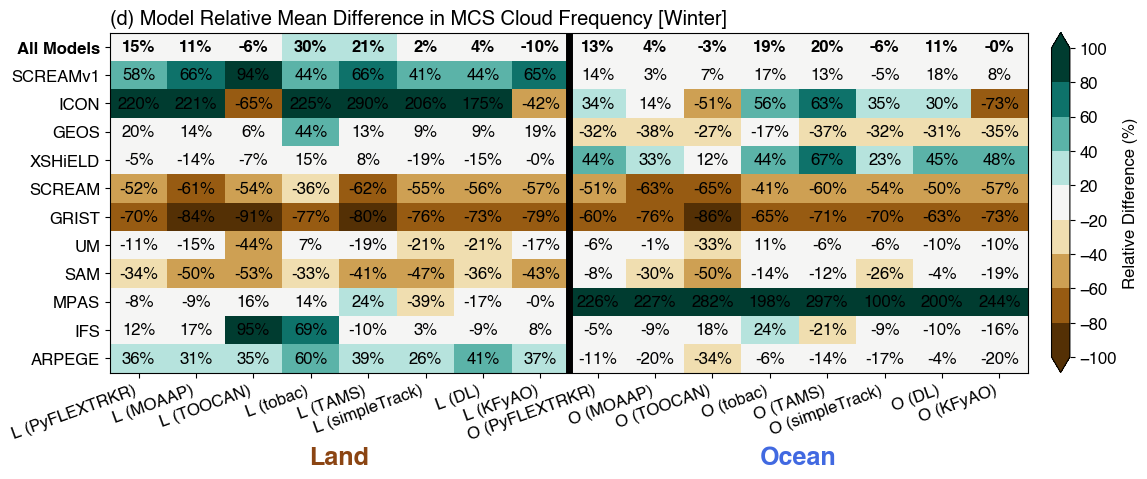

In [141]:
data_arr = mcscloudfreq_diffpercent_all.transpose()
# titles = f'$\Delta$MCS Cloud Frequency (%)'
varname1 = 'MCS Cloud Frequency'
titles = f'{panel_numbers[0]} Model Relative Mean Difference in {varname1} [{PHASE}]'
levels = np.arange(-100, 101, 20)
levels = np.delete(levels, int((len(levels)-1)/2))
cbticks = levels
cblabels = 'Relative Difference (%)'
# cmap = 'RdBu_r'
cmap = 'BrBG'
xlabels = region_names_all
ylabels = list(name_map.values())[1:]
figsize = [12,4]
fontsize = 12
xlabel_rotation = 20
figname = f'{figdir}RelativeDiffHeatmap_mcs_cloudfreq_tropics_all.png'
fig = shade_bias(data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation,
                 levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, figname=figname, figsize=figsize, fontsize=fontsize)

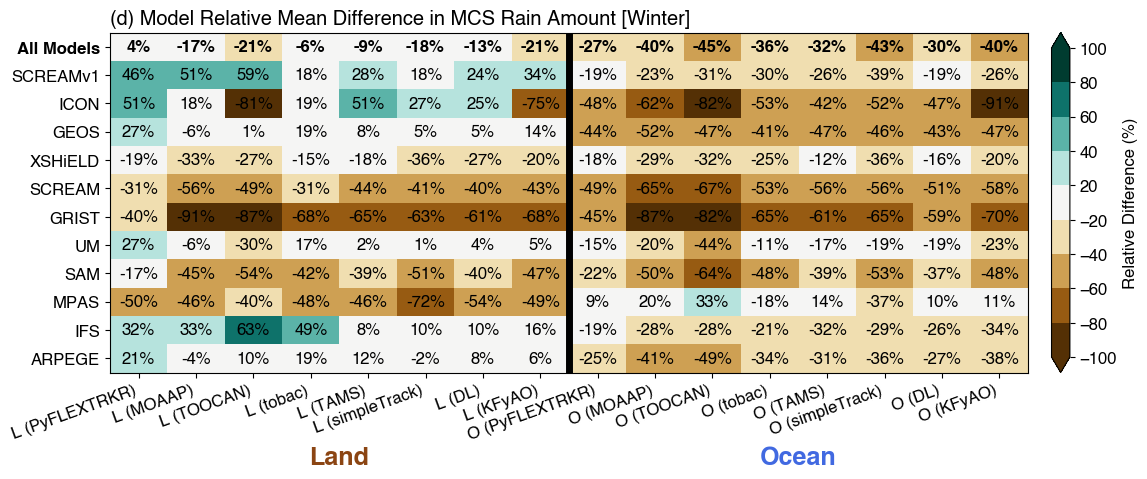

In [142]:
data_arr = mcspcp_diffpercent_all.transpose()
varname1 = 'MCS Rain Amount'
titles = f'{panel_numbers[0]} Model Relative Mean Difference in {varname1} [{PHASE}]'
levels = np.arange(-100, 101, 20)
levels = np.delete(levels, int((len(levels)-1)/2))
cbticks = np.arange(-100, 101, 20)
cbticks = np.delete(cbticks, int((len(cbticks)-1)/2))
cblabels = 'Relative Difference (%)'
# cmap = 'RdBu_r'
cmap = 'BrBG'
xlabels = region_names_all
ylabels = list(name_map.values())[1:]
figsize = [12,4]
fontsize = 12
xlabel_rotation = 20
figname = f'{figdir}RelativeDiffHeatmap_mcs_rain_tropics_all.png'
fig = shade_bias(data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation,
                 levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, figname=figname, figsize=figsize, fontsize=fontsize)

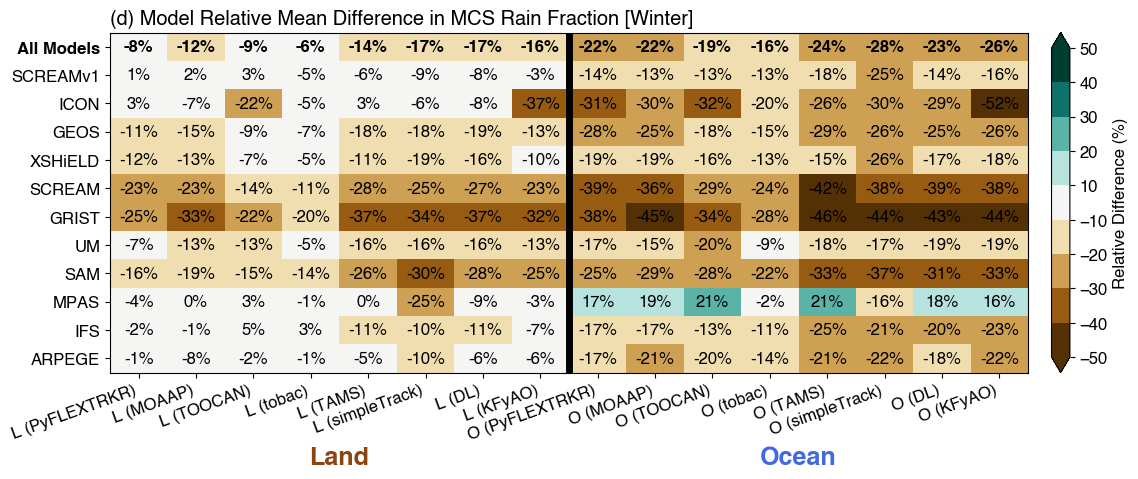

In [143]:
data_arr = mcspcpfrac_diffpercent_all.transpose()
varname1 = 'MCS Rain Fraction'
titles = f'{panel_numbers[0]} Model Relative Mean Difference in {varname1} [{PHASE}]'
levels = np.arange(-50, 51, 10)
levels = np.delete(levels, int((len(levels)-1)/2))
cbticks = levels
cblabels = 'Relative Difference (%)'
# cmap = 'RdBu_r'
cmap = 'BrBG'
xlabels = region_names_all
ylabels = list(name_map.values())[1:]
figsize = [12,4]
fontsize = 12
xlabel_rotation = 20
figname = f'{figdir}RelativeDiffHeatmap_mcs_rainfrac_tropics_all.png'
fig = shade_bias(data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation,
                 levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, figname=figname, figsize=figsize, fontsize=fontsize)

In [144]:
# data_arr = mcspcpfreq_diffpercent_all.transpose()
# titles = f'$\Delta$MCS Rain Frequency (%)'
# levels = np.arange(-100, 101, 20)
# levels = np.delete(levels, int((len(levels)-1)/2))
# cbticks = levels
# cblabels = 'Relative Difference (%)'
# cmap = 'RdBu_r'
# xlabels = region_names_all
# ylabels = list(name_map.values())[1:]
# figsize = [12,4]
# fontsize = 12
# figname = f'{figdir}RelativeDiffHeatmap_mcs_rainfreq_tropics_all.png'
# fig = shade_bias(data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=45,
#                  levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, figname=figname, figsize=figsize, fontsize=fontsize)

In [145]:
# data_arr = mcspcp_diffpercent_all
# titles = f'$\Delta$MCS Rain Amount (%)'
# levels = np.arange(-100, 101, 20)
# levels = np.delete(levels, int((len(levels)-1)/2))
# cbticks = np.arange(-100, 101, 20)
# cbticks = np.delete(cbticks, int((len(cbticks)-1)/2))
# cblabels = 'Relative Difference (%)'
# cmap = 'RdBu_r'
# ylabels = region_names_all
# xlabels = list(name_map.values())[1:]
# figsize = [13,5]
# fontsize = 12
# figname = f'{figdir}RelativeDiffHeatmap_mcs_rain_tropics_all.png'
# fig = shade_bias(data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, 
#                  levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, figname=figname, figsize=figsize, fontsize=fontsize)

In [146]:
# data_arr = mcspcpfrac_diffpercent_all
# titles = f'$\Delta$MCS Rain Fraction (%)'
# levels = np.arange(-50, 51, 10)
# levels = np.delete(levels, int((len(levels)-1)/2))
# cbticks = levels
# cblabels = 'Relative Difference (%)'
# cmap = 'RdBu_r'
# ylabels = region_names_all
# xlabels = list(name_map.values())[1:]
# figsize = [13,5]
# fontsize = 12
# figname = f'{figdir}RelativeDiffHeatmap_mcs_rainfrac_tropics_all.png'
# fig = shade_bias(data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, 
#                  levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, figname=figname, figsize=figsize, fontsize=fontsize)

In [147]:
# data_arr = mcscloudfreq_diffpercent_all
# titles = f'$\Delta$MCS Cloud Frequency (%)'
# levels = np.arange(-100, 101, 20)
# levels = np.delete(levels, int((len(levels)-1)/2))
# cbticks = levels
# cblabels = 'Relative Difference (%)'
# cmap = 'RdBu_r'
# ylabels = region_names_all
# xlabels = list(name_map.values())[1:]
# figsize = [13,5]
# fontsize = 12
# figname = f'{figdir}RelativeDiffHeatmap_mcs_cloudfreq_tropics_all.png'
# fig = shade_bias(data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, 
#                  levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, figname=figname, figsize=figsize, fontsize=fontsize)

In [148]:
# data_arr = mcspcpfreq_diffpercent_all
# titles = f'$\Delta$MCS Rain Frequency (%)'
# levels = np.arange(-100, 101, 20)
# levels = np.delete(levels, int((len(levels)-1)/2))
# cbticks = levels
# cblabels = 'Relative Difference (%)'
# cmap = 'RdBu_r'
# ylabels = region_names_all
# xlabels = list(name_map.values())[1:]
# figsize = [13,5]
# fontsize = 12
# figname = f'{figdir}RelativeDiffHeatmap_mcs_rainfreq_tropics_all.png'
# fig = shade_bias(data_arr, titles=titles, xlabels=xlabels, ylabels=ylabels, 
#                  levels=levels, cmap=cmap, cbticks=cbticks, cblabels=cblabels, figname=figname, figsize=figsize, fontsize=fontsize)

## Function to plot a single map

In [149]:
def plot_single_map(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                  oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None,
                  boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None,):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    ###################################################
    # Map plot
    ###################################################
    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [1]
    w_ratios = [1, 0.02]
    gs = gridspec.GridSpec(1, 2, height_ratios=h_ratios, width_ratios=w_ratios)
    gs.update(left=0.05, right=0.85, bottom=0.1, top=0.95, wspace=0.05, hspace=0.2)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    ax = plt.subplot(gs[0,0], projection=proj)
    ax.set_extent(map_extent, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(titles[0], loc='left')
    
    # Grid lines & labels
    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)         
    ax.set_xticks(lonv, crs=data_proj)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks(latv, crs=data_proj)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
    
    # Select and mask data source
    Zm = np.ma.masked_where(np.isnan(data_map), data_map)
    cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[0]))
    # Set out-of-bounds colors
    if oob_colors is not None:
        cmap.set_over(oob_colors['over'])
        cmap.set_under(oob_colors['under'])
        # cf1.set_clim(min(levels), max(levels))
    norm = colors.BoundaryNorm(boundaries=levels[0], ncolors=cmap.N)
    # Plot data
    if (contourf == False):
        cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
    else:
        cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
           
    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            # Plot region boxes
            corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
            box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
            ax.add_patch(box)

            if boxtexttype is None:
                text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
            else:
                text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
            
    # Colorbars
    cax1 = plt.subplot(gs[0,1])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[0], ticks=cbticks[0], orientation='vertical', extend='both')
    cb1.ax.tick_params(labelsize=cb_fontsize)
              
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [150]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(c)']
elif PHASE == 'Winter':
    panel_numbers = ['(b)', '(d)']
print(panel_numbers)

['(b)', '(d)']


/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_cloudfreq_obs_singlemap_alltrackers.png


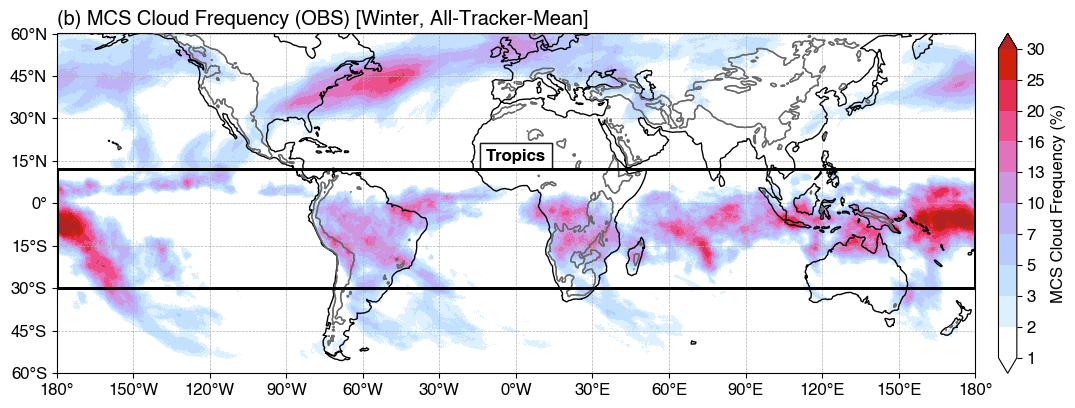

In [151]:
figsize = [12,4]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Cloud Frequency'
units = '%'

# Map data
data_dict = mcscloudfreq_obs_all
lev1 = [1,2,3,5,7,10,13,16,20,25,30]
levels = [lev1]
cbticks = levels
cmaps = [cc.cm.CET_L19]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, All-Tracker-Mean]']
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = [f'{varname1} ({units})']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

figname = f'{figdir}globalmap_mcs_cloudfreq_obs_singlemap_alltrackers.png'
print(figname)
fig = plot_single_map(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_cloudfreq_obs_singlemap_PyFLEXTRKR.png


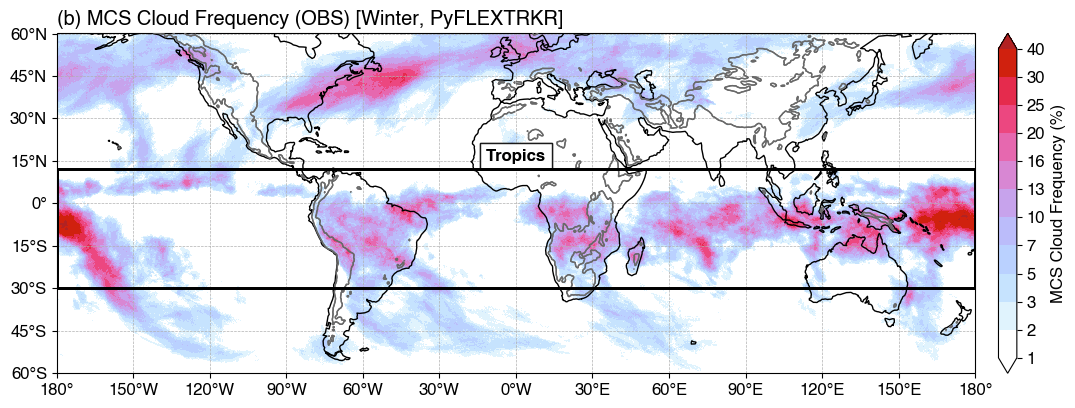

In [152]:
figsize = [12,4]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Cloud Frequency'
units = '%'

# Map data
data_dict = mcscloudfreq_obs_pyflex
lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
levels = [lev1]
cbticks = levels
cmaps = [cc.cm.CET_L19]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]']
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = [f'{varname1} ({units})']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

figname = f'{figdir}globalmap_mcs_cloudfreq_obs_singlemap_PyFLEXTRKR.png'
print(figname)
fig = plot_single_map(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rain_obs_singlemap_alltrackers.png


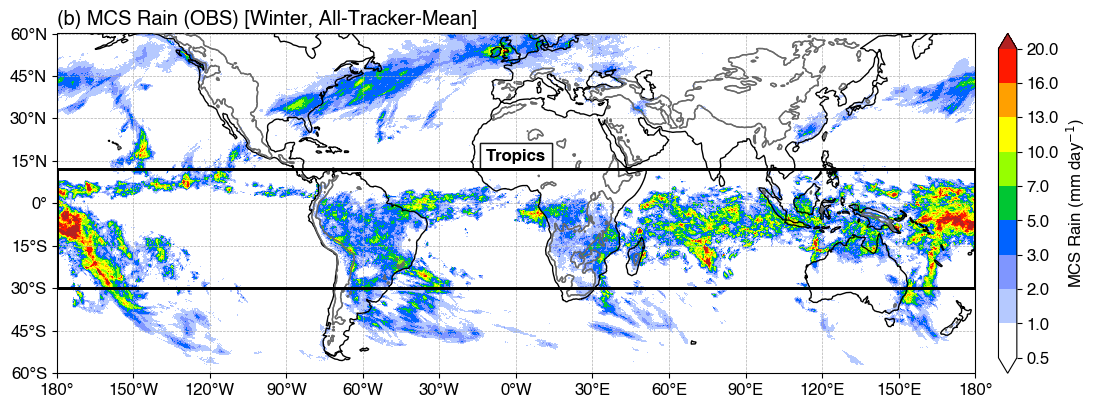

In [153]:
figsize = [12,4]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Rain'
units = 'mm day$^{-1}$'

# Map data
data_dict = mcspcp_obs_all
lev1 = [0.5,1,2,3,5,7,10,13,16,20]
levels = [lev1]
cbticks = levels
cmaps = [generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, All-Tracker-Mean]']
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = [f'{varname1} ({units})']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

figname = f'{figdir}globalmap_mcs_rain_obs_singlemap_alltrackers.png'
print(figname)
fig = plot_single_map(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rain_obs_singlemap_PyFLEXTRKR.png


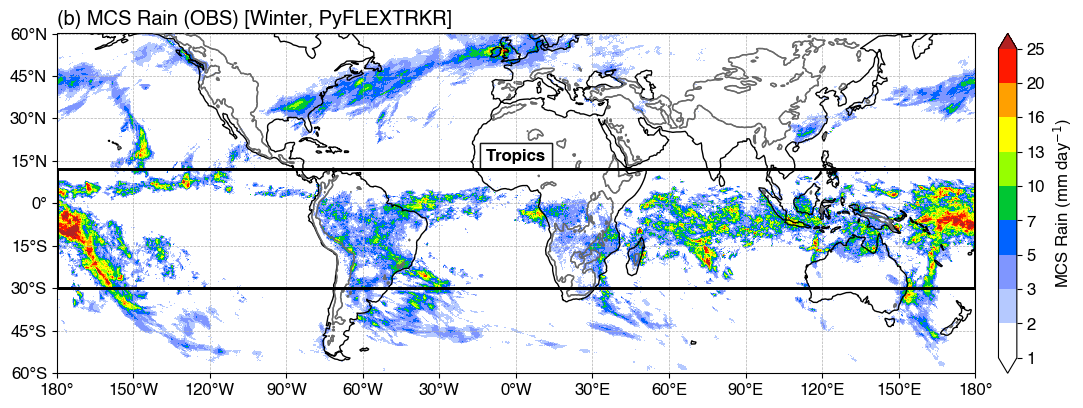

In [154]:
figsize = [12,4]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Rain'
units = 'mm day$^{-1}$'

# Map data
data_dict = mcspcp_obs_pyflex
lev1 = [1,2,3,5,7,10,13,16,20,25]
levels = [lev1]
cbticks = levels
cmaps = [generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]']
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = [f'{varname1} ({units})']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

figname = f'{figdir}globalmap_mcs_rain_obs_singlemap_PyFLEXTRKR.png'
print(figname)
fig = plot_single_map(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rainfrac_obs_singlemap_alltrackers.png


/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


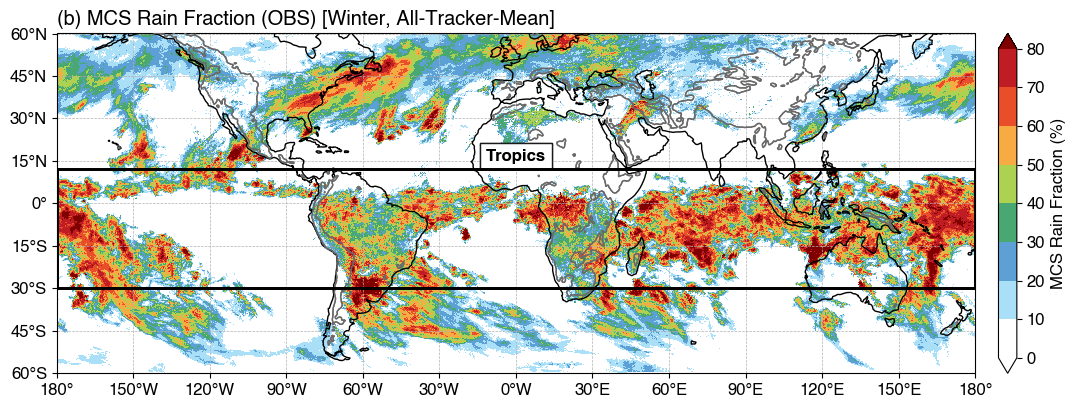

In [155]:
figsize = [12,4]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Rain Fraction'
units = '%'

# Map data
data_dict = mcspcpfrac_obs_all
lev1 = np.arange(0, 80.01, 10)
levels = [lev1]
cbticks = levels
cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap1 = truncate_colormap(cmap1, 0.0, 0.9)
cmaps = [cmap1]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, All-Tracker-Mean]']
oob_colors = {'under':'white', 'over':'maroon'}
cblabels = [f'{varname1} ({units})']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

figname = f'{figdir}globalmap_mcs_rainfrac_obs_singlemap_alltrackers.png'
print(figname)
fig = plot_single_map(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rainfrac_obs_singlemap_PyFLEXTRKR.png


/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


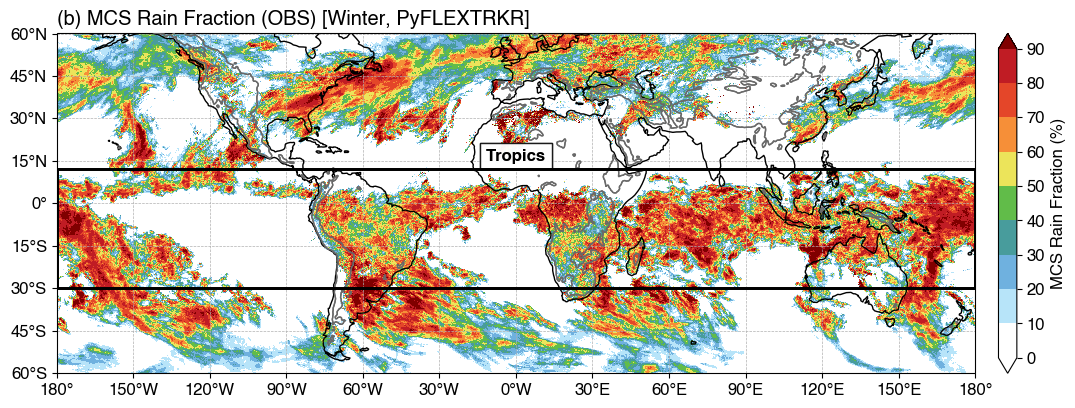

In [156]:
figsize = [12,4]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Rain Fraction'
units = '%'

# Map data
data_dict = mcspcpfrac_obs_pyflex
lev1 = np.arange(0, 90.01, 10)
levels = [lev1]
cbticks = levels
cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap1 = truncate_colormap(cmap1, 0.0, 0.9)
cmaps = [cmap1]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]']
oob_colors = {'under':'white', 'over':'maroon'}
cblabels = [f'{varname1} ({units})']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

figname = f'{figdir}globalmap_mcs_rainfrac_obs_singlemap_PyFLEXTRKR.png'
print(figname)
fig = plot_single_map(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',)

In [157]:
# figsize = [12,4]
# fontsize = 12
# cb_fontsize = 12
# varname1 = 'MCS Rain'
# # varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Map data
# data_dict = mcspcp_obs_pyflex
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = np.arange(-100, 101, 20)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# levels = [lev1, lev2]
# cbticks = levels
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
# cmaps = [cmap1, cmap2]
# titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
#           f'{panel_numbers[1]} Model Relative Mean Difference in {varname1} [{PHASE}]']
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
# text_colors = None
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# figname = f'{figdir}globalmap_mcs_rain_obs_singlemap.png'
# print(figname)
# fig = plot_single_map(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',)

# Function to plot map, bar charts, and heatmap (relative difference)

In [158]:
# def plot_map_bars_heatmap(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
#                   oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None,
#                   boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None,
#                   bar_data=None, bar_width=None, bar_ylabel=None, legend_prop=None, bar_ylim=None, bar_xlabels=None, bar_xlabel_rotation=0,
#                   heatmap_data=None, xlabels=None, ylabels=None, xlabel_rotation=0):
#                   # boxes=None, boxtextloc=None, dict_text_type=None, dict_text_val=None, text_colors=None, boxtext_fontsize=None):
    
#     mpl.rcParams['font.size'] = fontsize
#     mpl.rcParams['font.family'] = 'Helvetica'

#     ###################################################
#     # Map plot
#     ###################################################
#     map_extent = [-180., 179.5, -60.1, 60.1]
#     lonv = np.arange(-180,180.1,30)
#     latv = np.arange(-60,60.1,15)
#     proj = ccrs.PlateCarree(central_longitude=0)
#     data_proj = ccrs.PlateCarree()
#     levelshgt = [1000,10000]

#     fig = plt.figure(figsize=figsize, dpi=100)
#     # h_ratios = [0.05, 1, 1]
#     # gs = gridspec.GridSpec(3, 1, height_ratios=h_ratios, width_ratios=[1])
#     # gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.25)
#     h_ratios = [1, 1, 1]
#     w_ratios = [1, 0.02]
#     gs = gridspec.GridSpec(3, 2, height_ratios=h_ratios, width_ratios=w_ratios)
#     gs.update(left=0.05, right=0.85, bottom=0.1, top=0.95, wspace=0.05, hspace=0.35)

#     resolution = '110m'
#     land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
#     ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
#     borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
#     ax = plt.subplot(gs[0,0], projection=proj)
#     ax.set_extent(map_extent, crs=proj)
#     ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
#     ax.set_aspect('auto', adjustable=None)
#     ax.set_title(titles[0], loc='left')
    
#     # Grid lines & labels
#     gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
#     gl.xlocator = mpl.ticker.FixedLocator(lonv)
#     gl.ylocator = mpl.ticker.FixedLocator(latv)         
#     # if (row == nrow-1):
#     ax.set_xticks(lonv, crs=data_proj)
#     lon_formatter = LongitudeFormatter(zero_direction_label=True)
#     ax.xaxis.set_major_formatter(lon_formatter)
#     ax.set_yticks(latv, crs=data_proj)
#     lat_formatter = LatitudeFormatter()
#     ax.yaxis.set_major_formatter(lat_formatter)

#     # Terrain height
#     ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
#                     colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
    
#     # Select and mask data source
#     Zm = np.ma.masked_where(np.isnan(data_map), data_map)
#     cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[0]))
#     # Set out-of-bounds colors
#     if oob_colors is not None:
#         cmap.set_over(oob_colors['over'])
#         cmap.set_under(oob_colors['under'])
#         # cf1.set_clim(min(levels), max(levels))
#     norm = colors.BoundaryNorm(boundaries=levels[0], ncolors=cmap.N)
#     # Plot data
#     if (contourf == False):
#         cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
#     else:
#         cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
           
#     # Plot boxes
#     if boxes is not None:
#         for ii in boxes:
#             # Plot region boxes
#             corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
#             box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
#             ax.add_patch(box)

#             if boxtexttype is None:
#                 text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
#                 ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
#                         bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
#                         fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
#             else:
#                 text_color = 'k'
#                 ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
#                         bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
#                         fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    
#     ###################################################
#     # Bar chart
#     ###################################################
#     ax2 = plt.subplot(gs[1,0])
#     # labels = list(boxes.keys())
#     x = np.arange(len(bar_xlabels))
#     # multiplier = -((len(name_map)-1)/2)
#     multiplier = -((len(bar_data))/2)
#     lcolors = {
#         'obs': 'k', 
#         'm1': 'crimson',
#         'm2': 'darkorange', 
#         'm3': 'gold',
#         'm4': 'mediumseagreen',
#         'm5': 'turquoise',
#         'm6': 'lime',
#         'm7': 'blue',
#         'm8': 'deepskyblue',
#         'm9': 'purple',
#         'm10': 'violet',
#         'm11': 'deeppink',
#         'm12': 'dodgerblue',
#         'mmm': 'red',
#     }

#     # Loop over each source    
#     for key, val in bar_data.items():
#         offset = bar_width * multiplier
#         rects = ax2.bar(x + offset, val, bar_width, color=lcolors[key], label=name_map[key], zorder=2)
#         multiplier += 1    

#     # Add some text for xlabels, title and custom x-axis tick xlabels, etc.
#     ax2.set_ylabel(bar_ylabel)
#     ax2.set_title(titles[1], loc='left')
#     # ax2.set_xticks(x, bar_xlabels)
#     # Set xlabel text alignment
#     xlabel_ha = 'right' if bar_xlabel_rotation > 0 else 'center'
#     ax2.set_xticks(x, bar_xlabels, rotation=bar_xlabel_rotation, ha=xlabel_ha)
    
#     ax2.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['legend_loc'], bbox_to_anchor=legend_prop['legend_anchor'])
#     ax2.axhline(y=0, lw=1, ls='--', color='k')
#     ax2.grid(which='major', ls='--', axis='y')
#     ax2.set_ylim(bar_ylim[0], bar_ylim[1])
    
#     # Shade the background with colors
#     # Get x-axis limits
#     xmin, xmax = ax2.get_xlim()
#     midpoint = (xmin + xmax) / 2
#     ax2.axvspan(xmin, midpoint, facecolor='antiquewhite', alpha=0.6)
#     ax2.axvspan(midpoint, xmax, facecolor='lightcyan', alpha=0.6)
#     ax2.set_xlim(xmin, xmax)
    
#     ax2.text(0.25, 0.9, 'Land', ha='center', va='center', color='saddlebrown', fontweight='bold', fontsize=fontsize*1.5, transform=ax2.transAxes)
#     ax2.text(0.75, 0.9, 'Ocean', ha='center', va='center', color='royalblue', fontweight='bold', fontsize=fontsize*1.5, transform=ax2.transAxes)
    
#     # # Plot a vertical line in the middle of the axis
#     # xmin, xmax = ax2.get_xlim()
#     # midpoint = (xmin + xmax) / 2
#     # ax2.axvline(x=midpoint, lw=3, color='k', ls='--')
    
#     ###################################################
#     # Heatmap
#     ###################################################
#     ax3 = plt.subplot(gs[2,0])
#     # Shade the background with colors
#     cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[1]))
#     norm = mpl.colors.BoundaryNorm(boundaries=levels[1], ncolors=cmap.N)
#     pcm3 = ax3.pcolormesh(heatmap_data, norm=norm, cmap=cmap)
#     ax3.set_title(titles[2], loc='left')
#     # Colorbar
#     # fig.colorbar(pcm, label=cblabels, ticks=cbticks, extend='both', pad=0.01, shrink=cbshrink)

#     # Axis labels
#     n_xlabels = len(xlabels)
#     n_ylabels = len(ylabels)
#     x_centers = np.arange(0.5, n_xlabels+0.5, 1)
#     y_centers = np.arange(0.5, n_ylabels+0.5, 1)
#     xlabel_ha = 'right' if xlabel_rotation > 0 else 'center'
#     # ax.set_xticks(x, xlabels, rotation=xlabel_rotation, ha=xlabel_ha)
#     ax3.set_xticks(x_centers, xlabels, rotation=xlabel_rotation, ha=xlabel_ha)
#     ax3.set_yticks(y_centers, ylabels)
   
#     # Plot a vertical line in the middle of the axis
#     xmin, xmax = ax3.get_xlim()
#     midpoint = (xmin + xmax) / 2
#     ax3.axvline(x=midpoint, lw=5, color='k')

#     # Add text annotations at the center of each cell
#     for i, x in enumerate(x_centers):
#         for j, y in enumerate(y_centers):
#             fontweight = 'bold' if (j == n_ylabels-1) else 'normal'
#             ax3.annotate(f'{heatmap_data[j, i]:.0f}%', (x, y), color='k', fontsize=fontsize, fontweight=fontweight, ha='center', va='center')
            
#     # Get the current y-tick labels
#     yticks = ax3.get_yticks()
#     yticklabels = ax3.get_yticklabels()
#     # Set the last y-tick label to bold
#     yticklabels[-1].set_fontweight('bold')
#     # Apply the modified labels back to the plot
#     ax3.set_yticklabels(yticklabels)
    
#     # Colorbars
#     cax1 = plt.subplot(gs[0,1])
#     cax3 = plt.subplot(gs[2,1])
#     cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[0], ticks=cbticks[0], orientation='vertical', extend='both')
#     cb3 = plt.colorbar(pcm3, cax=cax3, label=cblabels[1], ticks=cbticks[1], extend='both')
#     cb1.ax.tick_params(labelsize=cb_fontsize)
#     cb3.ax.tick_params(labelsize=cb_fontsize)
    
#     fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
#     return fig

In [159]:
# if PHASE == 'Summer':
#     panel_numbers = ['(a)', '(c)', '(e)']
# elif PHASE == 'Winter':
#     panel_numbers = ['(b)', '(d)', '(f)']
# print(panel_numbers)

In [160]:
# figsize = [10,12]
# fontsize = 12
# cb_fontsize = 12
# varname1 = 'MCS Cloud Frequency'
# varname2 = 'MCS Cloud Frequency'
# units = '%'

# # Map data
# data_dict = mcscloudfreq_obs_pyflex
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-100, 101, 20)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# levels = [lev1, lev2]
# cbticks = levels
# cmap1 = cc.cm.CET_L19
# cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
# cmaps = [cmap1, cmap2]
# titles = [
#     f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
#     f'{panel_numbers[1]} Mean {varname1} [{PHASE}]', 
#     f'{panel_numbers[2]} Model Relative Mean Difference in {varname1} [{PHASE}]'
# ]
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
# text_colors = None
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcscloudfreqAvg_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} (%)'
# bar_ylim = (0,14)
# bar_width = 0.06
# # legend_prop = {'ncol':len(name_map), 'fontsize':8, 'legend_loc':'upper right', 'legend_anchor':(1.1, 1.2)}
# legend_prop = {'ncol':1, 'fontsize':8, 'legend_loc':'upper right', 'legend_anchor':(1.15, 1.)}
# bar_xlabel_rotation = 20

# # Heatmap data
# heatmap_data = mcscloudfreq_diffpercent_all.transpose()
# xlabels = region_names_all
# ylabels = list(name_map.values())[1:]
# xlabel_rotation = 20

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_barchart_heatmap_diff.png'
# print(figname)
# fig = plot_map_bars_heatmap(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=bar_xlabel_rotation, 
#                     heatmap_data=heatmap_data, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation)

In [161]:
# figsize = [10,12]
# fontsize = 12
# cb_fontsize = 12
# varname1 = 'MCS Rain'
# varname2 = 'MCS Rain'
# units = 'mm day$^{-1}$'

# # Map data
# data_dict = mcspcp_obs_pyflex
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = np.arange(-100, 101, 20)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# levels = [lev1, lev2]
# cbticks = levels
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
# cmaps = [cmap1, cmap2]
# titles = [
#     f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
#     f'{panel_numbers[1]} Mean {varname1} [{PHASE}]', 
#     f'{panel_numbers[2]} Model Relative Mean Difference in {varname1} [{PHASE}]'
# ]
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
# text_colors = None
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcpAvg_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} ({units})'
# bar_ylim = (0,4)
# bar_width = 0.06
# # legend_prop = {'ncol':len(name_map), 'fontsize':8, 'legend_loc':'upper right', 'legend_anchor':(1.1, 1.2)}
# legend_prop = {'ncol':1, 'fontsize':8, 'legend_loc':'upper right', 'legend_anchor':(1.15, 1.)}
# bar_xlabel_rotation = 20

# # Heatmap data
# heatmap_data = mcspcp_diffpercent_all.transpose()
# xlabels = region_names_all
# ylabels = list(name_map.values())[1:]

# figname = f'{figdir}globalmap_mcs_rain_obs_barchart_heatmap_diff.png'
# print(figname)
# fig = plot_map_bars_heatmap(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=bar_xlabel_rotation, 
#                     heatmap_data=heatmap_data, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation)

In [162]:
# figsize = [10,12]
# fontsize = 12
# cb_fontsize = 12
# varname1 = 'MCS Rain Fraction'
# varname2 = 'MCS Rain Fraction'
# units = '%'

# # Map data
# data_dict = mcspcpfrac_obs_pyflex
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-50, 51, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# levels = [lev1, lev2]
# cbticks = levels
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap1 = truncate_colormap(cmap1, 0.0, 0.9)
# cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
# cmaps = [cmap1, cmap2]
# titles = [
#     f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
#     f'{panel_numbers[1]} Mean {varname1} [{PHASE}]', 
#     f'{panel_numbers[2]} Model Relative Mean Difference in {varname1} [{PHASE}]'
# ]
# oob_colors = {'under':'white', 'over':'magenta'}
# cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
# text_colors = None
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcpfracAvg_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} ({units})'
# bar_ylim = (0,80)
# bar_width = 0.06
# # legend_prop = {'ncol':len(name_map), 'fontsize':8, 'legend_loc':'upper right', 'legend_anchor':(1.1, 1.2)}
# legend_prop = {'ncol':1, 'fontsize':8, 'legend_loc':'upper right', 'legend_anchor':(1.15, 1.)}
# bar_xlabel_rotation = 20

# # Heatmap data
# heatmap_data = mcspcpfrac_diffpercent_all.transpose()
# xlabels = region_names_all
# ylabels = list(name_map.values())[1:]

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_barchart_heatmap_diff.png'
# print(figname)
# fig = plot_map_bars_heatmap(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=bar_xlabel_rotation, 
#                     heatmap_data=heatmap_data, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation)

In [163]:
# figsize = [10,12]
# fontsize = 12
# cb_fontsize = 12
# varname1 = 'MCS Rain Frequency'
# varname2 = 'MCS Rain Frequency'
# units = '%'

# # Map data
# data_dict = mcspcpfreq_obs_pyflex
# lev1 = [0.2,0.5,1,2,2.5,3,5,7,10,13,16,20]
# lev2 = np.arange(-100, 101, 20)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# levels = [lev1, lev2]
# cbticks = levels
# cmap1 = cc.cm.CET_L19
# cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
# cmaps = [cmap1, cmap2]
# titles = [
#     f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
#     f'{panel_numbers[1]} Mean {varname1} [{PHASE}]', 
#     f'{panel_numbers[2]} Model Relative Mean Difference in {varname1} [{PHASE}]'
# ]
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
# text_colors = None
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcpfreqAvg_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} ({units})'
# bar_ylim = (0,3)
# bar_width = 0.06
# # legend_prop = {'ncol':len(name_map), 'fontsize':8, 'legend_loc':'upper right', 'legend_anchor':(1.1, 1.2)}
# legend_prop = {'ncol':1, 'fontsize':8, 'legend_loc':'upper right', 'legend_anchor':(1.15, 1.)}
# bar_xlabel_rotation = 20

# # Heatmap data
# heatmap_data = mcspcpfreq_diffpercent_all.transpose()
# xlabels = region_names_all
# ylabels = list(name_map.values())[1:]

# figname = f'{figdir}globalmap_mcs_rainfreq_obs_barchart_heatmap_diff.png'

# fig = plot_map_bars_heatmap(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=bar_xlabel_rotation, 
#                     heatmap_data=heatmap_data, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation)

## Function to plot 1 map and heatmap (relative difference)

In [164]:
def plot_map_heatmap(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                  oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None,
                  boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None,
                  heatmap_data=None, xlabels=None, ylabels=None, xlabel_rotation=None, xlabel_ha='right'):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    ###################################################
    # Map plot
    ###################################################
    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [1, 1]
    w_ratios = [1, 0.02]
    gs = gridspec.GridSpec(2, 2, height_ratios=h_ratios, width_ratios=w_ratios)
    gs.update(left=0.05, right=0.85, bottom=0.1, top=0.95, wspace=0.05, hspace=0.2)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    ax = plt.subplot(gs[0,0], projection=proj)
    ax.set_extent(map_extent, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(titles[0], loc='left')
    
    # Grid lines & labels
    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)         
    # if (row == nrow-1):
    ax.set_xticks(lonv, crs=data_proj)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks(latv, crs=data_proj)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
    
    # Select and mask data source
    Zm = np.ma.masked_where(np.isnan(data_map), data_map)
    cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[0]))
    # Set out-of-bounds colors
    if oob_colors is not None:
        cmap.set_over(oob_colors['over'])
        cmap.set_under(oob_colors['under'])
        # cf1.set_clim(min(levels), max(levels))
    norm = colors.BoundaryNorm(boundaries=levels[0], ncolors=cmap.N)
    # Plot data
    if (contourf == False):
        cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
    else:
        cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
           
    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            # Plot region boxes
            corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
            box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
            ax.add_patch(box)

            if boxtexttype is None:
                text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
            else:
                text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    
    ###################################################
    # Heatmap plot
    ###################################################
    ax2 = plt.subplot(gs[1,0])
    cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[1]))
    norm = mpl.colors.BoundaryNorm(boundaries=levels[1], ncolors=cmap.N)
    pcm2 = ax2.pcolormesh(heatmap_data, norm=norm, cmap=cmap)
    ax2.set_title(titles[1], loc='left')
    
    # Axis labels
    n_xlabels = len(xlabels)
    n_ylabels = len(ylabels)
    x_centers = np.arange(0.5, n_xlabels+0.5, 1)
    y_centers = np.arange(0.5, n_ylabels+0.5, 1)
    # ax2.set_xticks(x_centers, xlabels, rotation=90)
    ax2.set_xticks(x_centers, xlabels, rotation=xlabel_rotation, ha=xlabel_ha)
    ax2.set_yticks(y_centers, ylabels)
    
    # Add a horizontal line to divide regions
    # # Get x-axis limits
    # ymin, ymax = ax2.get_ylim()
    # midpoint = (ymin + ymax) / 2
    # ax2.axhline(y=midpoint, lw=5, color='k')
    # Plot a vertical line in the middle of the axis
    xmin, xmax = ax2.get_xlim()
    midpoint = (xmin + xmax) / 2
    ax2.axvline(x=midpoint, lw=5, color='k')

    # Add text annotations at the center of each cell
    for i, x in enumerate(x_centers):
        for j, y in enumerate(y_centers):
            fontweight = 'bold' if (j == n_ylabels-1) else 'normal'
            ax2.annotate(f'{heatmap_data[j, i]:.0f}%', (x, y), color='k', fontsize=fontsize, fontweight=fontweight, ha='center', va='center')
            
    # Get the current y-tick labels
    yticks = ax2.get_yticks()
    yticklabels = ax2.get_yticklabels()
    # Set the last y-tick label to bold
    yticklabels[-1].set_fontweight('bold')
    # Apply the modified labels back to the plot
    ax2.set_yticklabels(yticklabels)
    # Label Land/Ocean below x-axis
    ax2.text(0.25, -0.25, 'Land', ha='center', va='center', color='saddlebrown', fontweight='bold', fontsize=fontsize*1.5, transform=ax2.transAxes)
    ax2.text(0.75, -0.25, 'Ocean', ha='center', va='center', color='royalblue', fontweight='bold', fontsize=fontsize*1.5, transform=ax2.transAxes)
            
    # Colorbars
    cax1 = plt.subplot(gs[0,1])
    cax2 = plt.subplot(gs[1,1])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels[0], ticks=cbticks[0], orientation='vertical', extend='both')
    cb2 = plt.colorbar(pcm2, cax=cax2, label=cblabels[1], ticks=cbticks[1], extend='both')
    cb1.ax.tick_params(labelsize=cb_fontsize)
    cb2.ax.tick_params(labelsize=cb_fontsize)
              
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [165]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(c)']
elif PHASE == 'Winter':
    panel_numbers = ['(b)', '(d)']
print(panel_numbers)

['(b)', '(d)']


/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_cloudfreq_obs_heatmap_diff.png


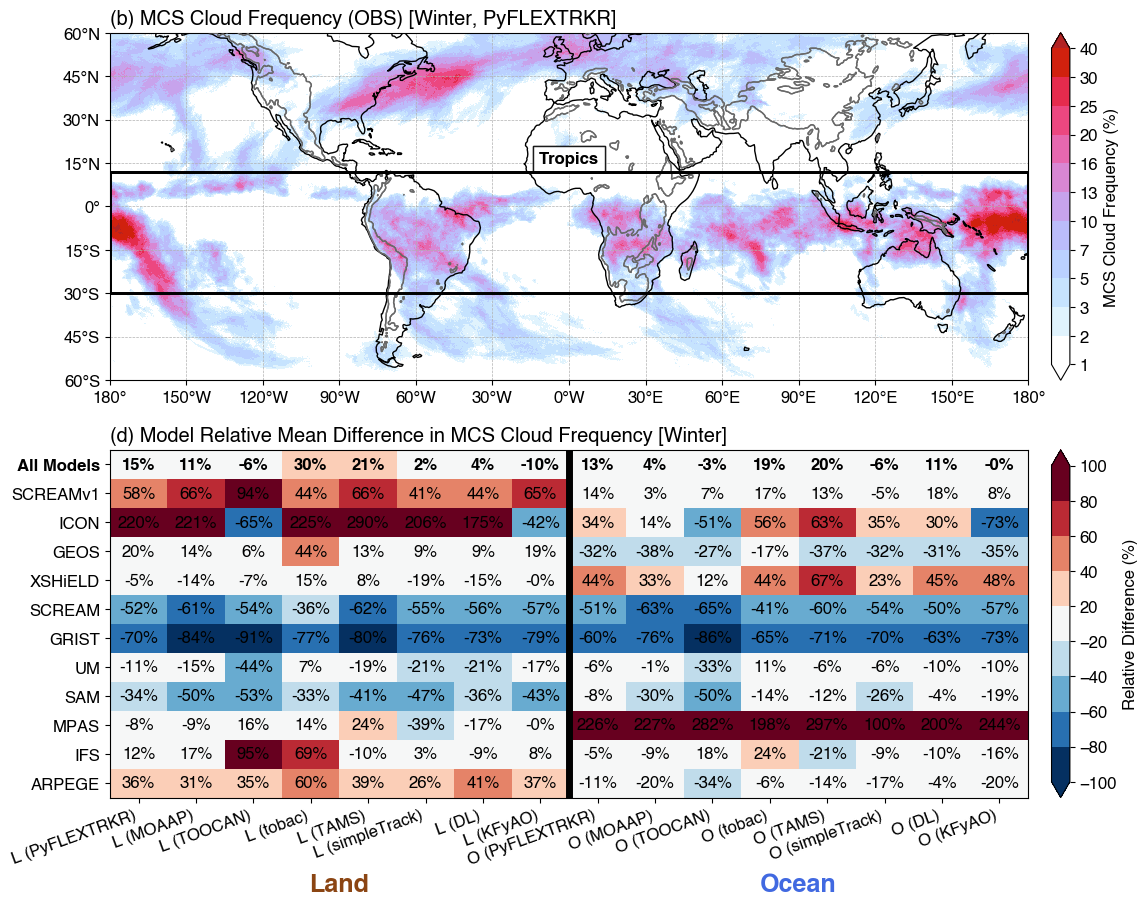

In [166]:
figsize = [12,9]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Cloud Frequency'
varname2 = '$\Delta$MCS Cloud Frequency'
units = '%'

# Map data
data_dict = mcscloudfreq_obs_pyflex
lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
lev2 = np.arange(-100, 101, 20)
lev2 = np.delete(lev2, int((len(lev2)-1)/2))
levels = [lev1, lev2]
cbticks = levels
cmap1 = cc.cm.CET_L19
cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap1, cmap2]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
          f'{panel_numbers[1]} Model Relative Mean Difference in {varname1} [{PHASE}]']
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# Heatmap data
heatmap_data = mcscloudfreq_diffpercent_all.transpose()
xlabels = region_names_all
ylabels = list(name_map.values())[1:]
xlabel_rotation = 20
# ylabels = region_names_all
# xlabels = list(name_map.values())[1:]

figname = f'{figdir}globalmap_mcs_cloudfreq_obs_heatmap_diff.png'
print(figname)
fig = plot_map_heatmap(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    heatmap_data=heatmap_data, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rain_obs_heatmap_diff.png


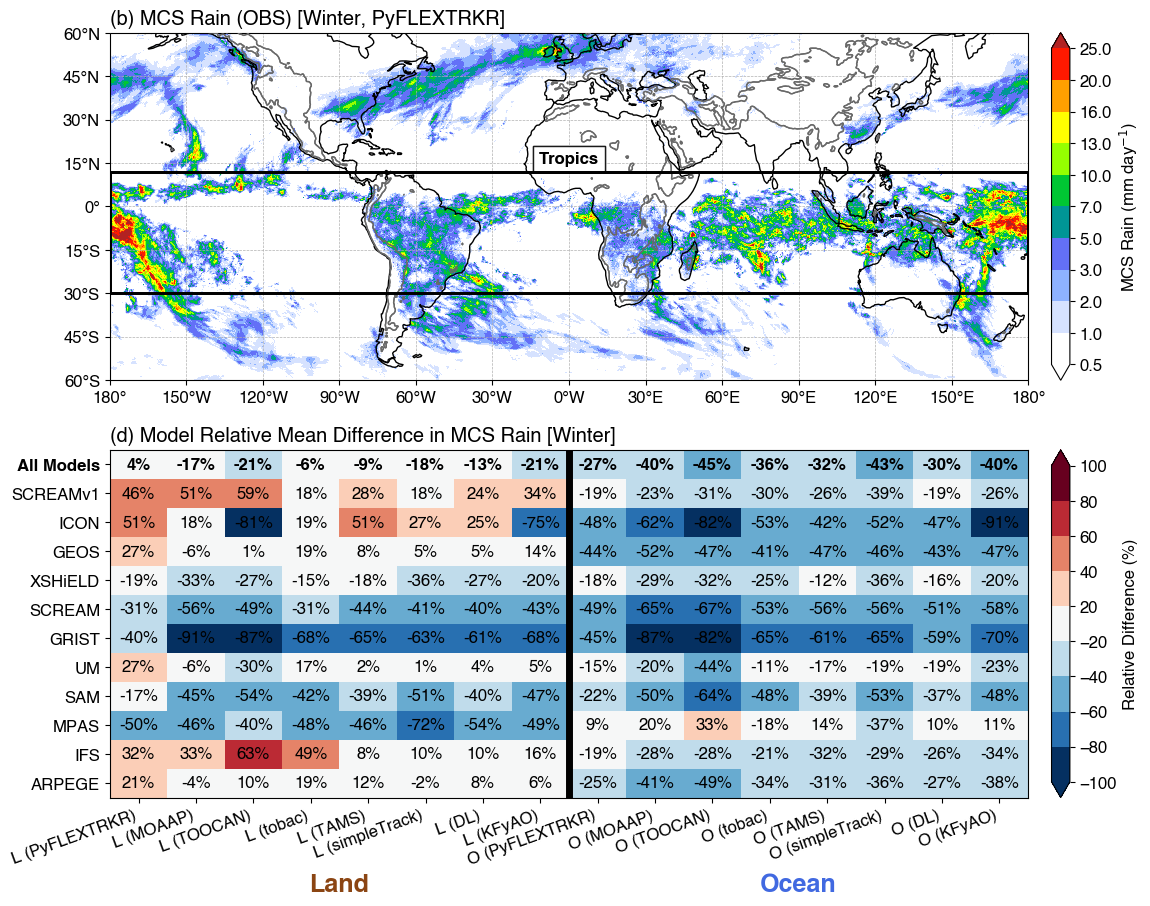

In [167]:
figsize = [12,9]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Rain'
varname2 = '$\Delta$MCS Rain'
units = 'mm day$^{-1}$'

# Map data
data_dict = mcspcp_obs_pyflex
lev1 = [0.5,1,2,3,5,7,10,13,16,20,25]
lev2 = np.arange(-100, 101, 20)
lev2 = np.delete(lev2, int((len(lev2)-1)/2))
levels = [lev1, lev2]
cbticks = levels
cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap1, cmap2]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
          f'{panel_numbers[1]} Model Relative Mean Difference in {varname1} [{PHASE}]']
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# Heatmap data
# heatmap_data = mcspcp_diffpercent_all
# ylabels = region_names_all
# xlabels = list(name_map.values())[1:]
heatmap_data = mcspcp_diffpercent_all.transpose()
xlabels = region_names_all
ylabels = list(name_map.values())[1:]
xlabel_rotation = 20

figname = f'{figdir}globalmap_mcs_rain_obs_heatmap_diff.png'
print(figname)
fig = plot_map_heatmap(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    heatmap_data=heatmap_data, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rainfrac_obs_heatmap_diff.png


/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


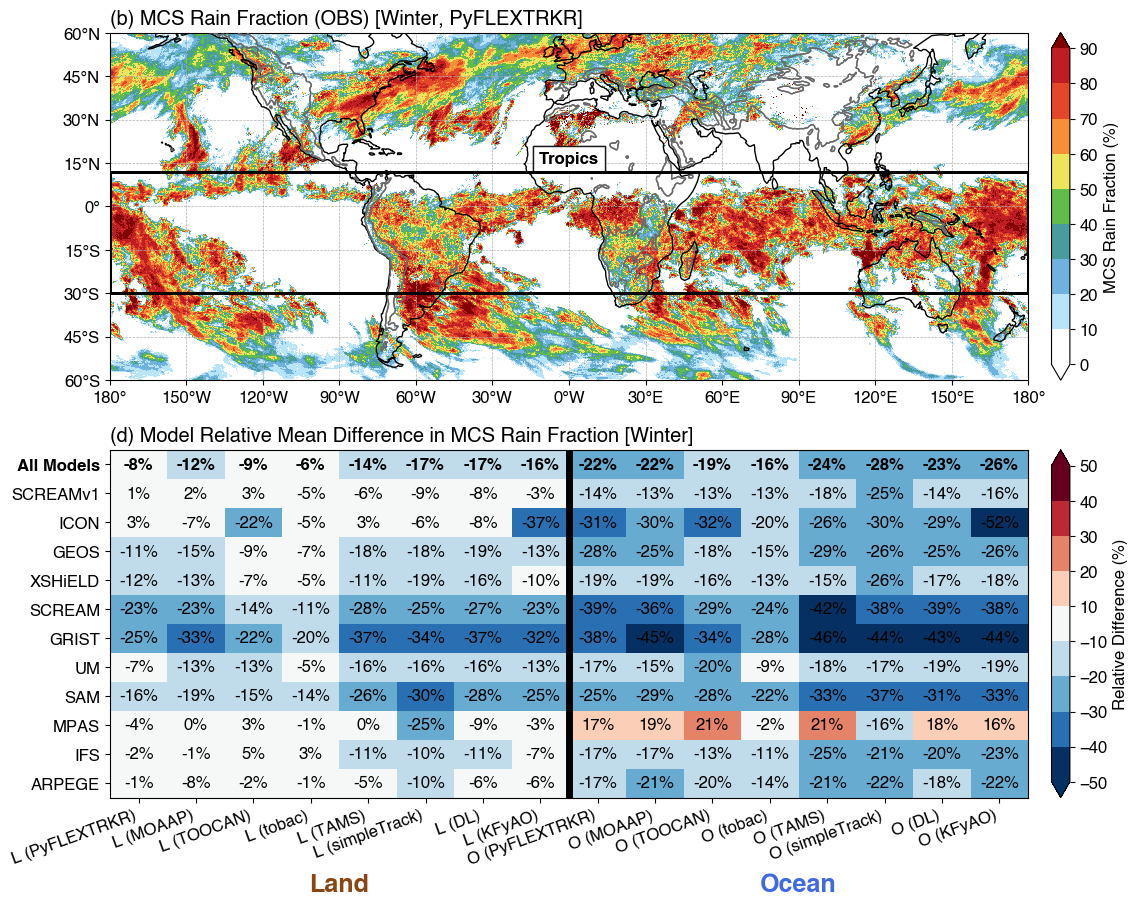

In [168]:
figsize = [12,9]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Rain Fraction'
varname2 = '$\Delta$MCS Rain Fraction'
units = '%'

# Map data
data_dict = mcspcpfrac_obs_pyflex
lev1 = np.arange(0, 90.01, 10)
lev2 = np.arange(-50, 51, 10)
lev2 = np.delete(lev2, int((len(lev2)-1)/2))
levels = [lev1, lev2]
cbticks = levels
cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmap1 = truncate_colormap(cmap1, 0.0, 0.9)
cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap1, cmap2]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
          f'{panel_numbers[1]} Model Relative Mean Difference in {varname1} [{PHASE}]']
oob_colors = {'under':'white', 'over':'maroon'}
cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# Heatmap data
heatmap_data = mcspcpfrac_diffpercent_all.transpose()
xlabels = region_names_all
ylabels = list(name_map.values())[1:]
xlabel_rotation = 20
# ylabels = region_names_all
# xlabels = list(name_map.values())[1:]

figname = f'{figdir}globalmap_mcs_rainfrac_obs_heatmap_diff.png'
print(figname)
fig = plot_map_heatmap(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    heatmap_data=heatmap_data, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rainfreq_obs_heatmap_diff.png


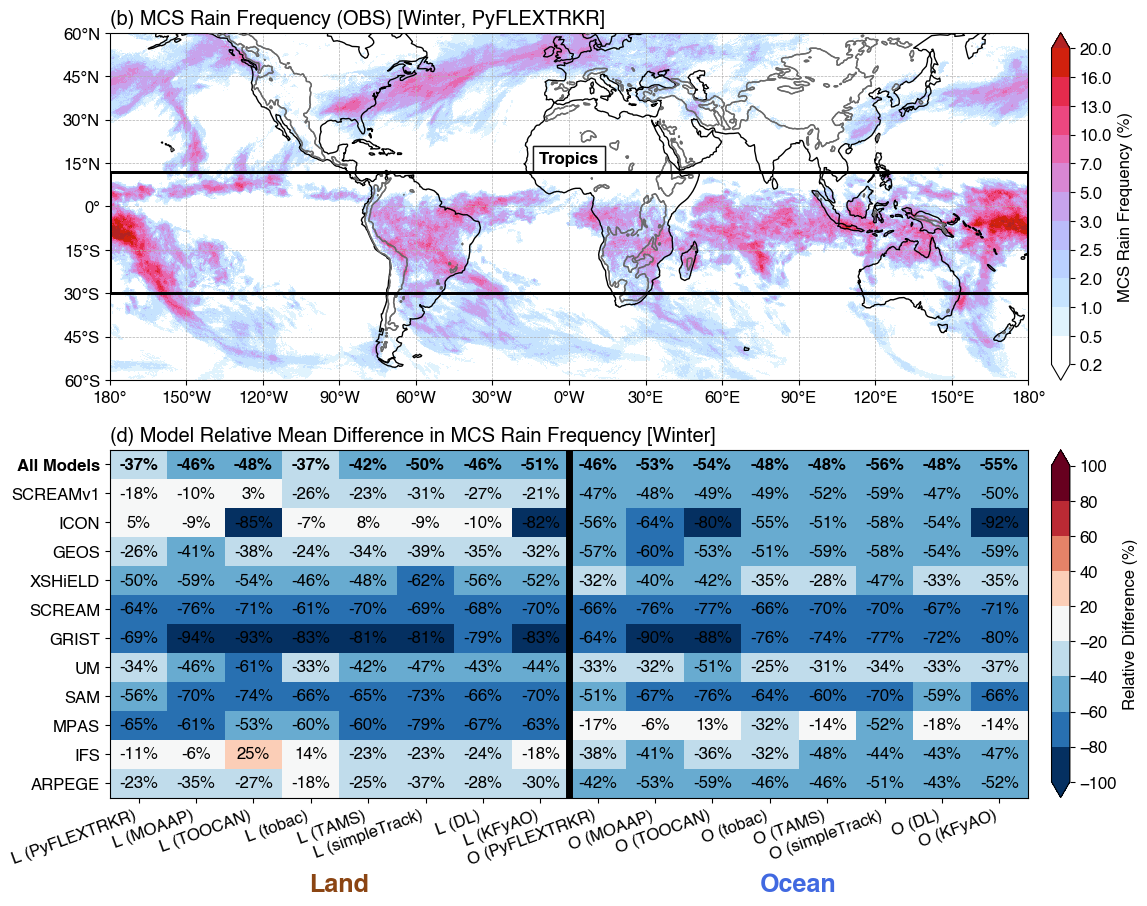

In [169]:
figsize = [12,9]
fontsize = 12
cb_fontsize = 12
varname1 = 'MCS Rain Frequency'
varname2 = '$\Delta$MCS Rain Frequency'
units = '%'

# Map data
data_dict = mcspcpfreq_obs_pyflex
lev1 = [0.2,0.5,1,2,2.5,3,5,7,10,13,16,20]
lev2 = np.arange(-100, 101, 20)
lev2 = np.delete(lev2, int((len(lev2)-1)/2))
levels = [lev1, lev2]
cbticks = levels
cmap1 = cc.cm.CET_L19
cmap2 = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [cmap1, cmap2]
titles = [f'{panel_numbers[0]} {varname1} (OBS) [{PHASE}, PyFLEXTRKR]', 
          f'{panel_numbers[1]} Model Relative Mean Difference in {varname1} [{PHASE}]']
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = [f'{varname1} ({units})', 'Relative Difference (%)']
text_colors = None
text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# Heatmap data
heatmap_data = mcspcpfreq_diffpercent_all.transpose()
xlabels = region_names_all
ylabels = list(name_map.values())[1:]
xlabel_rotation = 20
# ylabels = region_names_all
# xlabels = list(name_map.values())[1:]

figname = f'{figdir}globalmap_mcs_rainfreq_obs_heatmap_diff.png'
print(figname)
fig = plot_map_heatmap(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    heatmap_data=heatmap_data, xlabels=xlabels, ylabels=ylabels, xlabel_rotation=xlabel_rotation)

In [170]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rainfreq_obs_heatmap_diff.png'

## Plot regional mean difference as bar chart

In [171]:
def bar_chart(dict_data, xlabels, name_map, width=None, ylabel=None, ylim=None, title=None, legend_prop=None, figsize=None, figname=None, xlabel_rotation=0, fontsize=14):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # labels = list(region_names.keys())
    x = np.arange(len(xlabels))
    multiplier = -((len(dict_data))/2)
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'mediumseagreen',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
        # 'mmm': 'forestgreen',
        'mmm': 'red',
    }

    # Loop over each source    
    for key, val in dict_data.items():
        bwidth = width*2 if ((key == 'obs') | (key == 'mmm')) else width
        offset = width*1.2*multiplier if ((key == 'obs') | (key == 'mmm')) else width*multiplier
        # offset = width * multiplier
        # print(key, offset)
        rects = ax.bar(x + offset, val, bwidth, color=lcolors[key], label=name_map[key], zorder=2)
        multiplier += 1

    # Add some text for xlabels, title and custom x-axis tick xlabels, etc.
    ax.set_ylabel(ylabel)
    # Set xlabel text alignment
    xlabel_ha = 'right' if xlabel_rotation > 0 else 'center'
    ax.set_xticks(x, xlabels, rotation=xlabel_rotation, ha=xlabel_ha)
    ax.set_title(title, loc='left')
    ax.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'], loc=legend_prop['legend_loc'], bbox_to_anchor=legend_prop['legend_anchor'])
    ax.axhline(y=0, lw=1, ls='--', color='k')
    ax.grid(which='major', ls='--', axis='y')
    ax.set_ylim(ylim[0], ylim[1])
    
    ax.text(0.25, 0.9, 'Land', ha='center', va='center', color='saddlebrown', fontweight='bold', fontsize=fontsize*1.5, transform=ax.transAxes)
    ax.text(0.75, 0.9, 'Ocean', ha='center', va='center', color='royalblue', fontweight='bold', fontsize=fontsize*1.5, transform=ax.transAxes)
    
    # fig.tight_layout()
    
    # Shade the background with colors
    # Get x-axis limits
    xmin, xmax = ax.get_xlim()
    midpoint = (xmin + xmax) / 2
    ax.axvspan(xmin, midpoint, facecolor='antiquewhite', alpha=0.5, transform=ax.get_xaxis_transform())
    ax.axvspan(midpoint, xmax, facecolor='lightcyan', alpha=0.5, transform=ax.get_xaxis_transform())
    
    # Set x-axis limits
    ax.set_xlim(xmin, xmax)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [172]:
region_names

{'Land': 'Land', 'Ocean': 'Ocean'}

In [173]:
len(dict_totpcp_lo_pyflex), len(name_map)

(12, 13)

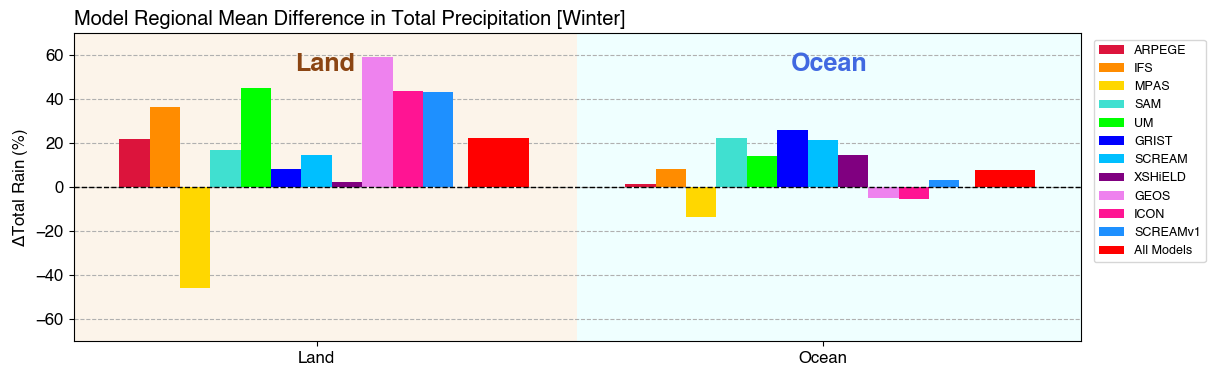

In [174]:
varname1 = 'Total Precipitation'
ylabel = f'$\Delta$Total Rain (%)'
if PHASE == 'Winter':
    ylim = (-70,70)
if PHASE == 'Summer':
    ylim = (-70,70)
width = 0.06
fontsize = 12
figsize = [13,4]
title = f'Model Regional Mean Difference in {varname1} [{PHASE}]'
figname = f'{figdir}globalmap_totpcp_tropics_meandiff_barchart.png'
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':9}
legend_prop = {'ncol':1, 'fontsize':9, 'legend_loc':'upper right', 'legend_anchor':(1.13, 1.)}
fig = bar_chart(dict_totpcp_lo_pyflex, region_names, name_map, width=width, ylabel=ylabel, ylim=ylim, title=title, legend_prop=legend_prop, 
                fontsize=fontsize, figsize=figsize, figname=figname)

In [175]:
# dict_mcscloudfreqAvg_lo.keys()

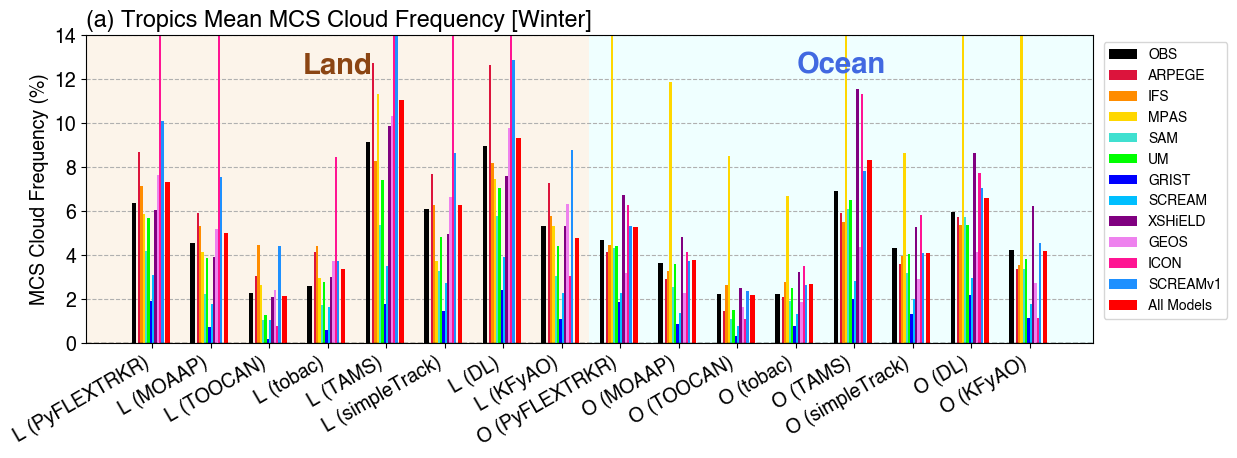

In [176]:
varname1 = 'MCS Cloud Frequency'
ylabel = f'MCS Cloud Frequency (%)'
if PHASE == 'Winter':
    ylim = (0,14)
if PHASE == 'Summer':
    ylim = (0,14)
width = 0.04
fontsize = 14
figsize = [13,4]
xlabel_rotation = 30
title = f'(a) Tropics Mean {varname1} [{PHASE}]'
figname = f'{figdir}barchart_tropics_mean_mcscloudfreq.png'
legend_prop = {'ncol':1, 'fontsize':10, 'legend_loc':'upper right', 'legend_anchor':(1.14, 1.)}
fig = bar_chart(dict_mcscloudfreqAvg_lo, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, title=title, legend_prop=legend_prop, 
                fontsize=fontsize, figsize=figsize, figname=figname, xlabel_rotation=xlabel_rotation)

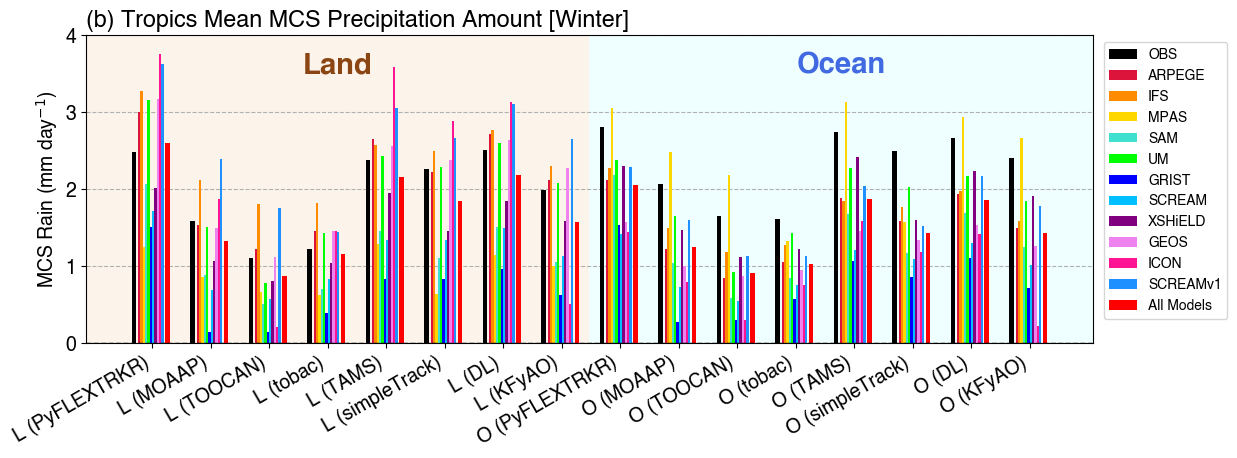

In [177]:
varname1 = 'MCS Precipitation Amount'
ylabel = 'MCS Rain (mm day$^{-1}$)'
if PHASE == 'Winter':
    ylim = (0,4)
if PHASE == 'Summer':
    ylim = (0,4)
width = 0.04
fontsize = 14
figsize = [13,4]
xlabel_rotation = 30
title = f'(b) Tropics Mean {varname1} [{PHASE}]'
figname = f'{figdir}barchart_tropics_mean_mcspcp.png'
legend_prop = {'ncol':1, 'fontsize':10, 'legend_loc':'upper right', 'legend_anchor':(1.14, 1.)}
fig = bar_chart(dict_mcspcpAvg_lo, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, title=title, legend_prop=legend_prop, 
                fontsize=fontsize, figsize=figsize, figname=figname, xlabel_rotation=xlabel_rotation)

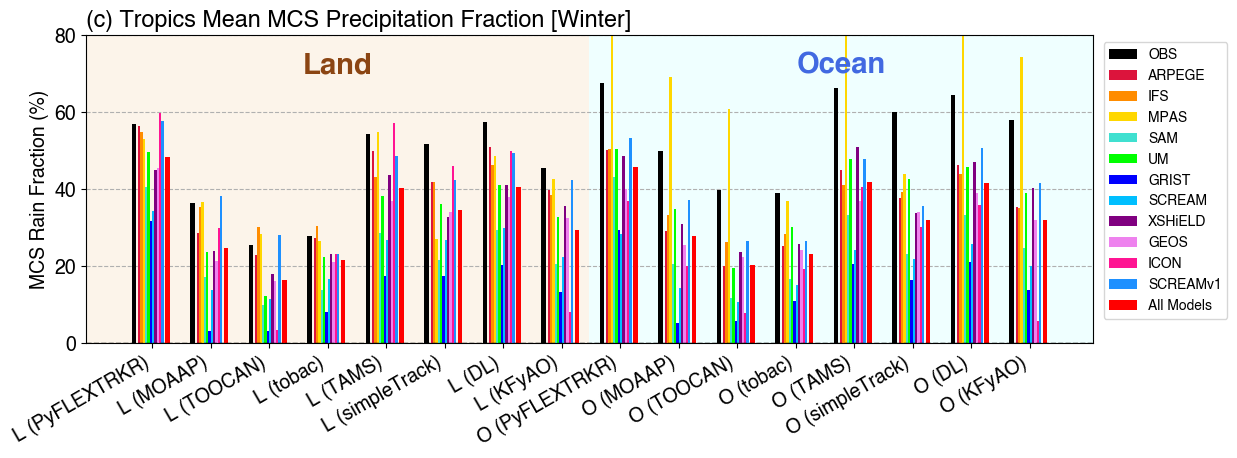

In [178]:
varname1 = 'MCS Precipitation Fraction'
ylabel = f'MCS Rain Fraction (%)'
if PHASE == 'Winter':
    ylim = (0,80)
if PHASE == 'Summer':
    ylim = (0,80)
width = 0.04
fontsize = 14
figsize = [13,4]
xlabel_rotation = 30
title = f'(c) Tropics Mean {varname1} [{PHASE}]'
figname = f'{figdir}barchart_tropics_mean_mcspcpfrac.png'
legend_prop = {'ncol':1, 'fontsize':10, 'legend_loc':'upper right', 'legend_anchor':(1.14, 1.)}
fig = bar_chart(dict_mcspcpfracAvg_lo, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, title=title, legend_prop=legend_prop, 
                fontsize=fontsize, figsize=figsize, figname=figname, xlabel_rotation=xlabel_rotation)

In [179]:
# varname1 = 'MCS Precipitation Frequency'
# ylabel = f'MCS Rain Frequency (%)'
# if PHASE == 'Winter':
#     ylim = (0,3)
# if PHASE == 'Summer':
#     ylim = (0,3)
# width = 0.04
# fontsize = 14
# title = f'Tropics Mean {varname1} [{PHASE}]'
# figsize = [13,4]
# xlabel_rotation = 30
# figname = f'{figdir}barchart_tropics_mean_mcsrainfreq.png'
# legend_prop = {'ncol':1, 'fontsize':10, 'legend_loc':'upper right', 'legend_anchor':(1.14, 1.)}
# fig = bar_chart(dict_mcspcpfreqAvg_lo, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, title=title, legend_prop=legend_prop, 
#                 fontsize=fontsize, figsize=figsize, figname=figname, xlabel_rotation=xlabel_rotation)

In [180]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/barchart_tropics_mean_mcspcpfrac.png'

In [181]:
# ylabel = f'$\Delta$MCS Rain (%)'
# if PHASE == 'Winter':
#     ylim = (-100,100)
# if PHASE == 'Summer':
#     ylim = (-100,100)
# width = 0.07
# # width = 0.1
# figsize = [13,4]
# figname = f'{figdir}globalmap_mcspcp_tropics_meandiff_barchart.png'
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':9}
# fig = bar_chart(dict_mcspcp_lo, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, legend_prop=legend_prop, figsize=figsize, figname=figname, xlabel_rotation=45)

In [182]:
# ylabel = f'$\Delta$MCS Rain Fraction (%)'
# if PHASE == 'Winter':
#     ylim = (-50,50)
# if PHASE == 'Summer':
#     ylim = (-50,50)
# width = 0.07
# figsize = [13,4]
# figname = f'{figdir}globalmap_mcspcpfrac_tropics_meandiff_barchart.png'
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':9}
# fig = bar_chart(dict_mcspcpfrac_lo, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, legend_prop=legend_prop, figsize=figsize, figname=figname, xlabel_rotation=45)

In [183]:
# ylabel = f'$\Delta$MCS Rain Frequency (%)'
# if PHASE == 'Winter':
#     ylim = (-100,100)
# if PHASE == 'Summer':
#     ylim = (-100,100)
# width = 0.07
# figsize = [13,4]
# figname = f'{figdir}globalmap_mcspcpfreq_tropics_meandiff_barchart.png'
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':9}
# fig = bar_chart(dict_mcspcpfreq_lo, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, legend_prop=legend_prop, figsize=figsize, figname=figname, xlabel_rotation=45)

In [184]:
# ylabel = f'$\Delta$MCS Cloud Frequency (%)'
# if PHASE == 'Winter':
#     ylim = (-100,200)
# if PHASE == 'Summer':
#     ylim = (-100,100)
# width = 0.07
# figsize = [13,4]
# figname = f'{figdir}globalmap_mcscloudfreq_tropics_meandiff_barchart.png'
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':9}
# fig = bar_chart(dict_mcscloudfreq_lo, region_names_all, name_map, width=width, ylabel=ylabel, ylim=ylim, legend_prop=legend_prop, figsize=figsize, figname=figname, xlabel_rotation=45)

## Function to plot 1 map and bar chart

In [185]:
def plot_map_bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                  oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None,
                  boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None,
                  bar_data=None, bar_width=None, bar_ylabel=None, legend_prop=None, bar_ylim=None, bar_xlabels=None, bar_xlabel_rotation=0):
                  # boxes=None, boxtextloc=None, dict_text_type=None, dict_text_val=None, text_colors=None, boxtext_fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    ###################################################
    # Map plot
    ###################################################
    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [0.05, 1, 1]
    gs = gridspec.GridSpec(3, 1, height_ratios=h_ratios, width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.25)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    ax = plt.subplot(gs[1,0], projection=proj)
    ax.set_extent(map_extent, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(titles[0], loc='left')
    
    # Grid lines & labels
    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)         
    # if (row == nrow-1):
    ax.set_xticks(lonv, crs=data_proj)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks(latv, crs=data_proj)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
    
    # Select and mask data source
    Zm = np.ma.masked_where(np.isnan(data_map), data_map)
    cmap = copy.copy(mpl.colormaps.get_cmap(cmaps))
    # Set out-of-bounds colors
    if oob_colors is not None:
        cmap.set_over(oob_colors['over'])
        cmap.set_under(oob_colors['under'])
        # cf1.set_clim(min(levels), max(levels))
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    # Plot data
    if (contourf == False):
        cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
    else:
        cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
    # # Set out-of-bounds colors
    # if oob_colors is not None:
    #     cf1.cmap.set_over(oob_colors['over'])
    #     cf1.cmap.set_under(oob_colors['under'])
    #     cf1.set_clim(min(levels), max(levels))
    # Colorbars
    cax1 = plt.subplot(gs[0,0])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks, orientation='horizontal', extend='both')
    cb1.ax.xaxis.set_label_position('top')
    cb1.ax.tick_params(labelsize=cb_fontsize)
        
    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            # Plot region boxes
            corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
            box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
            ax.add_patch(box)

            if boxtexttype is None:
                text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
            else:
                text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    
    ###################################################
    # Bar chart
    ###################################################
    ax2 = plt.subplot(gs[2,0])
    # labels = list(boxes.keys())
    x = np.arange(len(bar_xlabels))
    # multiplier = -((len(name_map)-1)/2)
    multiplier = -((len(bar_data))/2)
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'mediumseagreen',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
        'mmm': 'forestgreen',
    }

    # Loop over each source    
    for key, val in bar_data.items():
        offset = bar_width * multiplier
        rects = ax2.bar(x + offset, val, bar_width, color=lcolors[key], label=name_map[key], zorder=2)
        multiplier += 1    

    # Add some text for xlabels, title and custom x-axis tick xlabels, etc.
    ax2.set_ylabel(bar_ylabel)
    ax2.set_title(titles[1], loc='left')
    # ax2.set_xticks(x, bar_xlabels)
    # Set xlabel text alignment
    xlabel_ha = 'right' if bar_xlabel_rotation > 0 else 'center'
    ax2.set_xticks(x, bar_xlabels, rotation=bar_xlabel_rotation, ha=xlabel_ha)
    
    ax2.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'])
    ax2.axhline(y=0, lw=1, ls='--', color='k')
    ax2.grid(which='major', ls='--', axis='y')
    ax2.set_ylim(bar_ylim[0], bar_ylim[1])
    
    # Shade the background with colors
    # Get x-axis limits
    xmin, xmax = ax2.get_xlim()
    midpoint = (xmin + xmax) / 2
    ax2.axvspan(xmin, midpoint, facecolor='antiquewhite', alpha=0.6)
    ax2.axvspan(midpoint, xmax, facecolor='lightcyan', alpha=0.6)
    ax2.set_xlim(xmin, xmax)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [186]:
# figsize = [12,10]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Cloud Frequency'
# varname2 = '$\Delta$MCS Cloud Frequency'
# units = '%'

# # Map data
# data_dict = mcscloudfreq_obs_pyflex
# levels = [1,2,3,5,7,10,13,16,20,25,30,40]
# cmaps = cc.cm.CET_L19
# titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean Difference in {varname1}']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# # text_val = dict(zip(boxes.keys(),boxes.keys()))
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcscloudfreq_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} (%)'
# bar_ylim = (-100,100)
# bar_width = 0.06
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':8}
# xlabel_rotation = 30
# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_barchart_diff.png'

# fig = plot_map_bars(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=xlabel_rotation)

In [187]:
# figsize = [12,10]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Rain Frequency'
# varname2 = '$\Delta$MCS Rain Frequency'
# units = '%'

# # Map data
# data_dict = mcspcpfreq_obs_pyflex
# levels = [0.2,0.5,1,2,2.5,3,5,7,10,13,16,20]
# cmaps = cc.cm.CET_L19
# titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean Difference in {varname1}']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# # text_val = dict(zip(boxes.keys(),boxes.keys()))
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcpfreq_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} (%)'
# bar_ylim = (-100,100)
# bar_width = 0.06
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':8}
# xlabel_rotation = 30
# figname = f'{figdir}globalmap_mcs_rainfreq_obs_barchart_diff.png'

# fig = plot_map_bars(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=xlabel_rotation)

In [188]:
# figsize = [12,10]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Map data
# data_dict = mcspcp_obs_pyflex
# levels = [1,2,3,5,7,10,13,16,20,25]
# cmaps = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean Difference in {varname1}']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# # text_val = dict(zip(boxes.keys(),boxes.keys()))
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcp_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} (%)'
# bar_ylim = (-100,100)
# bar_width = 0.06
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':8}
# xlabel_rotation = 30
# figname = f'{figdir}globalmap_mcs_rain_obs_barchart_diff.png'

# fig = plot_map_bars(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=xlabel_rotation)

In [189]:
# figsize = [12,10]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Map data
# data_dict = mcspcpfrac_obs_pyflex
# levels = np.arange(0, 90.01, 10)
# cmaps = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmaps = truncate_colormap(cmaps, 0.0, 0.9)
# titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean Difference in {varname1}']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'magenta'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# # text_val = dict(zip(boxes.keys(),boxes.keys()))
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcpfrac_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} (%)'
# bar_ylim = (-50,50)
# bar_width = 0.06
# legend_prop = {'ncol':len(name_map)-1, 'fontsize':8}
# xlabel_rotation = 30
# figname = f'{figdir}globalmap_mcs_rainfrac_obs_barchart_diff.png'

# fig = plot_map_bars(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=xlabel_rotation)

In [190]:
figdir

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/'

In [191]:
# figsize = [12,10]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Rain'
# varname2 = 'MCS Rain'
# units = 'mm day$^{-1}$'

# # Map data
# data_dict = mcspcp_obs_pyflex
# levels = [1,2,3,5,7,10,13,16,20,25]
# cmaps = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean {varname1}']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# # text_val = dict(zip(boxes.keys(),boxes.keys()))
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcpAvg_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} ({units})'
# bar_ylim = (0,4)
# bar_width = 0.07
# legend_prop = {'ncol':len(name_map), 'fontsize':8}

# figname = f'{figdir}globalmap_mcs_rain_obs_barchart.png'

# fig = plot_map_bars(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=45)

In [192]:
# figsize = [12,10]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Rain Fraction'
# varname2 = 'MCS Rain Fraction'
# units = '%'

# # Map data
# data_dict = mcspcpfrac_obs_pyflex
# levels = np.arange(0, 90.01, 10)
# cmaps = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmaps = truncate_colormap(cmaps, 0.0, 0.9)
# titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean {varname1}']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'magenta'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# # text_val = dict(zip(boxes.keys(),boxes.keys()))
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcpfracAvg_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} (%)'
# bar_ylim = (0,80)
# bar_width = 0.07
# legend_prop = {'ncol':len(name_map), 'fontsize':8}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_barchart.png'

# fig = plot_map_bars(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=45)

In [193]:
# figsize = [12,10]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Cloud Frequency'
# varname2 = 'MCS Cloud Frequency'
# units = '%'

# # Map data
# data_dict = mcscloudfreq_obs_pyflex
# levels = [1,2,3,5,7,10,13,16,20,25,30,40]
# cmaps = cc.cm.CET_L19
# titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean {varname1}']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# # text_val = dict(zip(boxes.keys(),boxes.keys()))
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcscloudfreqAvg_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} ({units})'
# bar_ylim = (0,15)
# bar_width = 0.07
# legend_prop = {'ncol':len(name_map), 'fontsize':8}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_barchart.png'

# fig = plot_map_bars(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=45)

In [194]:
# figsize = [12,10]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Rain Frequency'
# varname2 = 'MCS Rain Frequency'
# units = '%'

# # Map data
# data_dict = mcspcpfreq_obs_pyflex
# levels = [0.2,0.5,1,2,2.5,3,5,7,10,13,16,20]
# cmaps = cc.cm.CET_L19
# titles = [f'(a) {varname1} (OBS) [PyFLEXTRKR]', f'(b) Model Regional Mean Difference in {varname1}']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'firebrick'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# # text_val = dict(zip(boxes.keys(),boxes.keys()))
# text_val = {'Land':'Tropics', 'Ocean':'Tropics'}

# # Bar chart data
# bar_data = dict_mcspcpfreqAvg_lo
# bar_xlabels = region_names_all
# bar_ylabel = f'{varname2} (%)'
# bar_ylim = (0,3)
# bar_width = 0.07
# legend_prop = {'ncol':len(name_map), 'fontsize':8}

# figname = f'{figdir}globalmap_mcs_rainfreq_obs_barchart.png'

# fig = plot_map_bars(data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_xlabels=bar_xlabels, bar_xlabel_rotation=45)

In [195]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/barchart_tropics_mean_mcspcpfrac.png'

## Function to plot multi-row maps for all sources

In [196]:
def plot_maps_nrow(nrow, data_dict, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                   oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None,
                   boxes=None, boxtextloc=None, dict_text_type=None, dict_text_val=None, text_colors=None, boxtext_fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [0.05] + list(np.repeat(1,nrow)) + [0.05]
    gs = gridspec.GridSpec(nrow+2, 1, height_ratios=h_ratios, width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.13)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    cf_save = []
    for row in range(0, nrow):
        ax = plt.subplot(gs[row+1,0], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_aspect('auto', adjustable=None)
        # Title
        flabel = ax.text(0.02, 0.05, titles[row], transform=ax.transAxes, fontsize=None)
        flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
        
        # Grid lines & labels
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)         
        if (row == nrow-1):
            ax.set_xticks(lonv, crs=data_proj)
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=data_proj)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=data_proj, zorder=3)

        # Select and mask data source
        data = data_dict.isel(source=row)
        Zm = np.ma.masked_where(np.isnan(data), data)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[row]))
        # Set out-of-bounds colors
        if oob_colors is not None:
            oob_c = oob_colors[row]
            if oob_c is not None:
                cmap.set_over(oob_c['over'])
                cmap.set_under(oob_c['under'])
        norm = colors.BoundaryNorm(boundaries=levels[row], ncolors=cmap.N)
        # Plot data
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels[row], norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
        cf_save.append(cf1)

        # Plot regional boxes
        if boxes is not None:
            # Loop over each box dictionary
            for ii in boxes:
                # Plot region boxes
                corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
                box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
                ax.add_patch(box)
                
                # Get key using row number
                key = list(dict_text_type.keys())[row]
                boxtexttype = dict_text_type[key]
                boxtext = dict_text_val[key]
                
                # Plot box text
                if boxtexttype == 'float':
                    text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=boxtext_fontsize, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                if boxtexttype == 'string':
                    text_color = 'k'
                    ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                            bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                            fontsize=boxtext_fontsize, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
                
    # Colorbars
    cax1 = plt.subplot(gs[0,0])
    cax2 = plt.subplot(gs[-1,0])
    cb1 = plt.colorbar(cf_save[0], cax=cax1, label=cblabels[0], ticks=cbticks[0], orientation='horizontal', extend='both')
    cb2 = plt.colorbar(cf_save[-1], cax=cax2, label=cblabels[1], ticks=cbticks[1], orientation='horizontal', extend='both')
    cb1.ax.xaxis.set_label_position('top')
        # # cb1.set_label(cblabel, fontsize=14)
    cb1.ax.tick_params(labelsize=cb_fontsize)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [197]:
# Combine region names & model difference values to a dictionary
dict1 = {'obs': list(boxes.keys())}
# dict1 = {'obs': {'Land': 'Tropics', 'Ocean': 'Tropics'}}
dict_text_combine = {**dict1, **dict_totpcp_o_pyflex}
# Make dictionary key with region names
dict_text_val = {}
for key, val in name_map.items():
    boxtext = dict_text_combine[key]
    dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# Make text type for each source
dict1 = {'obs': 'string'}
dict2 = {key: 'float' for key in dict_totpcp_o_pyflex}
dict_text_type = {**dict1, **dict2}
# dict_text_type

dict_text_val['obs'] = {'Land': 'Tropics', 'Ocean': 'Tropics'}
print(dict_text_val)
# dict_text_combine

{'obs': {'Land': 'Tropics', 'Ocean': 'Tropics'}, 'm1': {'Land': 1.4638105630874634, 'Ocean': 1.4638105630874634}, 'm2': {'Land': 8.496603012084961, 'Ocean': 8.496603012084961}, 'm3': {'Land': -13.368117332458496, 'Ocean': -13.368117332458496}, 'm5': {'Land': 22.334627151489258, 'Ocean': 22.334627151489258}, 'm6': {'Land': 14.390344619750977, 'Ocean': 14.390344619750977}, 'm7': {'Land': 26.088045120239258, 'Ocean': 26.088045120239258}, 'm8': {'Land': 21.401596069335938, 'Ocean': 21.401596069335938}, 'm9': {'Land': 14.597574234008789, 'Ocean': 14.597574234008789}, 'm10': {'Land': -4.980404853820801, 'Ocean': -4.980404853820801}, 'm11': {'Land': -5.10949182510376, 'Ocean': -5.10949182510376}, 'm12': {'Land': 3.2492263317108154, 'Ocean': 3.2492263317108154}, 'mmm': {'Land': 8.009967803955078, 'Ocean': 8.009967803955078}}


## OBS total precipitation & model-obs difference maps

In [198]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'Total Rain'
# varname2 = '$\Delta$Total Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([totpcp_obs_pyflex, totpcp_diff_pyflex], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]})')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_total_rain_obs_diff_all.png'

# # lon_lm.shape, lon_lm.shape, data_dict.sel(source='obs').shape, data_dict.sel(source='m1').shape
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

## MCS precipitation & model-obs differences (PyFLEXTRKR)

In [199]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcp_obs_pyflex, mcspcp_diff_pyflex], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rain_obs_diff_all_PyFLEXTRKR.png'

# # lon_obs.shape, lat_obs.shape, data_dict.sel(source='obs').shape
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )
#                      # boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [200]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_toocan.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcp_obs_toocan, mcspcp_diff_toocan], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  TOOCAN)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rain_obs_diff_all_TOOCAN.png'

# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [201]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_moaap.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcp_obs_moaap, mcspcp_diff_moaap], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  MOAAP)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rain_obs_diff_all_MOAAP.png'

# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [202]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_tobac.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcp_obs_tobac, mcspcp_diff_tobac], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  tobac)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rain_obs_diff_all_tobac.png'

# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [203]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_tams.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcp_obs_tams, mcspcp_diff_tams], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  TAMS)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rain_obs_diff_all_TAMS.png'

# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [204]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_simtrack.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcp_obs_simtrack, mcspcp_diff_simtrack], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  simpleTrack)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rain_obs_diff_all_simpleTrack.png'

# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

## MCS cloud frequency

In [205]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_pyflex, mcscloudfreq_diff_pyflex], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_PyFLEXTRKR.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [206]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_kfyao.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_kfyao, mcscloudfreq_diff_kfyao], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  KFyAO)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_KFyAO.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [207]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_dl.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_dl, mcscloudfreq_diff_dl], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  DL)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_DL.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [208]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_moaap.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_moaap, mcscloudfreq_diff_moaap], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  MOAAP)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_MOAAP.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [209]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_toocan.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_toocan, mcscloudfreq_diff_toocan], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  TOOCAN)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_TOOCAN.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [210]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_tobac.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_tobac, mcscloudfreq_diff_tobac], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  tobac)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_tobac.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )
#                      # boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [211]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_tams.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_tams, mcscloudfreq_diff_tams], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  TAMS)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_TAMS.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )
#                      # boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [212]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_simtrack.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_simtrack, mcscloudfreq_diff_simtrack], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  simpleTrack)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_simpleTrack.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

## MCS rain fraction

In [213]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Combine OBS & model differences
# min_mcspcp_thresh = 1.0  # [mm/day]
# data_dict = xr.concat([mcspcpfrac_obs_pyflex, mcspcpfrac_diff_pyflex.where(mcspcp_mod_pyflex > min_mcspcp_thresh)], dim='source')
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-60, 60.1, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'magenta'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_diff_all_PyFLEXTRKR.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [214]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_moaap.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Combine OBS & model differences
# min_mcspcp_thresh = 1.0  # [mm/day]
# data_dict = xr.concat([mcspcpfrac_obs_moaap, mcspcpfrac_diff_moaap.where(mcspcp_mod_moaap > min_mcspcp_thresh)], dim='source')
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-60, 60.1, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  MOAAP)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'magenta'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_diff_all_MOAAP.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [215]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_toocan.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Combine OBS & model differences
# min_mcspcp_thresh = 1.0  # [mm/day]
# data_dict = xr.concat([mcspcpfrac_obs_toocan, mcspcpfrac_diff_toocan.where(mcspcp_mod_toocan > min_mcspcp_thresh)], dim='source')
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-60, 60.1, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  TOOCAN)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'magenta'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_diff_all_TOOCAN.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [216]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_tobac.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Combine OBS & model differences
# min_mcspcp_thresh = 1.0  # [mm/day]
# data_dict = xr.concat([mcspcpfrac_obs_tobac, mcspcpfrac_diff_tobac.where(mcspcp_mod_tobac > min_mcspcp_thresh)], dim='source')
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-60, 60.1, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  tobac)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'magenta'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_diff_all_tobac.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [217]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_tams.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Combine OBS & model differences
# min_mcspcp_thresh = 1.0  # [mm/day]
# data_dict = xr.concat([mcspcpfrac_obs_tams, mcspcpfrac_diff_tams.where(mcspcp_mod_tams > min_mcspcp_thresh)], dim='source')
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-60, 60.1, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  TAMS)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'magenta'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_diff_all_TAMS.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

In [218]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_simtrack.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Combine OBS & model differences
# min_mcspcp_thresh = 1.0  # [mm/day]
# data_dict = xr.concat([mcspcpfrac_obs_simtrack, mcspcpfrac_diff_simtrack.where(mcspcp_mod_simtrack > min_mcspcp_thresh)], dim='source')
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-60, 60.1, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  simpleTrack)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'magenta'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_diff_all_simpleTrack.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, )

## Separate land vs. ocean plots

In [219]:
# Combine region names & model difference values to a dictionary
dict1 = {'obs': list(boxes.keys())}
dict_text_combine = {**dict1, **dict_mcspcp_o_pyflex}
# Make dictionary key with region names
dict_text_val = {}
for key, val in name_map.items():
    boxtext = dict_text_combine[key]
    dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# Make text type for each source
dict1 = {'obs': 'string'}
dict2 = {key: 'float' for key in dict_mcspcp_o_pyflex}
dict_text_type = {**dict1, **dict2}
# dict_text_type

dict_text_val['obs'] = {'Land': 'Tropics (Ocean)', 'Ocean': 'Tropics (Ocean)'}
print(dict_text_val)

{'obs': {'Land': 'Tropics (Ocean)', 'Ocean': 'Tropics (Ocean)'}, 'm1': {'Land': -24.55478286743164, 'Ocean': -24.55478286743164}, 'm2': {'Land': -18.954214096069336, 'Ocean': -18.954214096069336}, 'm3': {'Land': 8.834779739379883, 'Ocean': 8.834779739379883}, 'm5': {'Land': -22.02594566345215, 'Ocean': -22.02594566345215}, 'm6': {'Land': -14.906621932983398, 'Ocean': -14.906621932983398}, 'm7': {'Land': -45.09535217285156, 'Ocean': -45.09535217285156}, 'm8': {'Land': -49.24137496948242, 'Ocean': -49.24137496948242}, 'm9': {'Land': -17.69135284423828, 'Ocean': -17.69135284423828}, 'm10': {'Land': -43.675628662109375, 'Ocean': -43.675628662109375}, 'm11': {'Land': -48.264915466308594, 'Ocean': -48.264915466308594}, 'm12': {'Land': -18.533184051513672, 'Ocean': -18.533184051513672}, 'mmm': {'Land': -26.790681838989258, 'Ocean': -26.790681838989258}}


In [220]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcp_obs_pyflex.where(landmask >= ocean_thresh), mcspcp_diff_pyflex.where(landmask >= ocean_thresh)], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rain_obs_diff_all_ocean_PyFLEXTRKR.png'

# # lon_obs.shape, lat_obs.shape, data_dict.sel(source='obs').shape
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                      boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [221]:
# # Combine region names & model difference values to a dictionary
# dict1 = {'obs': list(boxes.keys())}
# dict_text_combine = {**dict1, **dict_mcspcp_l_pyflex}
# # Make dictionary key with region names
# dict_text_val = {}
# for key, val in name_map.items():
#     boxtext = dict_text_combine[key]
#     dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# # Make text type for each source
# dict1 = {'obs': 'string'}
# dict2 = {key: 'float' for key in dict_mcspcp_l_pyflex}
# dict_text_type = {**dict1, **dict2}
# # dict_text_type

# dict_text_val['obs'] = {'Land': 'Tropics (Land)', 'Ocean': 'Tropics (Land)'}
# dict_text_val
# # print(dict_text_val)

In [222]:
# figwidth = 12
# height_ratio_per_panel = 0.35
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain'
# varname2 = '$\Delta$MCS Rain'
# units = 'mm day$^{-1}$'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcp_obs_pyflex.where(landmask <= land_thresh), mcspcp_diff_pyflex.where(landmask <= land_thresh)], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25]
# lev2 = [-20,-16,-12,-8,-4,4,8,12,16,20]
# cmap1 = generate_NCL_cmap('precip3_16lev', cont_param_ws='sRGB')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rain_obs_diff_all_land_PyFLEXTRKR.png'

# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                      boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [223]:
# # Combine region names & model difference values to a dictionary
# dict1 = {'obs': list(boxes.keys())}
# dict_text_combine = {**dict1, **dict_mcspcpfreq_o_pyflex}
# # Make dictionary key with region names
# dict_text_val = {}
# for key, val in name_map.items():
#     boxtext = dict_text_combine[key]
#     dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# # Make text type for each source
# dict1 = {'obs': 'string'}
# dict2 = {key: 'float' for key in dict_mcspcpfreq_o_pyflex}
# dict_text_type = {**dict1, **dict2}

# dict_text_val['obs'] = {'Land': 'Tropics (Ocean)', 'Ocean': 'Tropics (Ocean)'}
# dict_text_val

In [224]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Freq'
# varname2 = '$\Delta$MCS Rain Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcpfreq_obs_pyflex.where(landmask >= ocean_thresh), mcspcpfreq_diff_pyflex.where(landmask >= ocean_thresh)], dim='source')
# lev1 = [0.2,0.5,1,2,2.5,3,5,7,10,13,16,20]
# lev2 = np.arange(-10, 10.1, 2)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfreq_obs_diff_all_ocean_PyFLEXTRKR.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                      boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [225]:
# # Combine region names & model difference values to a dictionary
# dict1 = {'obs': list(boxes.keys())}
# dict_text_combine = {**dict1, **dict_mcspcpfreq_l_pyflex}
# # Make dictionary key with region names
# dict_text_val = {}
# for key, val in name_map.items():
#     boxtext = dict_text_combine[key]
#     dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# # Make text type for each source
# dict1 = {'obs': 'string'}
# dict2 = {key: 'float' for key in dict_mcspcpfreq_l_pyflex}
# dict_text_type = {**dict1, **dict2}

# dict_text_val['obs'] = {'Land': 'Tropics (Land)', 'Ocean': 'Tropics (Land)'}
# dict_text_val

In [226]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Freq'
# varname2 = '$\Delta$MCS Rain Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcspcpfreq_obs_pyflex.where(landmask <= land_thresh), mcspcpfreq_diff_pyflex.where(landmask <= land_thresh)], dim='source')
# lev1 = [0.2,0.5,1,2,2.5,3,5,7,10,13,16,20]
# lev2 = np.arange(-10, 10.1, 2)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfreq_obs_diff_all_land_PyFLEXTRKR.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                      boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [227]:
# # Combine region names & model difference values to a dictionary
# dict1 = {'obs': list(boxes.keys())}
# dict_text_combine = {**dict1, **dict_mcscloudfreq_o_pyflex}
# # Make dictionary key with region names
# dict_text_val = {}
# for key, val in name_map.items():
#     boxtext = dict_text_combine[key]
#     dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# # Make text type for each source
# dict1 = {'obs': 'string'}
# dict2 = {key: 'float' for key in dict_mcscloudfreq_o_pyflex}
# dict_text_type = {**dict1, **dict2}

# dict_text_val['obs'] = {'Land': 'Tropics (Ocean)', 'Ocean': 'Tropics (Ocean)'}
# dict_text_val

In [228]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_pyflex.where(landmask >= ocean_thresh), mcscloudfreq_diff_pyflex.where(landmask >= ocean_thresh)], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_ocean_PyFLEXTRKR.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                      boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [229]:
# # Combine region names & model difference values to a dictionary
# dict1 = {'obs': list(boxes.keys())}
# dict_text_combine = {**dict1, **dict_mcscloudfreq_l_pyflex}
# # Make dictionary key with region names
# dict_text_val = {}
# for key, val in name_map.items():
#     boxtext = dict_text_combine[key]
#     dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# # Make text type for each source
# dict1 = {'obs': 'string'}
# dict2 = {key: 'float' for key in dict_mcscloudfreq_l_pyflex}
# dict_text_type = {**dict1, **dict2}

# dict_text_val['obs'] = {'Land': 'Tropics (Land)', 'Ocean': 'Tropics (Land)'}
# dict_text_val

In [230]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Cloud Freq'
# varname2 = '$\Delta$MCS Cloud Freq'
# units = '%'

# # Combine OBS & model differences
# data_dict = xr.concat([mcscloudfreq_obs_pyflex.where(landmask <= land_thresh), mcscloudfreq_diff_pyflex.where(landmask <= land_thresh)], dim='source')
# lev1 = [1,2,3,5,7,10,13,16,20,25,30,40]
# lev2 = np.arange(-20, 20.1, 4)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = cc.cm.CET_L19
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]}  PyFLEXTRKR)')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_cloudfreq_obs_diff_all_land_PyFLEXTRKR.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                      boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [231]:
# # Combine region names & model difference values to a dictionary
# dict1 = {'obs': list(boxes.keys())}
# dict_text_combine = {**dict1, **dict_mcspcpfrac_o_pyflex}
# # Make dictionary key with region names
# dict_text_val = {}
# for key, val in name_map.items():
#     boxtext = dict_text_combine[key]
#     dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# # Make text type for each source
# dict1 = {'obs': 'string'}
# dict2 = {key: 'float' for key in dict_mcspcpfrac_o_pyflex}
# dict_text_type = {**dict1, **dict2}

# dict_text_val['obs'] = {'Land': 'Tropics (Ocean)', 'Ocean': 'Tropics (Ocean)'}
# dict_text_val

In [232]:
# min_mcspcp_thresh = 1.0
# mcspcpfrac_diff.where(mcspcp_mod > min_mcspcp_thresh).where(landmask >= ocean_thresh)

In [233]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Combine OBS & model differences
# min_mcspcp_thresh = 1.0  # [mm/day]
# data_dict = xr.concat([mcspcpfrac_obs_pyflex.where(landmask >= ocean_thresh), mcspcpfrac_diff_pyflex.where(mcspcp_mod_pyflex > min_mcspcp_thresh).where(landmask >= ocean_thresh)], dim='source')
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-60, 60.1, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]})')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'magenta'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_diff_all_ocean_PyFLEXTRKR.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                      boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [234]:
# # Combine region names & model difference values to a dictionary
# dict1 = {'obs': list(boxes.keys())}
# dict_text_combine = {**dict1, **dict_mcspcpfrac_l_pyflex}
# # Make dictionary key with region names
# dict_text_val = {}
# for key, val in name_map.items():
#     boxtext = dict_text_combine[key]
#     dict_text_val[key] = dict(zip(boxes.keys(), boxtext))

# # Make text type for each source
# dict1 = {'obs': 'string'}
# dict2 = {key: 'float' for key in dict_mcspcpfrac_l_pyflex}
# dict_text_type = {**dict1, **dict2}

# dict_text_val['obs'] = {'Land': 'Tropics (Land)', 'Ocean': 'Tropics (Land)'}
# dict_text_val

In [235]:
# figwidth = 12
# height_ratio_per_panel = 0.35 
# ratio = height_ratio_per_panel * ds_pyflex.dims['source']
# figsize = [figwidth,figwidth*ratio]
# fontsize = 12
# cb_fontsize = 10
# varname1 = 'MCS Rain Fraction'
# varname2 = '$\Delta$MCS Rain Fraction'
# units = '%'

# # Combine OBS & model differences
# min_mcspcp_thresh = 1.0  # [mm/day]
# data_dict = xr.concat([mcspcpfrac_obs_pyflex.where(landmask <= land_thresh), mcspcpfrac_diff_pyflex.where(mcspcp_mod_pyflex > min_mcspcp_thresh).where(landmask <= land_thresh)], dim='source')
# lev1 = np.arange(0, 90.01, 10)
# lev2 = np.arange(-60, 60.1, 10)
# lev2 = np.delete(lev2, int((len(lev2)-1)/2))
# cmap1 = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmap2 = 'BrBG'

# nrows = len(name_map)
# nmodel = nrows-1
# titles = []
# for ii in range(len(name_map)):
#     key = list(name_map.keys())[ii]
#     label = '('+chr(ord('a') + ii)+')'
#     if key == 'obs': 
#         titles.append(f'{label} {varname1} ({name_map[key]})')
#     else:
#         titles.append(f'{label} {varname2} ({name_map[key]} - OBS)')

# levels = [lev1] + [lev2]*nmodel
# cbticks = levels
# cmaps = [cmap1] + [cmap2]*nmodel
# oob_colors = [{'under':'white', 'over':'magenta'}] + [None]*nmodel
# cblabels = [f'{varname1} ({units})', f'{varname2} ({units})']
# text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

# figname = f'{figdir}globalmap_mcs_rainfrac_obs_diff_all_land_PyFLEXTRKR.png'
# fig = plot_maps_nrow(nrows, data_dict, lon_lm, lat_lm, titles, levels, cmaps, cblabels, cbticks, figname, 
#                      figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                      boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)